<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
 

<strong>Objectives:</strong>
+ Variables significativas para el clustering de productos
    
    
<strong>Conclusions:</strong>

   
</div>

In [1]:
import os, sys

def get_root_path(search_word):
    """ Búsqueda hacia atrás de un directorio con nombre search_word. """
    cwd = os.getcwd()
    while str(os.getcwd()).split('/')[-1] != search_word:
        os.chdir("..")
        cwd = os.getcwd()
    return cwd

ROOT_DIR = get_root_path('TFM_StockForecast')

sys.path.insert(0, ROOT_DIR) # Poner en el primer lugar del PATH (evitar paquetes con mismos nombres en otros directorios)

In [2]:
import pandas as pd
import numpy as np
from src.load_data import load_clustering_data
from src.trainer_clustering import get_pca_components, plot_cluster, train_DBSCAN, search_best

In [3]:
df = load_clustering_data()
df.head()

===================  LOAD DATASET stock ====================
Reading CSV in data/raw/03_TablaStock.csv...
=============  CLEAN CSV  ==============
Set columns to lowcase.
Sort values by date.
Dropped duplicates. Rows dropped: 628.
============  CLEAN STOCK  =============
Dropped rows with data from products with no stock data or out-of-date (descatalogados). Rows dropped: 1784
[WARNING] Number of dates missings:                                83
[WARNING] Number of dates missings (droping sundays and festivos): 63
[WARNING] Stock data with different units for same product & data. Rows: 12666
Dataset stock loaded. Shape: (25518, 3)

===================  LOAD DATASET ventas ===================
Reading CSV in data/raw/01_TablaVentas.csv...
=============  CLEAN CSV  ==============
Set columns to lowcase.
Sort values by date.
Dropped duplicates. Rows dropped: 0.
============  CLEAN VENTAS  ============
Dropped rows with data from products with no stock data or out-of-date (descatalogados). 

/mnt/c/Users/Administrador/Documents/GitHub/TFM_StockForecast/src/create_variables.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ts['missing'] = (ts.udsstock.isna()) * 1


Getting datetime variables: weekday, quarter, month, weekofyear
Getting deltaStock as the difference of Stock from today to tomorrow


/mnt/c/Users/Administrador/Documents/GitHub/TFM_StockForecast/src/create_variables.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  prod_data['deltaStock'] = prod_data.udsstock.diff(periods=-1)


Getting rolling windows of last 5 days by product and weekday for column udsventa


/mnt/c/Users/Administrador/Documents/GitHub/TFM_StockForecast/src/create_variables.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  day_data[colname] = day_data[col].rolling(4, win_type='triang', min_periods=1).mean()


Getting rolling windows of last 5 days by product and weekday for column udsstock
Getting rolling windows of last 5 days by product and weekday for column udsprevisionempresa
Assingning nulls in udsVenta as 0 [TEMPORARY]
Dropping dates from 23 to 26 March 20
================  BUILD VENTAS BY PRODUCTO  ================
Dataset ventas by product builded



producto  fecha_min  fecha_max  frecuencia  intermitencia  venta_min  \
0        1 2019-06-05 2020-03-21         224  112358.744395        0.0   
1       10 2019-06-05 2020-03-20         195  128709.278351        0.0   
2       11 2019-06-05 2020-03-21         227  110867.256637        0.0   
3       12 2019-06-05 2020-03-21         235  107076.923077        0.0   
4       13 2019-06-05 2020-03-20         195  128709.278351        0.0   

   venta_q5  venta_q25  venta_median  venta_q75  venta_q95  venta_max  \
0       0.0      472.0        1889.0    6140.00   12232.80    41564.0   
1       0.0        0.0        1792.5    3032.50    5186.75     9490.0   
2       0.0      551.0        1653.0    2755.00    4408.00    22041.0   
3       0.0      469.5         870.0    1283.75    1833.05     5057.0   
4       0.0        0.0        1549.0    2442.50    3856.00     5421.0   

   venta_iqr   venta_mean    venta_std  venta_CV  venta_skew  venta_kurtosis  \
0    5668.00  4014.339041  5951.822563  1.480100    3.428471       15.050234   
1    3032.50  1878.434932  1730.163792  0.919488    0.760667        0.586530   
2    2204.00  2058.712329  2431.126410  1.178873    4.854331       34.470112   
3     814.25   899.684932   698.482255  0.775033    1.546503        6.426522   
4    2442.50  1507.482877  1322.287707  0.875646    0.435647       -0.589084   

     venta_mad  
0  3784.991603  
1  1398.386400  
2  1393.291518  
3   504.840683  
4  1091.281174

In [4]:
df.describe()

frecuencia  intermitencia  venta_min  venta_q5    venta_q25  \
count   72.000000      72.000000       72.0      72.0    72.000000   
mean   220.347222  117861.250426        0.0       0.0   249.138889   
std     31.030725   32244.230676        0.0       0.0   405.502108   
min     78.000000  103966.804979        0.0       0.0     0.000000   
25%    209.500000  106508.330328        0.0       0.0     0.000000   
50%    234.500000  107166.047745        0.0       0.0    87.125000   
75%    236.250000  115676.161762        0.0       0.0   297.562500   
max    242.000000  319792.207792        0.0       0.0  2067.750000   

       venta_median    venta_q75     venta_q95     venta_max    venta_iqr  \
count     72.000000    72.000000     72.000000     72.000000    72.000000   
mean     799.812500  1229.253472   1956.709028   5557.652778   980.114583   
std      767.929824  1217.494145   2001.825187   8408.764072  1001.939088   
min        0.000000     3.750000     44.000000     66.000000     3.750000   
25%      290.750000   426.937500    733.150000   1544.250000   367.937500   
50%      553.000000   837.000000   1332.325000   2561.500000   676.125000   
75%     1006.000000  1430.937500   2020.875000   5295.750000  1036.187500   
max     4132.000000  6140.000000  12232.800000  41564.000000  5668.000000   

        venta_mean    venta_std   venta_CV  venta_skew  venta_kurtosis  \
count    72.000000    72.000000  72.000000   72.000000       72.000000   
mean    843.649068   786.930076   0.943653    1.318037        6.462266   
std     841.731760   945.586440   0.398300    1.532109       14.017756   
min      17.270548    15.456138   0.597458   -0.305244       -1.314003   
25%     291.979452   257.949611   0.761951    0.440521        0.254472   
50%     566.832192   505.846456   0.842732    0.871292        1.690436   
75%     972.037671   891.297237   0.965535    1.420597        5.433563   
max    4212.236301  5951.822563   2.706029    7.195982       79.935774   

         venta_mad  
count    72.000000  
mean    567.246600  
std     604.043908  
min      12.728162  
25%     210.589909  
50%     379.032042  
75%     553.079881  
max    3784.991603

In [5]:
data = df[["producto","intermitencia","venta_median", "venta_q95", "venta_iqr", "venta_CV"]].set_index("producto")

In [6]:
data.head()

intermitencia  venta_median  venta_q95  venta_iqr  venta_CV
producto                                                             
1         112358.744395        1889.0   12232.80    5668.00  1.480100
10        128709.278351        1792.5    5186.75    3032.50  0.919488
11        110867.256637        1653.0    4408.00    2204.00  1.178873
12        107076.923077         870.0    1833.05     814.25  0.775033
13        128709.278351        1549.0    3856.00    2442.50  0.875646

In [7]:
# Get the number of PCA compontents for 0.9999 explanation
n = get_pca_components(data, variance_limit=0.9999)
n

3

Metrics:
{'n_features': 2, 'epsilon': 0.1, 'min_samples': 0, 'n_clusters': 31, 'n_noise': 0, 'silhouette': 0.27017063093372057, 'explained_pca_variance': 0.9997911528198771}
Metrics:
{'n_features': 2, 'epsilon': 0.1, 'min_samples': 1, 'n_clusters': 31, 'n_noise': 0, 'silhouette': 0.2701701195962875, 'explained_pca_variance': 0.9998955414272579}
Metrics:
{'n_features': 2, 'epsilon': 0.1, 'min_samples': 2, 'n_clusters': 7, 'n_noise': 24, 'silhouette': 0.15593198126933153, 'explained_pca_variance': 0.9999303585268561}
Metrics:
{'n_features': 2, 'epsilon': 0.1, 'min_samples': 3, 'n_clusters': 4, 'n_noise': 30, 'silhouette': 0.16300681962820948, 'explained_pca_variance': 0.9999477792287996}
Metrics:
{'n_features': 2, 'epsilon': 0.1, 'min_samples': 4, 'n_clusters': 3, 'n_noise': 33, 'silhouette': 0.17235069796317154, 'explained_pca_variance': 0.999958223364643}
Metrics:
{'n_features': 2, 'epsilon': 0.2, 'min_samples': 0, 'n_clusters': 18, 'n_noise': 0, 'silhouette': 0.09220206101294198, 'exp

/mnt/c/Users/Administrador/Documents/GitHub/TFM_StockForecast/src/trainer_clustering.py:38: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure(figsize=(20,10))


Metrics:
{'n_features': 2, 'epsilon': 0.5, 'min_samples': 1, 'n_clusters': 8, 'n_noise': 0, 'silhouette': 0.3990459455503653, 'explained_pca_variance': 0.9999905050376486}


/mnt/c/Users/Administrador/Documents/GitHub/TFM_StockForecast/src/trainer_clustering.py:38: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure(figsize=(20,10))


Metrics:
{'n_features': 2, 'epsilon': 0.5, 'min_samples': 2, 'n_clusters': 2, 'n_noise': 6, 'silhouette': 0.6876661917433143, 'explained_pca_variance': 0.9999909178583484}
Metrics:
{'n_features': 2, 'epsilon': 0.5, 'min_samples': 3, 'n_clusters': 1, 'n_noise': 8, 'silhouette': 0.6802026763863469, 'explained_pca_variance': 0.9999912962864357}


/mnt/c/Users/Administrador/Documents/GitHub/TFM_StockForecast/src/trainer_clustering.py:38: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure(figsize=(20,10))
/mnt/c/Users/Administrador/Documents/GitHub/TFM_StockForecast/src/trainer_clustering.py:38: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure(figsize=(20,10))


Metrics:
{'n_features': 2, 'epsilon': 0.5, 'min_samples': 4, 'n_clusters': 1, 'n_noise': 8, 'silhouette': 0.6802026774725333, 'explained_pca_variance': 0.9999916444341382}
Metrics:
{'n_features': 2, 'epsilon': 0.6, 'min_samples': 0, 'n_clusters': 7, 'n_noise': 0, 'silhouette': 0.5086662486872389, 'explained_pca_variance': 0.9999919657994734}


/mnt/c/Users/Administrador/Documents/GitHub/TFM_StockForecast/src/trainer_clustering.py:38: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure(figsize=(20,10))
/mnt/c/Users/Administrador/Documents/GitHub/TFM_StockForecast/src/trainer_clustering.py:38: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure(figsize=(20,10))


Metrics:
{'n_features': 2, 'epsilon': 0.6, 'min_samples': 1, 'n_clusters': 7, 'n_noise': 0, 'silhouette': 0.5086662480374383, 'explained_pca_variance': 0.9999922633559032}


/mnt/c/Users/Administrador/Documents/GitHub/TFM_StockForecast/src/trainer_clustering.py:38: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure(figsize=(20,10))


Metrics:
{'n_features': 2, 'epsilon': 0.6, 'min_samples': 2, 'n_clusters': 2, 'n_noise': 5, 'silhouette': 0.7067225183669821, 'explained_pca_variance': 0.9999925396625591}


/mnt/c/Users/Administrador/Documents/GitHub/TFM_StockForecast/src/trainer_clustering.py:38: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure(figsize=(20,10))


Metrics:
{'n_features': 2, 'epsilon': 0.6, 'min_samples': 3, 'n_clusters': 1, 'n_noise': 7, 'silhouette': 0.7035511898240376, 'explained_pca_variance': 0.9999927969164898}
Metrics:
{'n_features': 2, 'epsilon': 0.6, 'min_samples': 4, 'n_clusters': 1, 'n_noise': 7, 'silhouette': 0.7035511906830444, 'explained_pca_variance': 0.9999930370189801}


/mnt/c/Users/Administrador/Documents/GitHub/TFM_StockForecast/src/trainer_clustering.py:38: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure(figsize=(20,10))
/mnt/c/Users/Administrador/Documents/GitHub/TFM_StockForecast/src/trainer_clustering.py:38: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure(figsize=(20,10))


Metrics:
{'n_features': 2, 'epsilon': 0.7000000000000001, 'min_samples': 0, 'n_clusters': 5, 'n_noise': 0, 'silhouette': 0.6825191917274801, 'explained_pca_variance': 0.9999932616297571}
Metrics:
{'n_features': 2, 'epsilon': 0.7000000000000001, 'min_samples': 1, 'n_clusters': 5, 'n_noise': 0, 'silhouette': 0.6825191932403698, 'explained_pca_variance': 0.999993472203254}


/mnt/c/Users/Administrador/Documents/GitHub/TFM_StockForecast/src/trainer_clustering.py:38: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure(figsize=(20,10))
/mnt/c/Users/Administrador/Documents/GitHub/TFM_StockForecast/src/trainer_clustering.py:38: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure(figsize=(20,10))


Metrics:
{'n_features': 2, 'epsilon': 0.7000000000000001, 'min_samples': 2, 'n_clusters': 2, 'n_noise': 3, 'silhouette': 0.7225922248485133, 'explained_pca_variance': 0.9999936700140243}


/mnt/c/Users/Administrador/Documents/GitHub/TFM_StockForecast/src/trainer_clustering.py:38: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure(figsize=(20,10))


Metrics:
{'n_features': 2, 'epsilon': 0.7000000000000001, 'min_samples': 3, 'n_clusters': 1, 'n_noise': 5, 'silhouette': 0.744060243445654, 'explained_pca_variance': 0.9999938561877917}
Metrics:
{'n_features': 2, 'epsilon': 0.7000000000000001, 'min_samples': 4, 'n_clusters': 1, 'n_noise': 5, 'silhouette': 0.7440602439998298, 'explained_pca_variance': 0.9999940317251094}


/mnt/c/Users/Administrador/Documents/GitHub/TFM_StockForecast/src/trainer_clustering.py:38: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure(figsize=(20,10))
/mnt/c/Users/Administrador/Documents/GitHub/TFM_StockForecast/src/trainer_clustering.py:38: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure(figsize=(20,10))


Metrics:
{'n_features': 2, 'epsilon': 0.8, 'min_samples': 0, 'n_clusters': 5, 'n_noise': 0, 'silhouette': 0.682519198838585, 'explained_pca_variance': 0.9999941975095606}
Metrics:
{'n_features': 2, 'epsilon': 0.8, 'min_samples': 1, 'n_clusters': 5, 'n_noise': 0, 'silhouette': 0.6825191999549802, 'explained_pca_variance': 0.9999943543329678}


/mnt/c/Users/Administrador/Documents/GitHub/TFM_StockForecast/src/trainer_clustering.py:38: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure(figsize=(20,10))
/mnt/c/Users/Administrador/Documents/GitHub/TFM_StockForecast/src/trainer_clustering.py:38: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure(figsize=(20,10))


Metrics:
{'n_features': 2, 'epsilon': 0.8, 'min_samples': 2, 'n_clusters': 2, 'n_noise': 3, 'silhouette': 0.7225922275346255, 'explained_pca_variance': 0.999994502902336}
Metrics:
{'n_features': 2, 'epsilon': 0.8, 'min_samples': 3, 'n_clusters': 1, 'n_noise': 5, 'silhouette': 0.744060245829922, 'explained_pca_variance': 0.9999946438518034}


/mnt/c/Users/Administrador/Documents/GitHub/TFM_StockForecast/src/trainer_clustering.py:38: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure(figsize=(20,10))
/mnt/c/Users/Administrador/Documents/GitHub/TFM_StockForecast/src/trainer_clustering.py:38: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure(figsize=(20,10))


Metrics:
{'n_features': 2, 'epsilon': 0.8, 'min_samples': 4, 'n_clusters': 1, 'n_noise': 5, 'silhouette': 0.7440602462560038, 'explained_pca_variance': 0.9999947777557462}
Metrics:
{'n_features': 2, 'epsilon': 0.9, 'min_samples': 0, 'n_clusters': 5, 'n_noise': 0, 'silhouette': 0.6825192042248327, 'explained_pca_variance': 0.9999949051267805}


/mnt/c/Users/Administrador/Documents/GitHub/TFM_StockForecast/src/trainer_clustering.py:38: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure(figsize=(20,10))
/mnt/c/Users/Administrador/Documents/GitHub/TFM_StockForecast/src/trainer_clustering.py:38: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure(figsize=(20,10))


Metrics:
{'n_features': 2, 'epsilon': 0.9, 'min_samples': 1, 'n_clusters': 5, 'n_noise': 0, 'silhouette': 0.6825192050801754, 'explained_pca_variance': 0.9999950264328422}
Metrics:
{'n_features': 2, 'epsilon': 0.9, 'min_samples': 2, 'n_clusters': 2, 'n_noise': 3, 'silhouette': 0.7225922295956606, 'explained_pca_variance': 0.9999951420966326}


/mnt/c/Users/Administrador/Documents/GitHub/TFM_StockForecast/src/trainer_clustering.py:38: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure(figsize=(20,10))
/mnt/c/Users/Administrador/Documents/GitHub/TFM_StockForecast/src/trainer_clustering.py:38: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure(figsize=(20,10))


Metrics:
{'n_features': 2, 'epsilon': 0.9, 'min_samples': 3, 'n_clusters': 1, 'n_noise': 5, 'silhouette': 0.7440602476744967, 'explained_pca_variance': 0.9999952525021171}
Metrics:
{'n_features': 2, 'epsilon': 0.9, 'min_samples': 4, 'n_clusters': 1, 'n_noise': 5, 'silhouette': 0.7440602480123034, 'explained_pca_variance': 0.9999953580024133}


/mnt/c/Users/Administrador/Documents/GitHub/TFM_StockForecast/src/trainer_clustering.py:38: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure(figsize=(20,10))
/mnt/c/Users/Administrador/Documents/GitHub/TFM_StockForecast/src/trainer_clustering.py:38: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure(figsize=(20,10))


Metrics:
{'n_features': 2, 'epsilon': 1.0, 'min_samples': 0, 'n_clusters': 5, 'n_noise': 0, 'silhouette': 0.6825192084394698, 'explained_pca_variance': 0.9999954589149459}
Metrics:
{'n_features': 2, 'epsilon': 1.0, 'min_samples': 1, 'n_clusters': 5, 'n_noise': 0, 'silhouette': 0.6825192091142123, 'explained_pca_variance': 0.999995555533379}


/mnt/c/Users/Administrador/Documents/GitHub/TFM_StockForecast/src/trainer_clustering.py:38: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure(figsize=(20,10))
/mnt/c/Users/Administrador/Documents/GitHub/TFM_StockForecast/src/trainer_clustering.py:38: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure(figsize=(20,10))


Metrics:
{'n_features': 2, 'epsilon': 1.0, 'min_samples': 2, 'n_clusters': 2, 'n_noise': 3, 'silhouette': 0.7225922312272919, 'explained_pca_variance': 0.9999956481260307}
Metrics:
{'n_features': 2, 'epsilon': 1.0, 'min_samples': 3, 'n_clusters': 1, 'n_noise': 5, 'silhouette': 0.7440602491423626, 'explained_pca_variance': 0.9999957369386107}


/mnt/c/Users/Administrador/Documents/GitHub/TFM_StockForecast/src/trainer_clustering.py:38: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure(figsize=(20,10))
/mnt/c/Users/Administrador/Documents/GitHub/TFM_StockForecast/src/trainer_clustering.py:38: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure(figsize=(20,10))


Metrics:
{'n_features': 2, 'epsilon': 1.0, 'min_samples': 4, 'n_clusters': 1, 'n_noise': 5, 'silhouette': 0.7440602494170734, 'explained_pca_variance': 0.9999958222002321}
Metrics:
{'n_features': 3, 'epsilon': 0.1, 'min_samples': 0, 'n_clusters': 54, 'n_noise': 0, 'silhouette': 0.13879675050714463, 'explained_pca_variance': 0.9999989766246528}


/mnt/c/Users/Administrador/Documents/GitHub/TFM_StockForecast/src/trainer_clustering.py:38: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure(figsize=(20,10))
/mnt/c/Users/Administrador/Documents/GitHub/TFM_StockForecast/src/trainer_clustering.py:38: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure(figsize=(20,10))


Metrics:
{'n_features': 3, 'epsilon': 0.1, 'min_samples': 1, 'n_clusters': 54, 'n_noise': 0, 'silhouette': 0.13880780850839003, 'explained_pca_variance': 0.9999989939106747}


/mnt/c/Users/Administrador/Documents/GitHub/TFM_StockForecast/src/trainer_clustering.py:38: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure(figsize=(20,10))


Metrics:
{'n_features': 3, 'epsilon': 0.1, 'min_samples': 2, 'n_clusters': 7, 'n_noise': 47, 'silhouette': -0.13835682351358952, 'explained_pca_variance': 0.9999990128962846}


/mnt/c/Users/Administrador/Documents/GitHub/TFM_StockForecast/src/trainer_clustering.py:38: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure(figsize=(20,10))


Metrics:
{'n_features': 3, 'epsilon': 0.1, 'min_samples': 3, 'n_clusters': 3, 'n_noise': 55, 'silhouette': -0.20511201710304988, 'explained_pca_variance': 0.9999990334118875}
Metrics:
{'n_features': 3, 'epsilon': 0.1, 'min_samples': 4, 'n_clusters': 3, 'n_noise': 56, 'silhouette': -0.21607099770797383, 'explained_pca_variance': 0.9999990510421123}


/mnt/c/Users/Administrador/Documents/GitHub/TFM_StockForecast/src/trainer_clustering.py:38: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure(figsize=(20,10))
/mnt/c/Users/Administrador/Documents/GitHub/TFM_StockForecast/src/trainer_clustering.py:38: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure(figsize=(20,10))


Metrics:
{'n_features': 3, 'epsilon': 0.2, 'min_samples': 0, 'n_clusters': 36, 'n_noise': 0, 'silhouette': -0.059262969216855636, 'explained_pca_variance': 0.9999990679913766}


/mnt/c/Users/Administrador/Documents/GitHub/TFM_StockForecast/src/trainer_clustering.py:38: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure(figsize=(20,10))


Metrics:
{'n_features': 3, 'epsilon': 0.2, 'min_samples': 1, 'n_clusters': 36, 'n_noise': 0, 'silhouette': -0.05926572303347873, 'explained_pca_variance': 0.9999990835721406}


/mnt/c/Users/Administrador/Documents/GitHub/TFM_StockForecast/src/trainer_clustering.py:38: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure(figsize=(20,10))


Metrics:
{'n_features': 3, 'epsilon': 0.2, 'min_samples': 2, 'n_clusters': 4, 'n_noise': 32, 'silhouette': -0.015948032628087715, 'explained_pca_variance': 0.9999990993747426}


/mnt/c/Users/Administrador/Documents/GitHub/TFM_StockForecast/src/trainer_clustering.py:38: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure(figsize=(20,10))


Metrics:
{'n_features': 3, 'epsilon': 0.2, 'min_samples': 3, 'n_clusters': 2, 'n_noise': 36, 'silhouette': 0.10055085942707152, 'explained_pca_variance': 0.999999115375465}
Metrics:
{'n_features': 3, 'epsilon': 0.2, 'min_samples': 4, 'n_clusters': 2, 'n_noise': 36, 'silhouette': 0.10055098244462454, 'explained_pca_variance': 0.9999991301418025}


/mnt/c/Users/Administrador/Documents/GitHub/TFM_StockForecast/src/trainer_clustering.py:38: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure(figsize=(20,10))
/mnt/c/Users/Administrador/Documents/GitHub/TFM_StockForecast/src/trainer_clustering.py:38: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure(figsize=(20,10))


Metrics:
{'n_features': 3, 'epsilon': 0.30000000000000004, 'min_samples': 0, 'n_clusters': 24, 'n_noise': 0, 'silhouette': 0.1070243191769232, 'explained_pca_variance': 0.9999991444034515}


/mnt/c/Users/Administrador/Documents/GitHub/TFM_StockForecast/src/trainer_clustering.py:38: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure(figsize=(20,10))


Metrics:
{'n_features': 3, 'epsilon': 0.30000000000000004, 'min_samples': 1, 'n_clusters': 24, 'n_noise': 0, 'silhouette': 0.10702150303855615, 'explained_pca_variance': 0.9999991578693235}


/mnt/c/Users/Administrador/Documents/GitHub/TFM_StockForecast/src/trainer_clustering.py:38: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure(figsize=(20,10))


Metrics:
{'n_features': 3, 'epsilon': 0.30000000000000004, 'min_samples': 2, 'n_clusters': 5, 'n_noise': 19, 'silhouette': 0.08087899176504493, 'explained_pca_variance': 0.9999991712381289}
Metrics:
{'n_features': 3, 'epsilon': 0.30000000000000004, 'min_samples': 3, 'n_clusters': 3, 'n_noise': 23, 'silhouette': 0.04547486740816553, 'explained_pca_variance': 0.9999991845040274}


/mnt/c/Users/Administrador/Documents/GitHub/TFM_StockForecast/src/trainer_clustering.py:38: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure(figsize=(20,10))
/mnt/c/Users/Administrador/Documents/GitHub/TFM_StockForecast/src/trainer_clustering.py:38: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure(figsize=(20,10))
/mnt/c/Users/Administrador/Documents/GitHub/TFM_StockForecast/src/trainer_clustering.py:38: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure

Metrics:
{'n_features': 3, 'epsilon': 0.30000000000000004, 'min_samples': 4, 'n_clusters': 1, 'n_noise': 29, 'silhouette': 0.35630726969296345, 'explained_pca_variance': 0.9999991970623231}
Metrics:
{'n_features': 3, 'epsilon': 0.4, 'min_samples': 0, 'n_clusters': 20, 'n_noise': 0, 'silhouette': 0.19421695110675014, 'explained_pca_variance': 0.999999209232865}


/mnt/c/Users/Administrador/Documents/GitHub/TFM_StockForecast/src/trainer_clustering.py:38: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure(figsize=(20,10))


Metrics:
{'n_features': 3, 'epsilon': 0.4, 'min_samples': 1, 'n_clusters': 20, 'n_noise': 0, 'silhouette': 0.1942165111725359, 'explained_pca_variance': 0.9999992209053484}


/mnt/c/Users/Administrador/Documents/GitHub/TFM_StockForecast/src/trainer_clustering.py:38: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure(figsize=(20,10))


Metrics:
{'n_features': 3, 'epsilon': 0.4, 'min_samples': 2, 'n_clusters': 3, 'n_noise': 17, 'silhouette': 0.34996505412011314, 'explained_pca_variance': 0.9999992323639343}
Metrics:
{'n_features': 3, 'epsilon': 0.4, 'min_samples': 3, 'n_clusters': 2, 'n_noise': 19, 'silhouette': 0.3303179713602105, 'explained_pca_variance': 0.9999992436153009}


/mnt/c/Users/Administrador/Documents/GitHub/TFM_StockForecast/src/trainer_clustering.py:38: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure(figsize=(20,10))
/mnt/c/Users/Administrador/Documents/GitHub/TFM_StockForecast/src/trainer_clustering.py:38: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure(figsize=(20,10))


Metrics:
{'n_features': 3, 'epsilon': 0.4, 'min_samples': 4, 'n_clusters': 1, 'n_noise': 24, 'silhouette': 0.4511976682698379, 'explained_pca_variance': 0.9999992544240638}
Metrics:
{'n_features': 3, 'epsilon': 0.5, 'min_samples': 0, 'n_clusters': 15, 'n_noise': 0, 'silhouette': 0.43215065998802044, 'explained_pca_variance': 0.9999992649281099}


/mnt/c/Users/Administrador/Documents/GitHub/TFM_StockForecast/src/trainer_clustering.py:38: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure(figsize=(20,10))
/mnt/c/Users/Administrador/Documents/GitHub/TFM_StockForecast/src/trainer_clustering.py:38: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure(figsize=(20,10))


Metrics:
{'n_features': 3, 'epsilon': 0.5, 'min_samples': 1, 'n_clusters': 15, 'n_noise': 0, 'silhouette': 0.43215060545207534, 'explained_pca_variance': 0.9999992750961654}


/mnt/c/Users/Administrador/Documents/GitHub/TFM_StockForecast/src/trainer_clustering.py:38: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure(figsize=(20,10))


Metrics:
{'n_features': 3, 'epsilon': 0.5, 'min_samples': 2, 'n_clusters': 4, 'n_noise': 11, 'silhouette': 0.3857534471183235, 'explained_pca_variance': 0.9999992850274135}
Metrics:
{'n_features': 3, 'epsilon': 0.5, 'min_samples': 3, 'n_clusters': 2, 'n_noise': 15, 'silhouette': 0.34341838854624707, 'explained_pca_variance': 0.9999992947279982}


/mnt/c/Users/Administrador/Documents/GitHub/TFM_StockForecast/src/trainer_clustering.py:38: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure(figsize=(20,10))
/mnt/c/Users/Administrador/Documents/GitHub/TFM_StockForecast/src/trainer_clustering.py:38: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure(figsize=(20,10))


Metrics:
{'n_features': 3, 'epsilon': 0.5, 'min_samples': 4, 'n_clusters': 2, 'n_noise': 16, 'silhouette': 0.3479499925483798, 'explained_pca_variance': 0.9999993041355976}
Metrics:
{'n_features': 3, 'epsilon': 0.6, 'min_samples': 0, 'n_clusters': 12, 'n_noise': 0, 'silhouette': 0.41877679215075336, 'explained_pca_variance': 0.9999993132921104}


/mnt/c/Users/Administrador/Documents/GitHub/TFM_StockForecast/src/trainer_clustering.py:38: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure(figsize=(20,10))
/mnt/c/Users/Administrador/Documents/GitHub/TFM_StockForecast/src/trainer_clustering.py:38: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure(figsize=(20,10))


Metrics:
{'n_features': 3, 'epsilon': 0.6, 'min_samples': 1, 'n_clusters': 12, 'n_noise': 0, 'silhouette': 0.4187768107837942, 'explained_pca_variance': 0.9999993221935496}


/mnt/c/Users/Administrador/Documents/GitHub/TFM_StockForecast/src/trainer_clustering.py:38: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure(figsize=(20,10))


Metrics:
{'n_features': 3, 'epsilon': 0.6, 'min_samples': 2, 'n_clusters': 3, 'n_noise': 9, 'silhouette': 0.4985433683312254, 'explained_pca_variance': 0.9999993308842429}
Metrics:
{'n_features': 3, 'epsilon': 0.6, 'min_samples': 3, 'n_clusters': 1, 'n_noise': 13, 'silhouette': 0.5851940172566502, 'explained_pca_variance': 0.9999993393725917}


/mnt/c/Users/Administrador/Documents/GitHub/TFM_StockForecast/src/trainer_clustering.py:38: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure(figsize=(20,10))
/mnt/c/Users/Administrador/Documents/GitHub/TFM_StockForecast/src/trainer_clustering.py:38: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure(figsize=(20,10))


Metrics:
{'n_features': 3, 'epsilon': 0.6, 'min_samples': 4, 'n_clusters': 1, 'n_noise': 14, 'silhouette': 0.5690211351998291, 'explained_pca_variance': 0.999999347632811}
Metrics:
{'n_features': 3, 'epsilon': 0.7000000000000001, 'min_samples': 0, 'n_clusters': 12, 'n_noise': 0, 'silhouette': 0.41877705461576054, 'explained_pca_variance': 0.9999993556872098}


/mnt/c/Users/Administrador/Documents/GitHub/TFM_StockForecast/src/trainer_clustering.py:38: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure(figsize=(20,10))
/mnt/c/Users/Administrador/Documents/GitHub/TFM_StockForecast/src/trainer_clustering.py:38: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure(figsize=(20,10))


Metrics:
{'n_features': 3, 'epsilon': 0.7000000000000001, 'min_samples': 1, 'n_clusters': 12, 'n_noise': 0, 'silhouette': 0.41877706243134494, 'explained_pca_variance': 0.9999993635271334}


/mnt/c/Users/Administrador/Documents/GitHub/TFM_StockForecast/src/trainer_clustering.py:38: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure(figsize=(20,10))


Metrics:
{'n_features': 3, 'epsilon': 0.7000000000000001, 'min_samples': 2, 'n_clusters': 3, 'n_noise': 9, 'silhouette': 0.49854341667665597, 'explained_pca_variance': 0.9999993711962003}
Metrics:
{'n_features': 3, 'epsilon': 0.7000000000000001, 'min_samples': 3, 'n_clusters': 1, 'n_noise': 13, 'silhouette': 0.5851940355241212, 'explained_pca_variance': 0.9999993786992946}


/mnt/c/Users/Administrador/Documents/GitHub/TFM_StockForecast/src/trainer_clustering.py:38: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure(figsize=(20,10))
/mnt/c/Users/Administrador/Documents/GitHub/TFM_StockForecast/src/trainer_clustering.py:38: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure(figsize=(20,10))


Metrics:
{'n_features': 3, 'epsilon': 0.7000000000000001, 'min_samples': 4, 'n_clusters': 1, 'n_noise': 13, 'silhouette': 0.58519403857185, 'explained_pca_variance': 0.9999993860108477}
Metrics:
{'n_features': 3, 'epsilon': 0.8, 'min_samples': 0, 'n_clusters': 10, 'n_noise': 0, 'silhouette': 0.4372350315257939, 'explained_pca_variance': 0.9999993931509024}


/mnt/c/Users/Administrador/Documents/GitHub/TFM_StockForecast/src/trainer_clustering.py:38: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure(figsize=(20,10))
/mnt/c/Users/Administrador/Documents/GitHub/TFM_StockForecast/src/trainer_clustering.py:38: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure(figsize=(20,10))


Metrics:
{'n_features': 3, 'epsilon': 0.8, 'min_samples': 1, 'n_clusters': 10, 'n_noise': 0, 'silhouette': 0.43723504952465553, 'explained_pca_variance': 0.9999994001151448}


/mnt/c/Users/Administrador/Documents/GitHub/TFM_StockForecast/src/trainer_clustering.py:38: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure(figsize=(20,10))


Metrics:
{'n_features': 3, 'epsilon': 0.8, 'min_samples': 2, 'n_clusters': 4, 'n_noise': 6, 'silhouette': 0.5015474876592152, 'explained_pca_variance': 0.9999994069326209}


/mnt/c/Users/Administrador/Documents/GitHub/TFM_StockForecast/src/trainer_clustering.py:38: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure(figsize=(20,10))


Metrics:
{'n_features': 3, 'epsilon': 0.8, 'min_samples': 3, 'n_clusters': 1, 'n_noise': 12, 'silhouette': 0.592568585253106, 'explained_pca_variance': 0.9999994136046699}
Metrics:
{'n_features': 3, 'epsilon': 0.8, 'min_samples': 4, 'n_clusters': 1, 'n_noise': 12, 'silhouette': 0.5925685877624286, 'explained_pca_variance': 0.9999994201242285}


/mnt/c/Users/Administrador/Documents/GitHub/TFM_StockForecast/src/trainer_clustering.py:38: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure(figsize=(20,10))
/mnt/c/Users/Administrador/Documents/GitHub/TFM_StockForecast/src/trainer_clustering.py:38: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure(figsize=(20,10))


Metrics:
{'n_features': 3, 'epsilon': 0.9, 'min_samples': 0, 'n_clusters': 9, 'n_noise': 0, 'silhouette': 0.39969606759940907, 'explained_pca_variance': 0.9999994264970345}


/mnt/c/Users/Administrador/Documents/GitHub/TFM_StockForecast/src/trainer_clustering.py:38: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure(figsize=(20,10))


Metrics:
{'n_features': 3, 'epsilon': 0.9, 'min_samples': 1, 'n_clusters': 9, 'n_noise': 0, 'silhouette': 0.3996961085942096, 'explained_pca_variance': 0.9999994327242256}


/mnt/c/Users/Administrador/Documents/GitHub/TFM_StockForecast/src/trainer_clustering.py:38: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure(figsize=(20,10))


Metrics:
{'n_features': 3, 'epsilon': 0.9, 'min_samples': 2, 'n_clusters': 3, 'n_noise': 6, 'silhouette': 0.504381405106699, 'explained_pca_variance': 0.9999994388244755}


/mnt/c/Users/Administrador/Documents/GitHub/TFM_StockForecast/src/trainer_clustering.py:38: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure(figsize=(20,10))


Metrics:
{'n_features': 3, 'epsilon': 0.9, 'min_samples': 3, 'n_clusters': 1, 'n_noise': 10, 'silhouette': 0.6114451906864002, 'explained_pca_variance': 0.9999994448007352}


/mnt/c/Users/Administrador/Documents/GitHub/TFM_StockForecast/src/trainer_clustering.py:38: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure(figsize=(20,10))


Metrics:
{'n_features': 3, 'epsilon': 0.9, 'min_samples': 4, 'n_clusters': 1, 'n_noise': 11, 'silhouette': 0.6011892718149743, 'explained_pca_variance': 0.9999994506467793}
Metrics:
{'n_features': 3, 'epsilon': 1.0, 'min_samples': 0, 'n_clusters': 8, 'n_noise': 0, 'silhouette': 0.39785612864061487, 'explained_pca_variance': 0.999999456369558}


/mnt/c/Users/Administrador/Documents/GitHub/TFM_StockForecast/src/trainer_clustering.py:38: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure(figsize=(20,10))
/mnt/c/Users/Administrador/Documents/GitHub/TFM_StockForecast/src/trainer_clustering.py:38: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure(figsize=(20,10))


Metrics:
{'n_features': 3, 'epsilon': 1.0, 'min_samples': 1, 'n_clusters': 8, 'n_noise': 0, 'silhouette': 0.39785614718902323, 'explained_pca_variance': 0.9999994619724144}


/mnt/c/Users/Administrador/Documents/GitHub/TFM_StockForecast/src/trainer_clustering.py:38: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure(figsize=(20,10))


Metrics:
{'n_features': 3, 'epsilon': 1.0, 'min_samples': 2, 'n_clusters': 3, 'n_noise': 5, 'silhouette': 0.5070368851055859, 'explained_pca_variance': 0.9999994674629278}
Metrics:
{'n_features': 3, 'epsilon': 1.0, 'min_samples': 3, 'n_clusters': 1, 'n_noise': 9, 'silhouette': 0.6295548301388776, 'explained_pca_variance': 0.9999994728435333}


/mnt/c/Users/Administrador/Documents/GitHub/TFM_StockForecast/src/trainer_clustering.py:38: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure(figsize=(20,10))
/mnt/c/Users/Administrador/Documents/GitHub/TFM_StockForecast/src/trainer_clustering.py:38: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure(figsize=(20,10))


Metrics:
{'n_features': 3, 'epsilon': 1.0, 'min_samples': 4, 'n_clusters': 1, 'n_noise': 10, 'silhouette': 0.6178662933474315, 'explained_pca_variance': 0.9999994781166799}
Metrics:
{'n_features': 4, 'epsilon': 0.1, 'min_samples': 0, 'n_clusters': 68, 'n_noise': 0, 'silhouette': 0.06013967619865427, 'explained_pca_variance': 0.9999999999983809}


/mnt/c/Users/Administrador/Documents/GitHub/TFM_StockForecast/src/trainer_clustering.py:38: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure(figsize=(20,10))
/mnt/c/Users/Administrador/Documents/GitHub/TFM_StockForecast/src/trainer_clustering.py:38: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure(figsize=(20,10))


Metrics:
{'n_features': 4, 'epsilon': 0.1, 'min_samples': 1, 'n_clusters': 68, 'n_noise': 0, 'silhouette': 0.06011420693244095, 'explained_pca_variance': 0.9999999979409717}


/mnt/c/Users/Administrador/Documents/GitHub/TFM_StockForecast/src/trainer_clustering.py:38: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure(figsize=(20,10))


Metrics:
{'n_features': 4, 'epsilon': 0.1, 'min_samples': 2, 'n_clusters': 3, 'n_noise': 65, 'silhouette': -0.38875939346141475, 'explained_pca_variance': 0.9999999979611761}
Metrics:
{'n_features': 4, 'epsilon': 0.1, 'min_samples': 3, 'n_clusters': 1, 'n_noise': 69, 'silhouette': -0.25663160741612673, 'explained_pca_variance': 0.9999999999943707}


/mnt/c/Users/Administrador/Documents/GitHub/TFM_StockForecast/src/trainer_clustering.py:38: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure(figsize=(20,10))
/mnt/c/Users/Administrador/Documents/GitHub/TFM_StockForecast/src/trainer_clustering.py:38: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure(figsize=(20,10))



[ERROR] Problem training model with pca_components: 4, eps 0.1 and min samples 4

Metrics:
{'n_features': 4, 'epsilon': 0.2, 'min_samples': 0, 'n_clusters': 49, 'n_noise': 0, 'silhouette': 0.10276451860818915, 'explained_pca_variance': 0.9999999999993223}


/mnt/c/Users/Administrador/Documents/GitHub/TFM_StockForecast/src/trainer_clustering.py:38: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure(figsize=(20,10))


Metrics:
{'n_features': 4, 'epsilon': 0.2, 'min_samples': 1, 'n_clusters': 49, 'n_noise': 0, 'silhouette': 0.10273865081816462, 'explained_pca_variance': 0.9999999991490963}


/mnt/c/Users/Administrador/Documents/GitHub/TFM_StockForecast/src/trainer_clustering.py:38: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure(figsize=(20,10))


Metrics:
{'n_features': 4, 'epsilon': 0.2, 'min_samples': 2, 'n_clusters': 5, 'n_noise': 44, 'silhouette': -0.054570112377524266, 'explained_pca_variance': 0.9999999991569901}


/mnt/c/Users/Administrador/Documents/GitHub/TFM_StockForecast/src/trainer_clustering.py:38: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure(figsize=(20,10))


Metrics:
{'n_features': 4, 'epsilon': 0.2, 'min_samples': 3, 'n_clusters': 3, 'n_noise': 48, 'silhouette': -0.08032014600424488, 'explained_pca_variance': 0.9999999999814971}
Metrics:
{'n_features': 4, 'epsilon': 0.2, 'min_samples': 4, 'n_clusters': 2, 'n_noise': 52, 'silhouette': -0.09936188941096881, 'explained_pca_variance': 0.9999999999906494}


/mnt/c/Users/Administrador/Documents/GitHub/TFM_StockForecast/src/trainer_clustering.py:38: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure(figsize=(20,10))
/mnt/c/Users/Administrador/Documents/GitHub/TFM_StockForecast/src/trainer_clustering.py:38: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure(figsize=(20,10))


Metrics:
{'n_features': 4, 'epsilon': 0.30000000000000004, 'min_samples': 0, 'n_clusters': 42, 'n_noise': 0, 'silhouette': 0.18492626155539668, 'explained_pca_variance': 0.9999999999944537}


/mnt/c/Users/Administrador/Documents/GitHub/TFM_StockForecast/src/trainer_clustering.py:38: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure(figsize=(20,10))


Metrics:
{'n_features': 4, 'epsilon': 0.30000000000000004, 'min_samples': 1, 'n_clusters': 42, 'n_noise': 0, 'silhouette': 0.1849261528053345, 'explained_pca_variance': 0.9999999993656224}


/mnt/c/Users/Administrador/Documents/GitHub/TFM_StockForecast/src/trainer_clustering.py:38: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure(figsize=(20,10))


Metrics:
{'n_features': 4, 'epsilon': 0.30000000000000004, 'min_samples': 2, 'n_clusters': 9, 'n_noise': 33, 'silhouette': 0.042638176777003135, 'explained_pca_variance': 0.9999999993712401}


/mnt/c/Users/Administrador/Documents/GitHub/TFM_StockForecast/src/trainer_clustering.py:38: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure(figsize=(20,10))


Metrics:
{'n_features': 4, 'epsilon': 0.30000000000000004, 'min_samples': 3, 'n_clusters': 4, 'n_noise': 43, 'silhouette': -0.049795874146936175, 'explained_pca_variance': 0.9999999999515469}
Metrics:
{'n_features': 4, 'epsilon': 0.30000000000000004, 'min_samples': 4, 'n_clusters': 2, 'n_noise': 50, 'silhouette': -0.07414649026247844, 'explained_pca_variance': 0.9999999999862936}


/mnt/c/Users/Administrador/Documents/GitHub/TFM_StockForecast/src/trainer_clustering.py:38: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure(figsize=(20,10))
/mnt/c/Users/Administrador/Documents/GitHub/TFM_StockForecast/src/trainer_clustering.py:38: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure(figsize=(20,10))


Metrics:
{'n_features': 4, 'epsilon': 0.4, 'min_samples': 0, 'n_clusters': 31, 'n_noise': 0, 'silhouette': 0.021496555632591157, 'explained_pca_variance': 0.9999999999943732}


/mnt/c/Users/Administrador/Documents/GitHub/TFM_StockForecast/src/trainer_clustering.py:38: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure(figsize=(20,10))


Metrics:
{'n_features': 4, 'epsilon': 0.4, 'min_samples': 1, 'n_clusters': 31, 'n_noise': 0, 'silhouette': 0.021494640146954284, 'explained_pca_variance': 0.9999999995590212}


/mnt/c/Users/Administrador/Documents/GitHub/TFM_StockForecast/src/trainer_clustering.py:38: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure(figsize=(20,10))


Metrics:
{'n_features': 4, 'epsilon': 0.4, 'min_samples': 2, 'n_clusters': 4, 'n_noise': 27, 'silhouette': -0.024483853578249077, 'explained_pca_variance': 0.9999999995627611}


/mnt/c/Users/Administrador/Documents/GitHub/TFM_StockForecast/src/trainer_clustering.py:38: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure(figsize=(20,10))


Metrics:
{'n_features': 4, 'epsilon': 0.4, 'min_samples': 3, 'n_clusters': 3, 'n_noise': 29, 'silhouette': -0.02230074137523773, 'explained_pca_variance': 0.9999999999894794}
Metrics:
{'n_features': 4, 'epsilon': 0.4, 'min_samples': 4, 'n_clusters': 2, 'n_noise': 34, 'silhouette': 0.0003846679561332827, 'explained_pca_variance': 0.9999999999938844}


/mnt/c/Users/Administrador/Documents/GitHub/TFM_StockForecast/src/trainer_clustering.py:38: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure(figsize=(20,10))
/mnt/c/Users/Administrador/Documents/GitHub/TFM_StockForecast/src/trainer_clustering.py:38: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure(figsize=(20,10))


Metrics:
{'n_features': 4, 'epsilon': 0.5, 'min_samples': 0, 'n_clusters': 26, 'n_noise': 0, 'silhouette': 0.031224932509024386, 'explained_pca_variance': 0.9999999999932531}


/mnt/c/Users/Administrador/Documents/GitHub/TFM_StockForecast/src/trainer_clustering.py:38: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure(figsize=(20,10))


Metrics:
{'n_features': 4, 'epsilon': 0.5, 'min_samples': 1, 'n_clusters': 26, 'n_noise': 0, 'silhouette': 0.031223549157685233, 'explained_pca_variance': 0.9999999998271146}


/mnt/c/Users/Administrador/Documents/GitHub/TFM_StockForecast/src/trainer_clustering.py:38: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure(figsize=(20,10))


Metrics:
{'n_features': 4, 'epsilon': 0.5, 'min_samples': 2, 'n_clusters': 2, 'n_noise': 24, 'silhouette': 0.2525763545352324, 'explained_pca_variance': 0.9999999998285213}
Metrics:
{'n_features': 4, 'epsilon': 0.5, 'min_samples': 3, 'n_clusters': 1, 'n_noise': 26, 'silhouette': 0.3824201588927845, 'explained_pca_variance': 0.9999999999969641}


/mnt/c/Users/Administrador/Documents/GitHub/TFM_StockForecast/src/trainer_clustering.py:38: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure(figsize=(20,10))
/mnt/c/Users/Administrador/Documents/GitHub/TFM_StockForecast/src/trainer_clustering.py:38: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure(figsize=(20,10))


Metrics:
{'n_features': 4, 'epsilon': 0.5, 'min_samples': 4, 'n_clusters': 1, 'n_noise': 26, 'silhouette': 0.3824196980578768, 'explained_pca_variance': 0.999999999997549}
Metrics:
{'n_features': 4, 'epsilon': 0.6, 'min_samples': 0, 'n_clusters': 24, 'n_noise': 0, 'silhouette': 0.1746331587634693, 'explained_pca_variance': 0.9999999999974825}


/mnt/c/Users/Administrador/Documents/GitHub/TFM_StockForecast/src/trainer_clustering.py:38: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure(figsize=(20,10))
/mnt/c/Users/Administrador/Documents/GitHub/TFM_StockForecast/src/trainer_clustering.py:38: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure(figsize=(20,10))


Metrics:
{'n_features': 4, 'epsilon': 0.6, 'min_samples': 1, 'n_clusters': 24, 'n_noise': 0, 'silhouette': 0.1746304901881878, 'explained_pca_variance': 0.999999999880401}


/mnt/c/Users/Administrador/Documents/GitHub/TFM_StockForecast/src/trainer_clustering.py:38: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure(figsize=(20,10))


Metrics:
{'n_features': 4, 'epsilon': 0.6, 'min_samples': 2, 'n_clusters': 2, 'n_noise': 22, 'silhouette': 0.2903738927592581, 'explained_pca_variance': 0.9999999998813361}


/mnt/c/Users/Administrador/Documents/GitHub/TFM_StockForecast/src/trainer_clustering.py:38: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure(figsize=(20,10))
/mnt/c/Users/Administrador/Documents/GitHub/TFM_StockForecast/src/trainer_clustering.py:38: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure(figsize=(20,10))


Metrics:
{'n_features': 4, 'epsilon': 0.6, 'min_samples': 3, 'n_clusters': 2, 'n_noise': 22, 'silhouette': 0.290373174368828, 'explained_pca_variance': 0.999999999997038}
Metrics:
{'n_features': 4, 'epsilon': 0.6, 'min_samples': 4, 'n_clusters': 1, 'n_noise': 25, 'silhouette': 0.404443999851689, 'explained_pca_variance': 0.9999999999970351}


/mnt/c/Users/Administrador/Documents/GitHub/TFM_StockForecast/src/trainer_clustering.py:38: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure(figsize=(20,10))
/mnt/c/Users/Administrador/Documents/GitHub/TFM_StockForecast/src/trainer_clustering.py:38: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure(figsize=(20,10))


Metrics:
{'n_features': 4, 'epsilon': 0.7000000000000001, 'min_samples': 0, 'n_clusters': 22, 'n_noise': 0, 'silhouette': 0.24613905376071057, 'explained_pca_variance': 0.9999999999978371}
Metrics:
{'n_features': 4, 'epsilon': 0.7000000000000001, 'min_samples': 1, 'n_clusters': 22, 'n_noise': 0, 'silhouette': 0.24613899053619534, 'explained_pca_variance': 0.9999999999152948}


/mnt/c/Users/Administrador/Documents/GitHub/TFM_StockForecast/src/trainer_clustering.py:38: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure(figsize=(20,10))


Metrics:
{'n_features': 4, 'epsilon': 0.7000000000000001, 'min_samples': 2, 'n_clusters': 2, 'n_noise': 20, 'silhouette': 0.29169390595321487, 'explained_pca_variance': 0.9999999999159321}
Metrics:
{'n_features': 4, 'epsilon': 0.7000000000000001, 'min_samples': 3, 'n_clusters': 2, 'n_noise': 20, 'silhouette': 0.2916935002077518, 'explained_pca_variance': 0.9999999999974151}


/mnt/c/Users/Administrador/Documents/GitHub/TFM_StockForecast/src/trainer_clustering.py:38: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure(figsize=(20,10))
/mnt/c/Users/Administrador/Documents/GitHub/TFM_StockForecast/src/trainer_clustering.py:38: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure(figsize=(20,10))


Metrics:
{'n_features': 4, 'epsilon': 0.7000000000000001, 'min_samples': 4, 'n_clusters': 1, 'n_noise': 24, 'silhouette': 0.4184026645179, 'explained_pca_variance': 0.9999999999974006}
Metrics:
{'n_features': 4, 'epsilon': 0.8, 'min_samples': 0, 'n_clusters': 19, 'n_noise': 0, 'silhouette': 0.32652868898054277, 'explained_pca_variance': 0.9999999999980312}


/mnt/c/Users/Administrador/Documents/GitHub/TFM_StockForecast/src/trainer_clustering.py:38: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure(figsize=(20,10))
/mnt/c/Users/Administrador/Documents/GitHub/TFM_StockForecast/src/trainer_clustering.py:38: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure(figsize=(20,10))


Metrics:
{'n_features': 4, 'epsilon': 0.8, 'min_samples': 1, 'n_clusters': 19, 'n_noise': 0, 'silhouette': 0.326528645675224, 'explained_pca_variance': 0.9999999999548832}


/mnt/c/Users/Administrador/Documents/GitHub/TFM_StockForecast/src/trainer_clustering.py:38: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure(figsize=(20,10))


Metrics:
{'n_features': 4, 'epsilon': 0.8, 'min_samples': 2, 'n_clusters': 3, 'n_noise': 16, 'silhouette': 0.33864806758628624, 'explained_pca_variance': 0.9999999999552104}
Metrics:
{'n_features': 4, 'epsilon': 0.8, 'min_samples': 3, 'n_clusters': 3, 'n_noise': 16, 'silhouette': 0.33864776262655233, 'explained_pca_variance': 0.9999999999971595}


/mnt/c/Users/Administrador/Documents/GitHub/TFM_StockForecast/src/trainer_clustering.py:38: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure(figsize=(20,10))
/mnt/c/Users/Administrador/Documents/GitHub/TFM_StockForecast/src/trainer_clustering.py:38: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure(figsize=(20,10))


Metrics:
{'n_features': 4, 'epsilon': 0.8, 'min_samples': 4, 'n_clusters': 1, 'n_noise': 23, 'silhouette': 0.4330938613177856, 'explained_pca_variance': 0.9999999999973611}
Metrics:
{'n_features': 4, 'epsilon': 0.9, 'min_samples': 0, 'n_clusters': 18, 'n_noise': 0, 'silhouette': 0.3284881379810265, 'explained_pca_variance': 0.9999999999981852}


/mnt/c/Users/Administrador/Documents/GitHub/TFM_StockForecast/src/trainer_clustering.py:38: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure(figsize=(20,10))
/mnt/c/Users/Administrador/Documents/GitHub/TFM_StockForecast/src/trainer_clustering.py:38: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure(figsize=(20,10))


Metrics:
{'n_features': 4, 'epsilon': 0.9, 'min_samples': 1, 'n_clusters': 18, 'n_noise': 0, 'silhouette': 0.3284881742919235, 'explained_pca_variance': 0.9999999999633286}


/mnt/c/Users/Administrador/Documents/GitHub/TFM_StockForecast/src/trainer_clustering.py:38: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure(figsize=(20,10))


Metrics:
{'n_features': 4, 'epsilon': 0.9, 'min_samples': 2, 'n_clusters': 3, 'n_noise': 15, 'silhouette': 0.3427128842587976, 'explained_pca_variance': 0.9999999999635851}
Metrics:
{'n_features': 4, 'epsilon': 0.9, 'min_samples': 3, 'n_clusters': 3, 'n_noise': 15, 'silhouette': 0.3427126168377959, 'explained_pca_variance': 0.9999999999967151}


/mnt/c/Users/Administrador/Documents/GitHub/TFM_StockForecast/src/trainer_clustering.py:38: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure(figsize=(20,10))
/mnt/c/Users/Administrador/Documents/GitHub/TFM_StockForecast/src/trainer_clustering.py:38: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure(figsize=(20,10))


Metrics:
{'n_features': 4, 'epsilon': 0.9, 'min_samples': 4, 'n_clusters': 1, 'n_noise': 22, 'silhouette': 0.4415544910106201, 'explained_pca_variance': 0.9999999999972708}
Metrics:
{'n_features': 4, 'epsilon': 1.0, 'min_samples': 0, 'n_clusters': 16, 'n_noise': 0, 'silhouette': 0.29621527614796833, 'explained_pca_variance': 0.9999999999983377}


/mnt/c/Users/Administrador/Documents/GitHub/TFM_StockForecast/src/trainer_clustering.py:38: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure(figsize=(20,10))
/mnt/c/Users/Administrador/Documents/GitHub/TFM_StockForecast/src/trainer_clustering.py:38: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure(figsize=(20,10))


Metrics:
{'n_features': 4, 'epsilon': 1.0, 'min_samples': 1, 'n_clusters': 16, 'n_noise': 0, 'silhouette': 0.29621517770427935, 'explained_pca_variance': 0.9999999999748669}


/mnt/c/Users/Administrador/Documents/GitHub/TFM_StockForecast/src/trainer_clustering.py:38: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure(figsize=(20,10))


Metrics:
{'n_features': 4, 'epsilon': 1.0, 'min_samples': 2, 'n_clusters': 3, 'n_noise': 13, 'silhouette': 0.32950100244598257, 'explained_pca_variance': 0.9999999999750366}
Metrics:
{'n_features': 4, 'epsilon': 1.0, 'min_samples': 3, 'n_clusters': 3, 'n_noise': 13, 'silhouette': 0.3295007435289703, 'explained_pca_variance': 0.9999999999968875}


/mnt/c/Users/Administrador/Documents/GitHub/TFM_StockForecast/src/trainer_clustering.py:38: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure(figsize=(20,10))
/mnt/c/Users/Administrador/Documents/GitHub/TFM_StockForecast/src/trainer_clustering.py:38: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure(figsize=(20,10))


Metrics:
{'n_features': 4, 'epsilon': 1.0, 'min_samples': 4, 'n_clusters': 1, 'n_noise': 21, 'silhouette': 0.4501251352852539, 'explained_pca_variance': 0.9999999999973009}


/mnt/c/Users/Administrador/Documents/GitHub/TFM_StockForecast/src/trainer_clustering.py:38: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure(figsize=(20,10))
/home/plombao/miniconda3/envs/ds/lib/python3.8/site-packages/seaborn/axisgrid.py:1292: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, axes = plt.subplots(len(y_vars), len(x_vars),


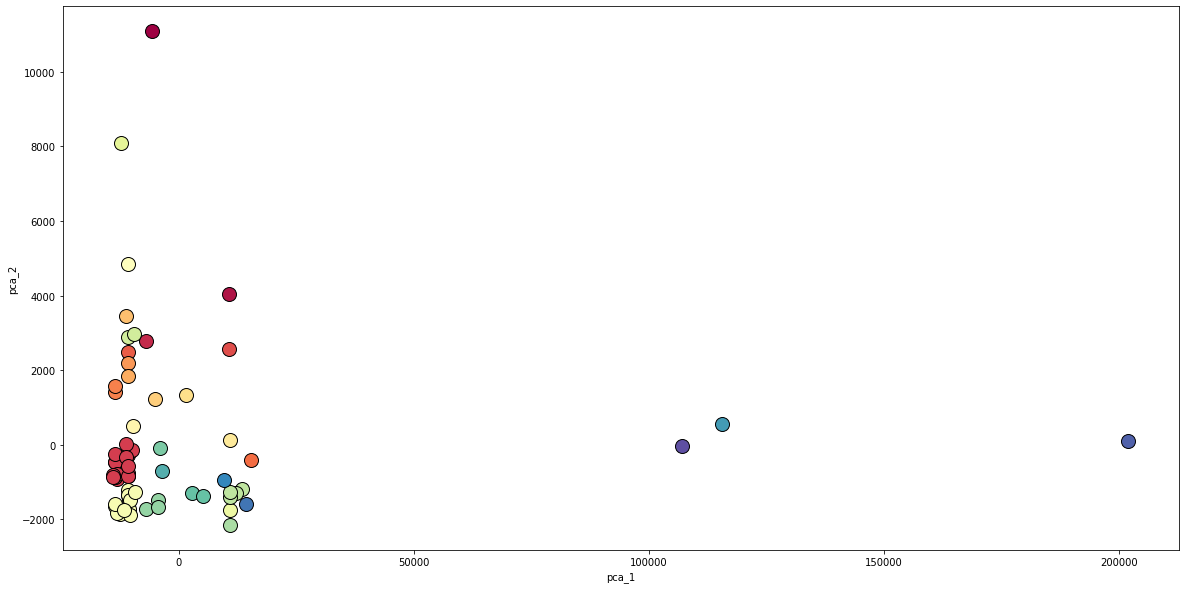

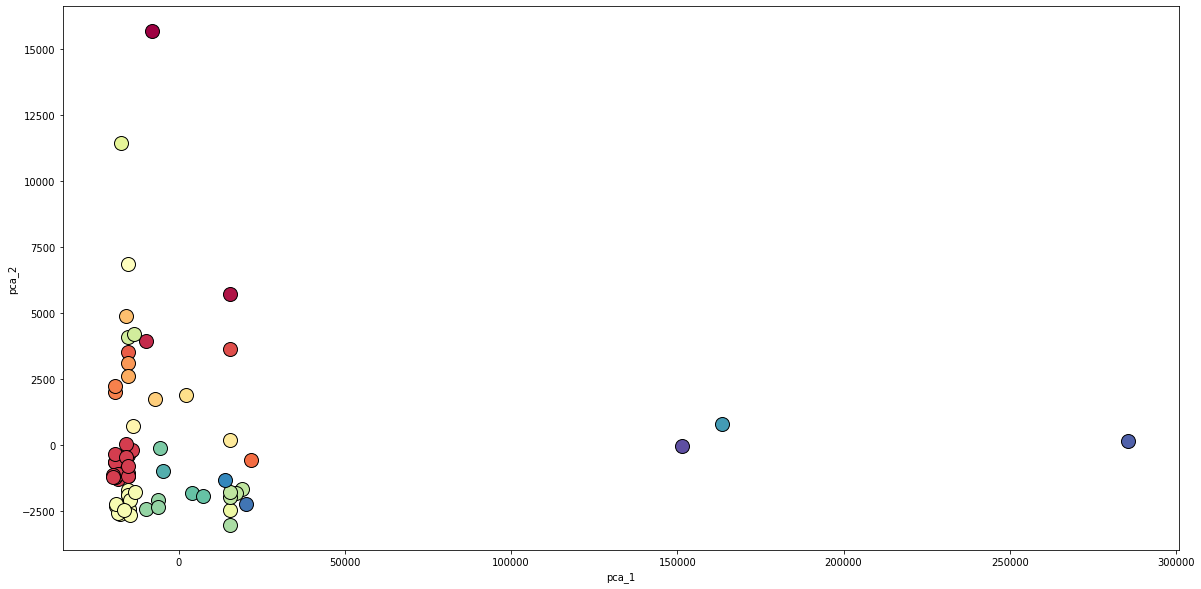

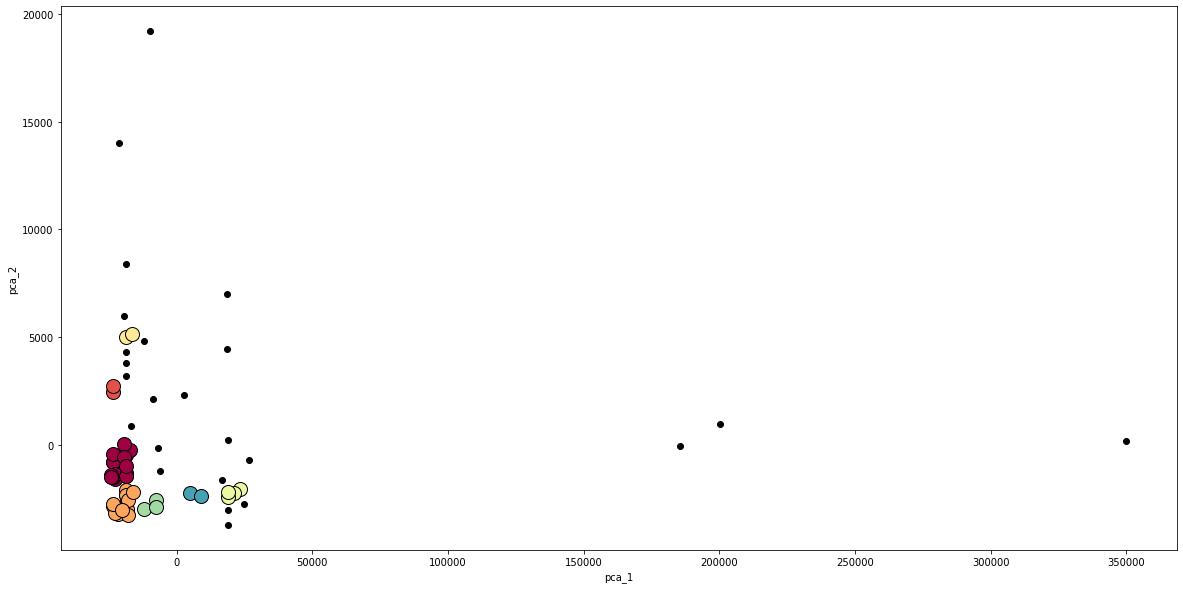

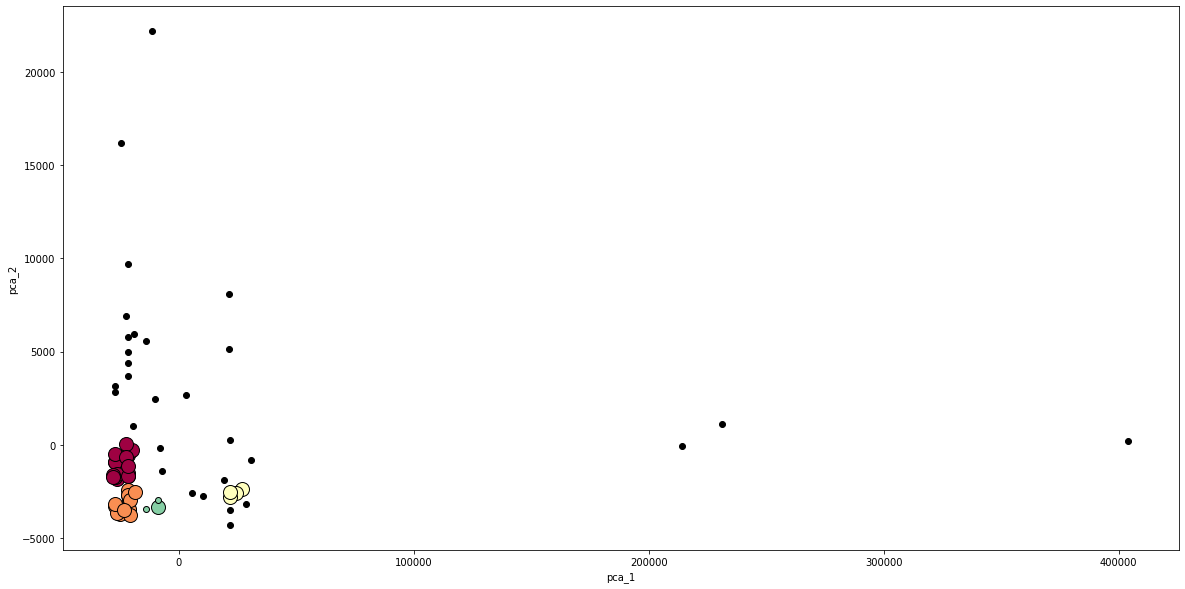

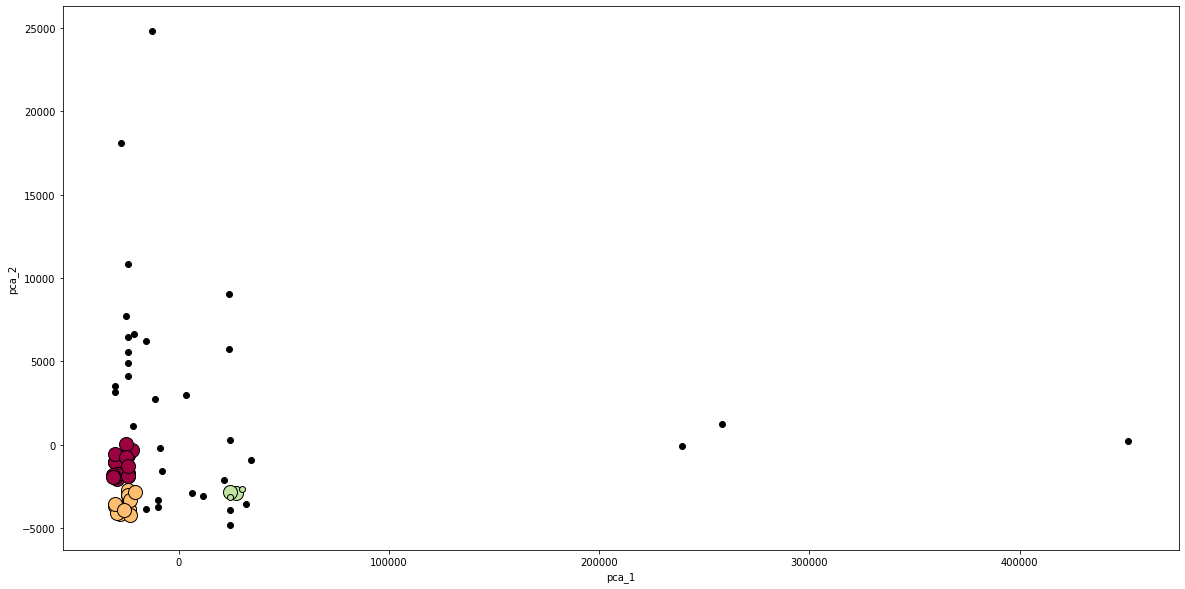

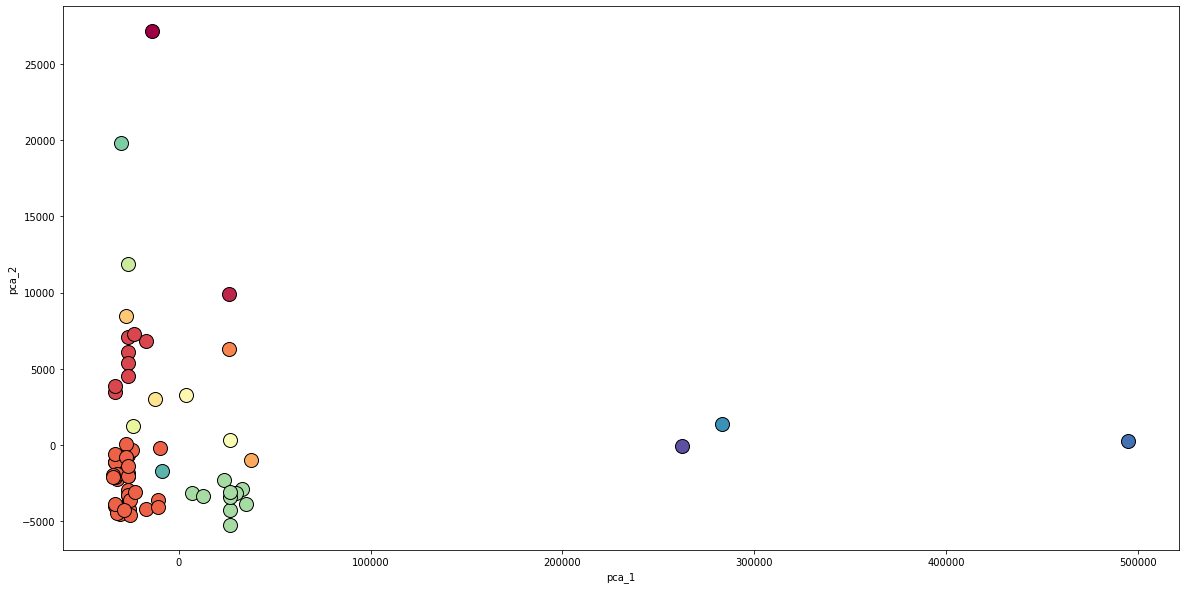

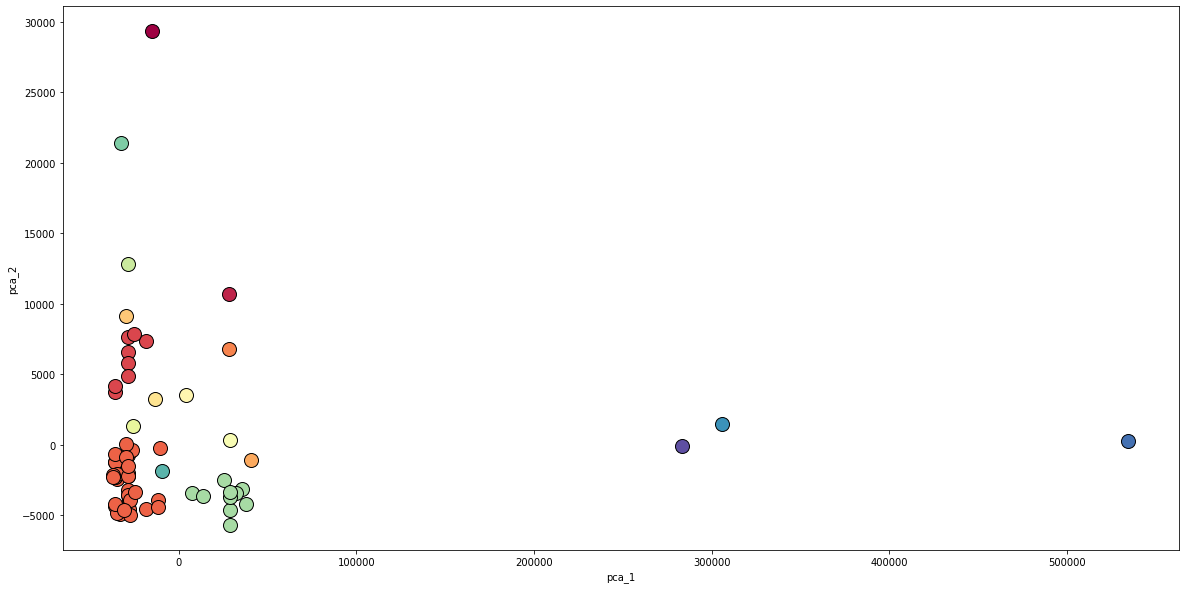

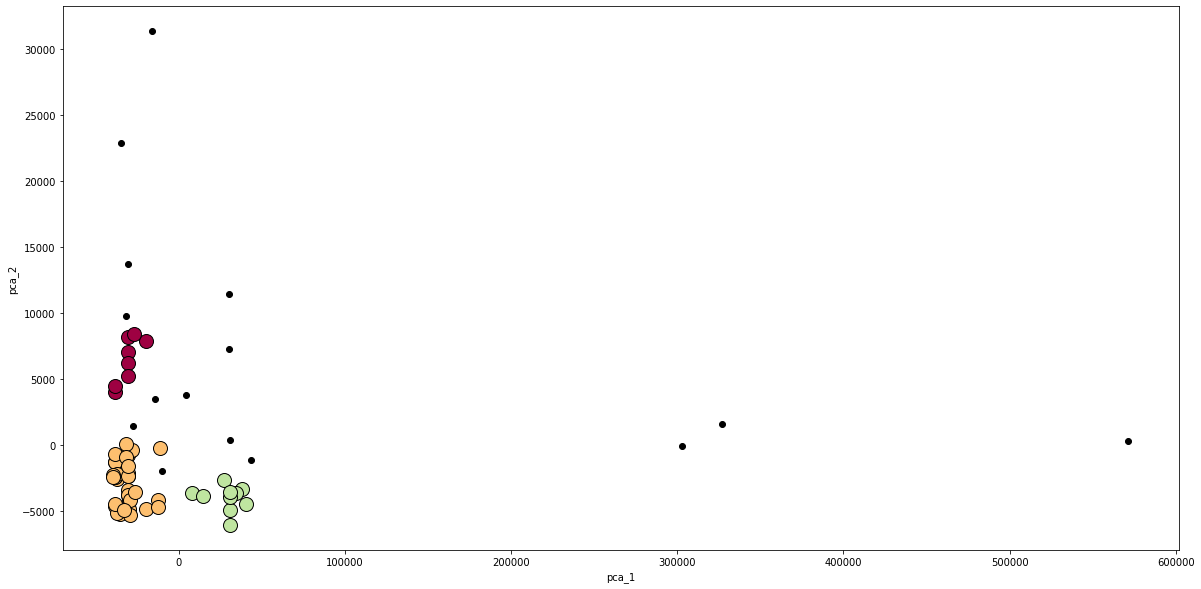

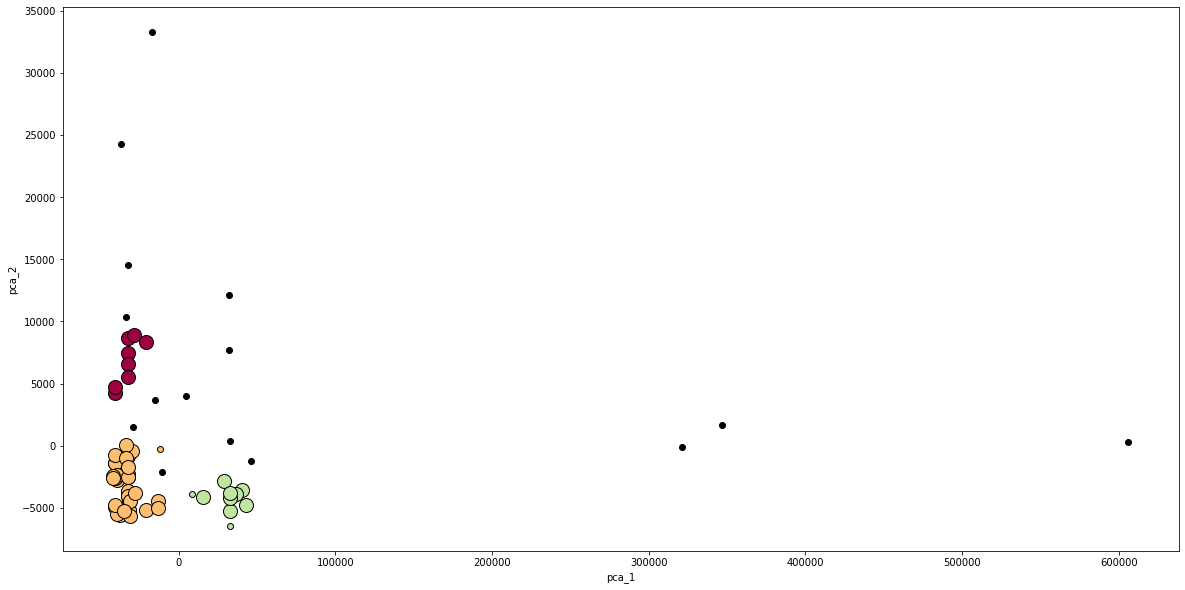

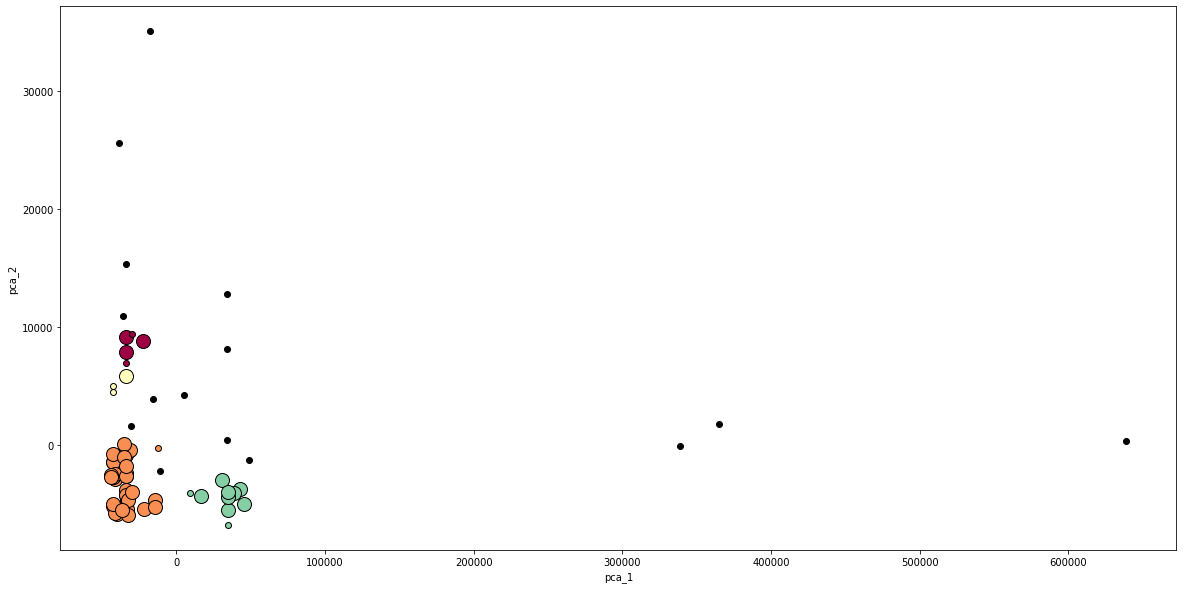

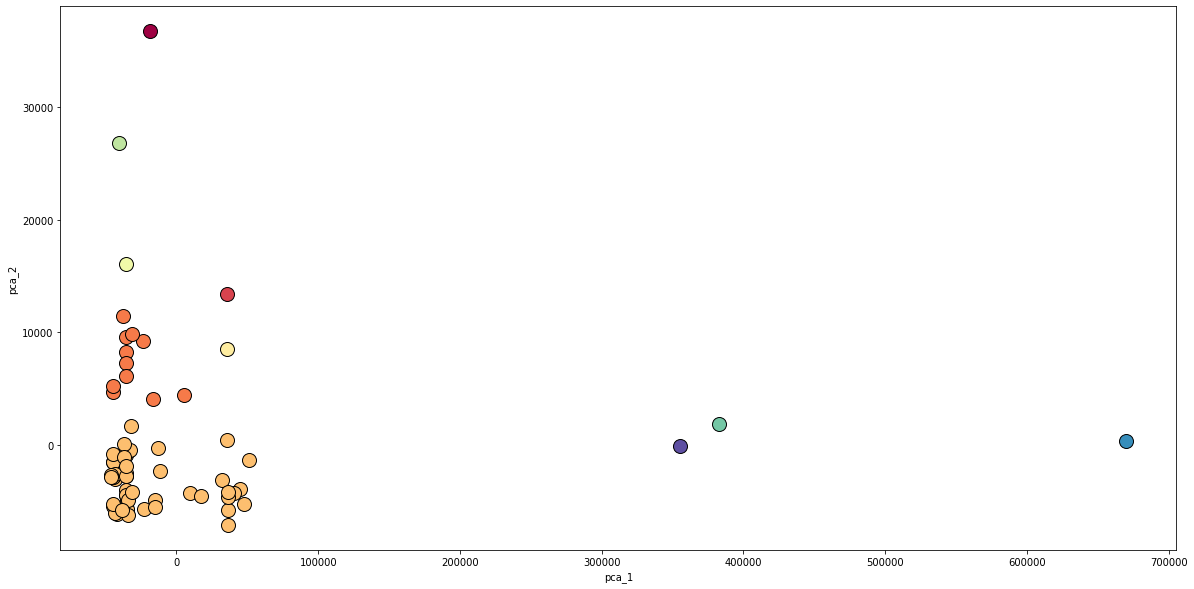

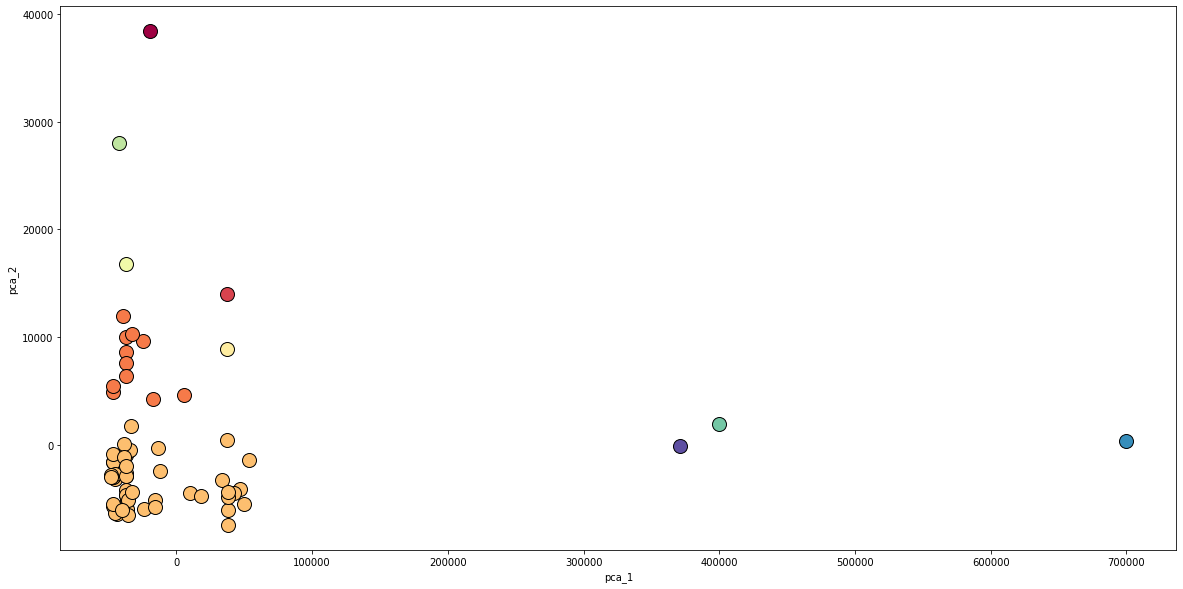

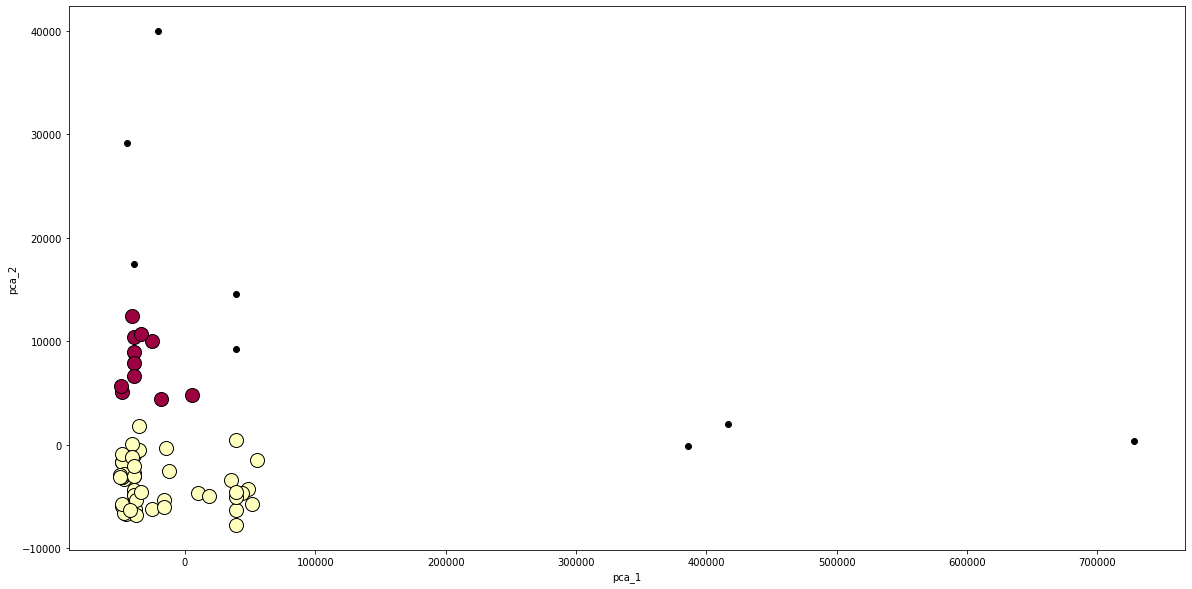

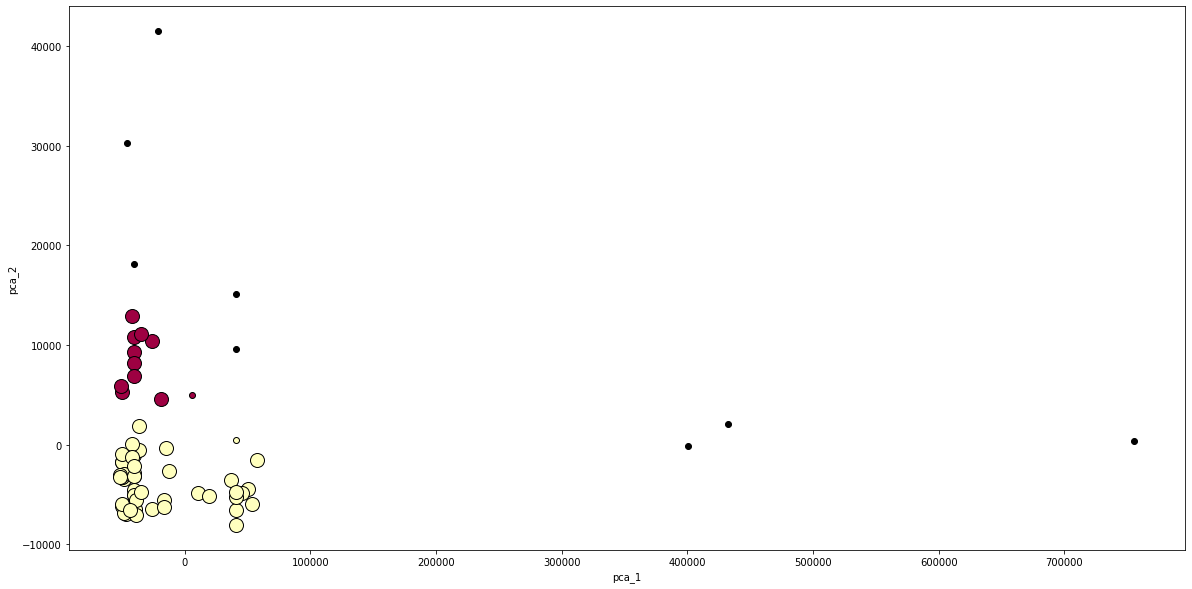

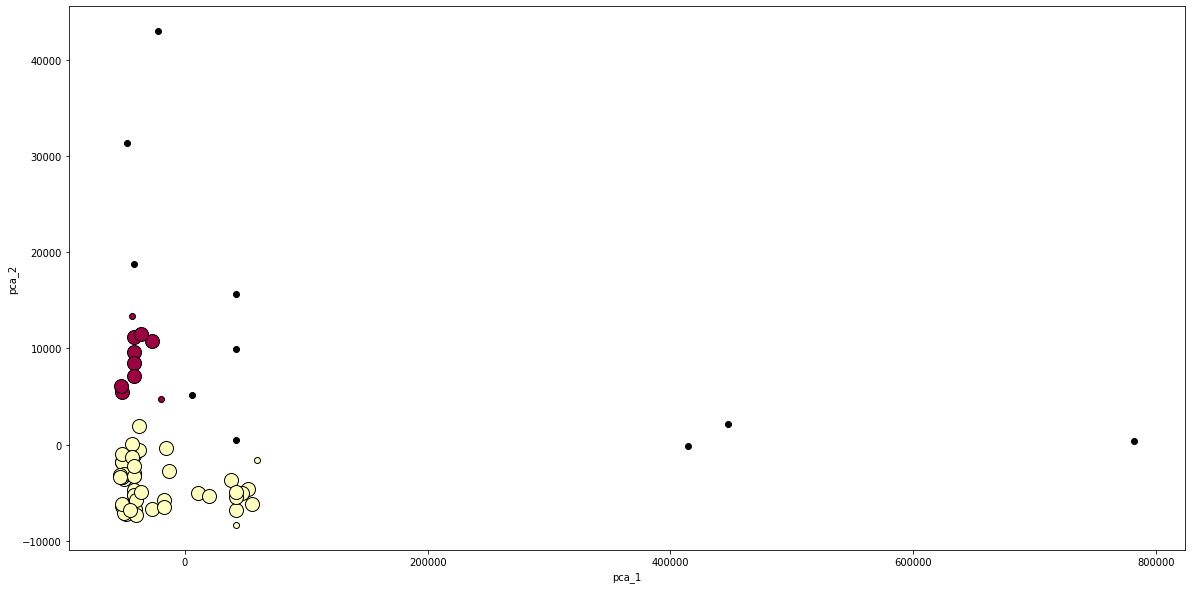

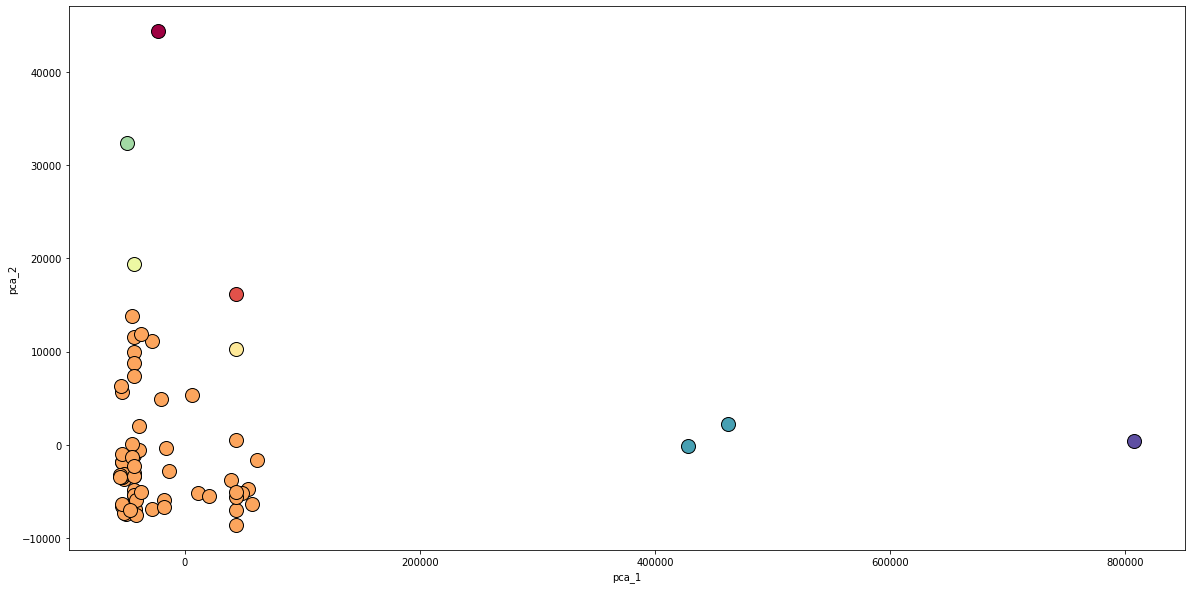

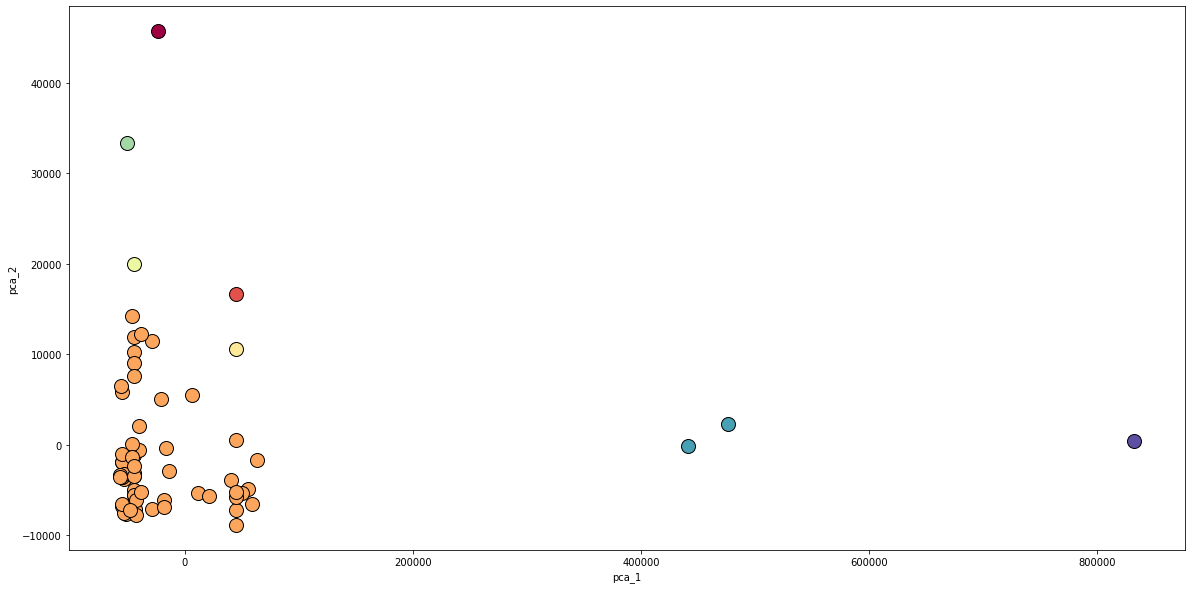

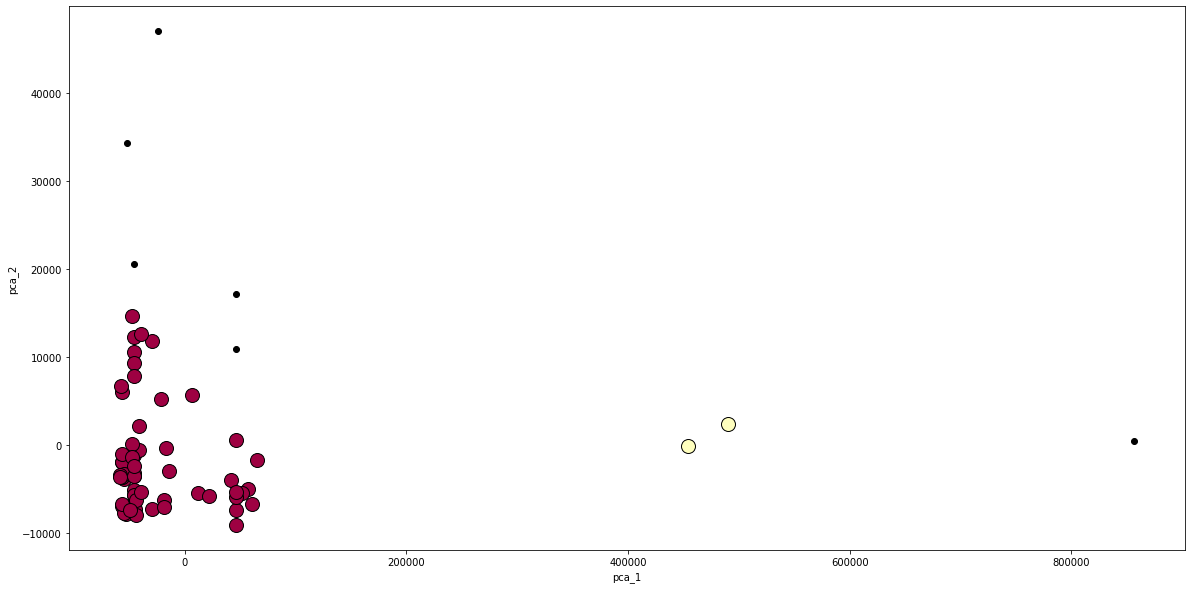

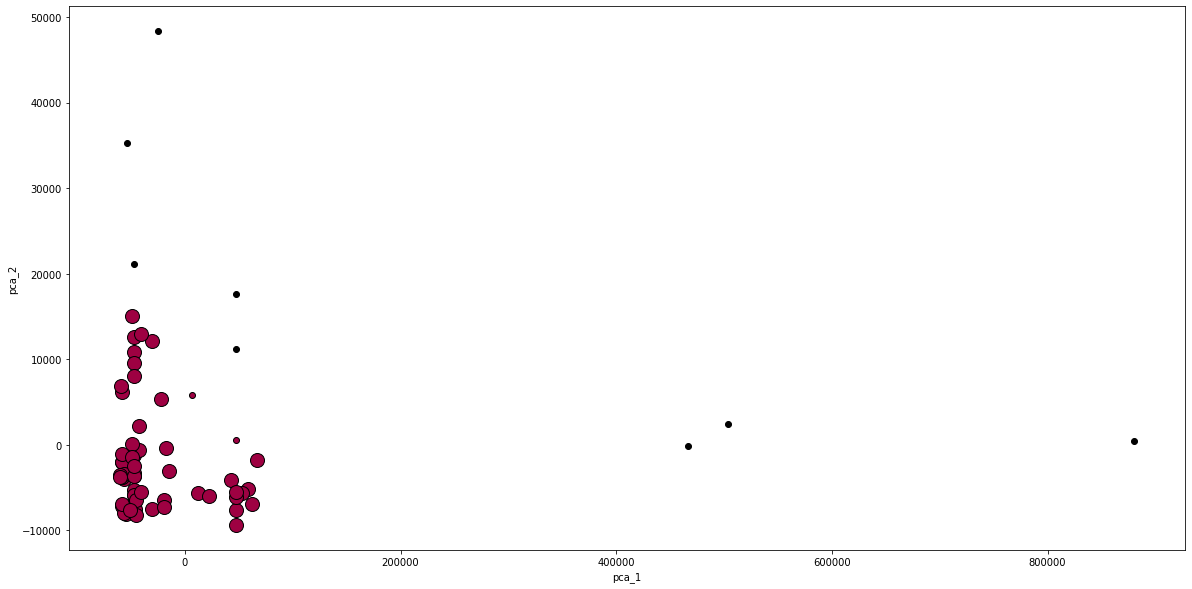

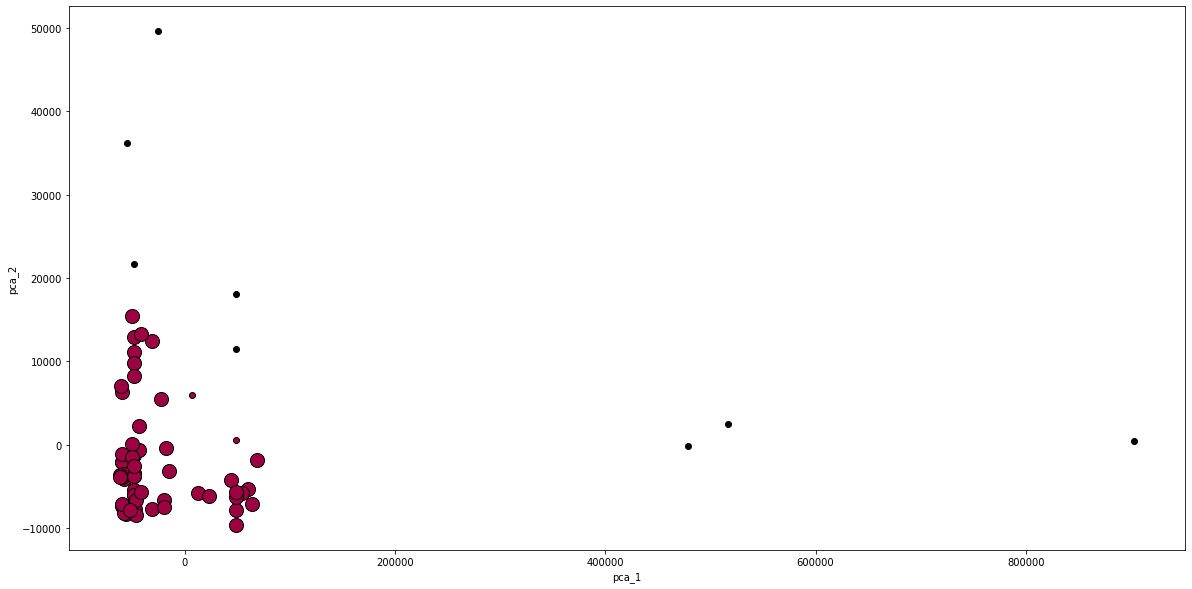

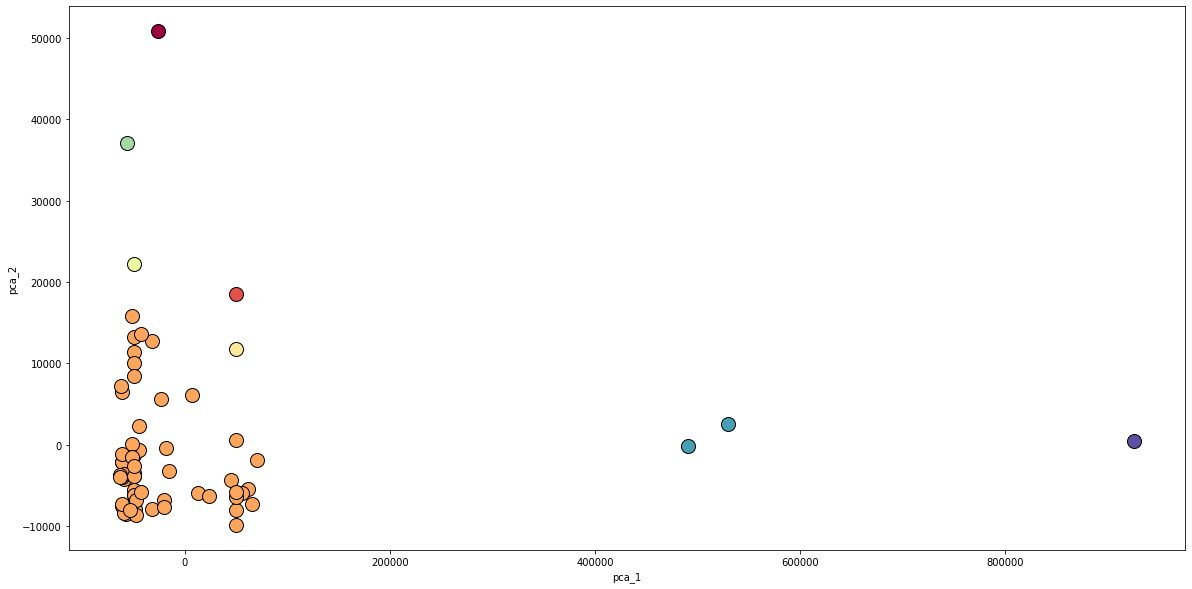

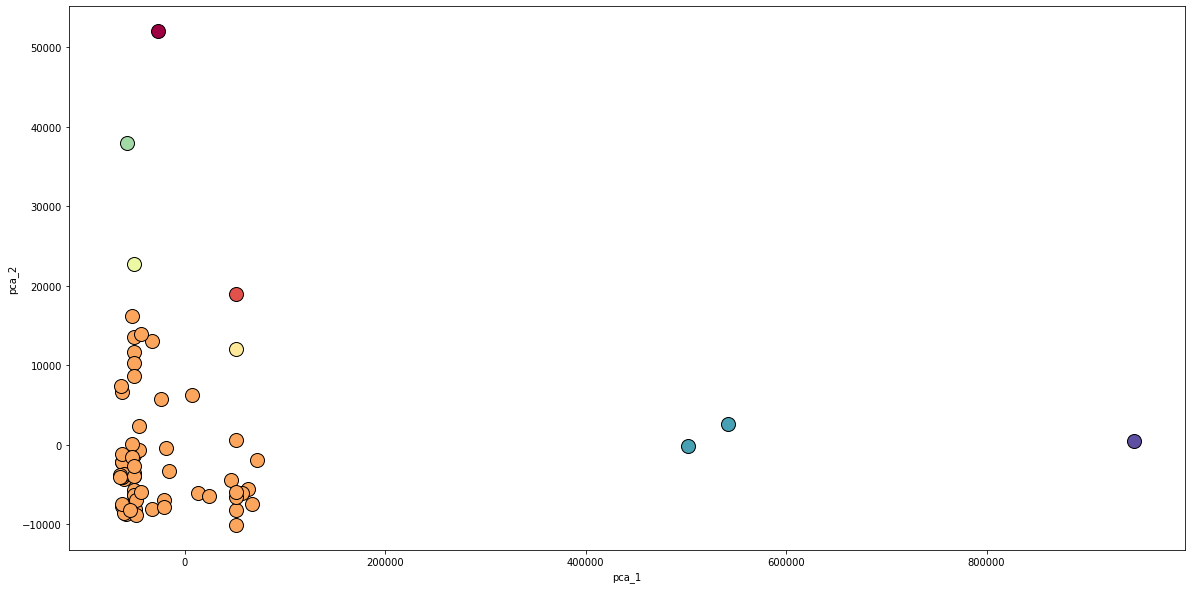

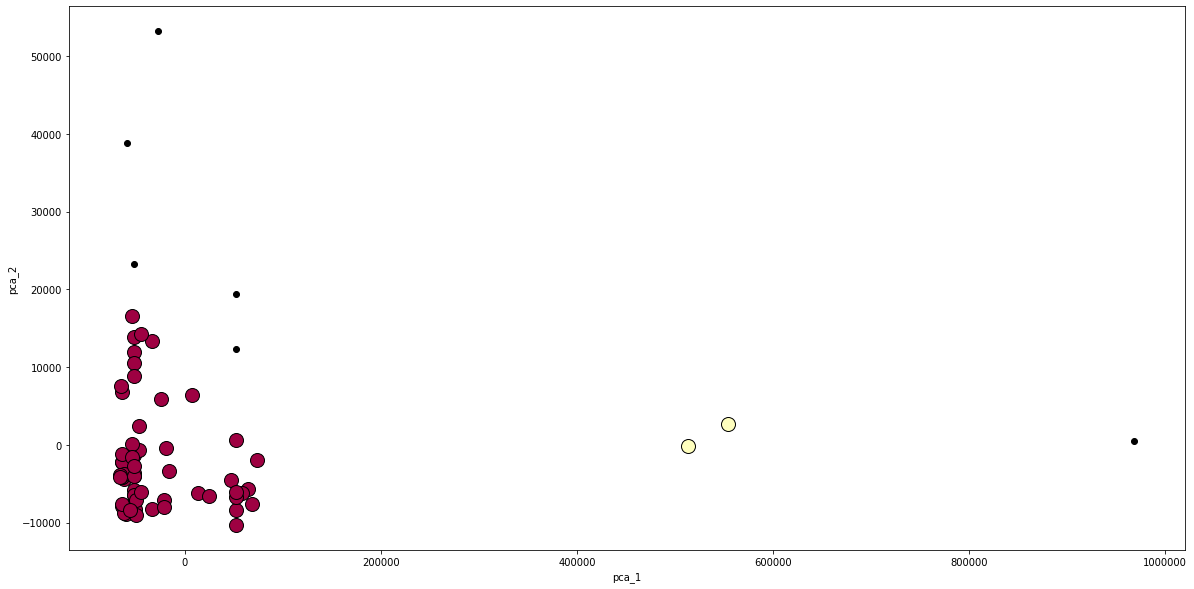

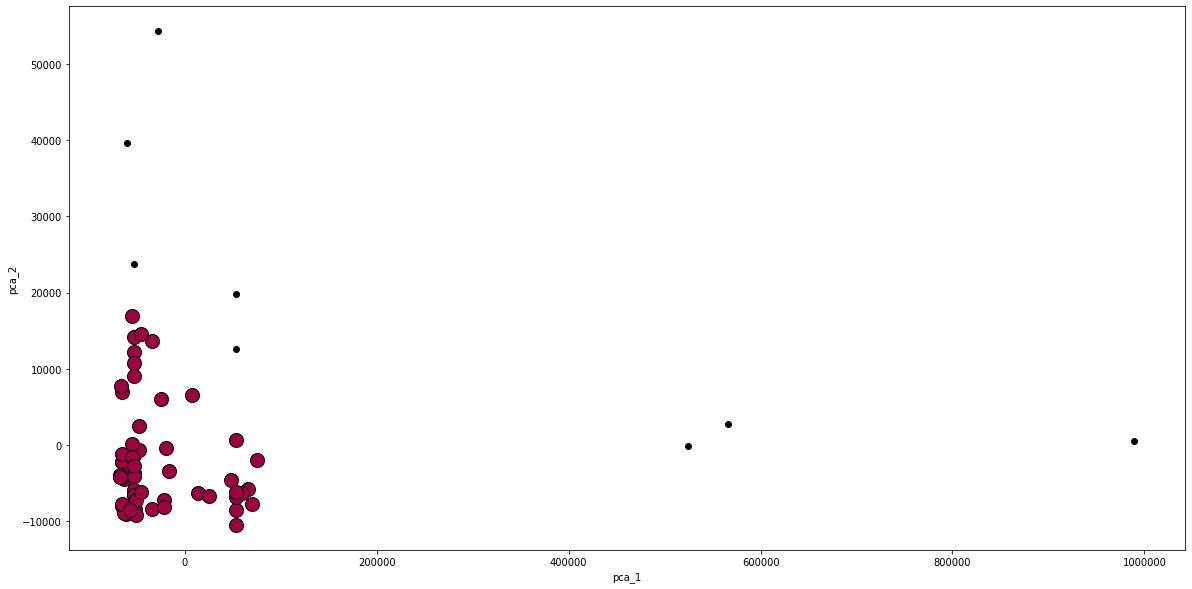

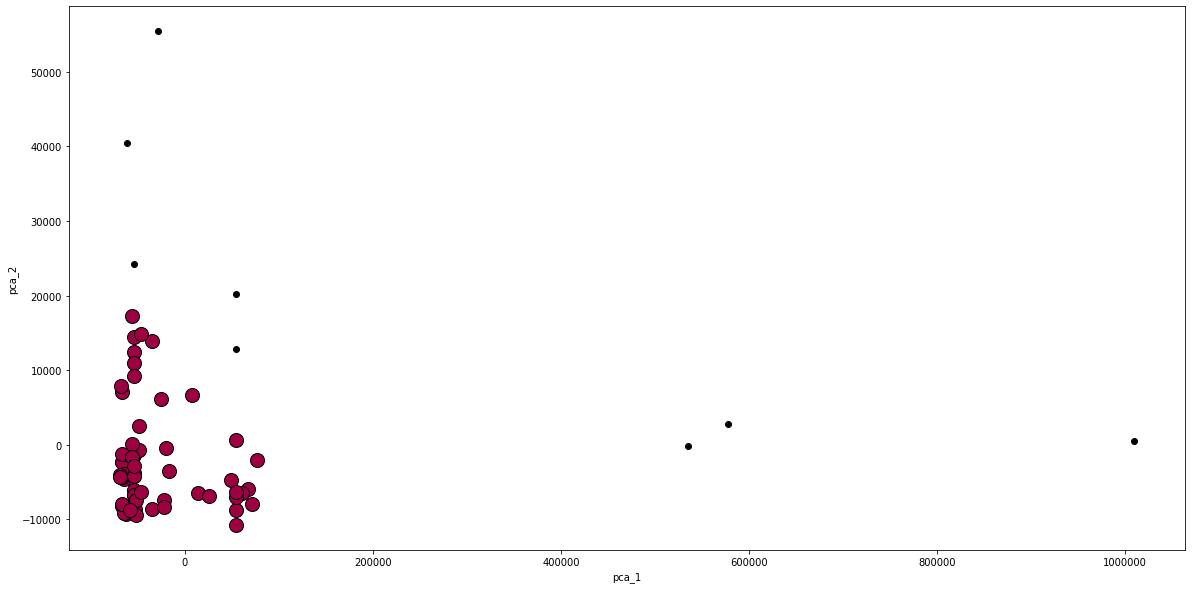

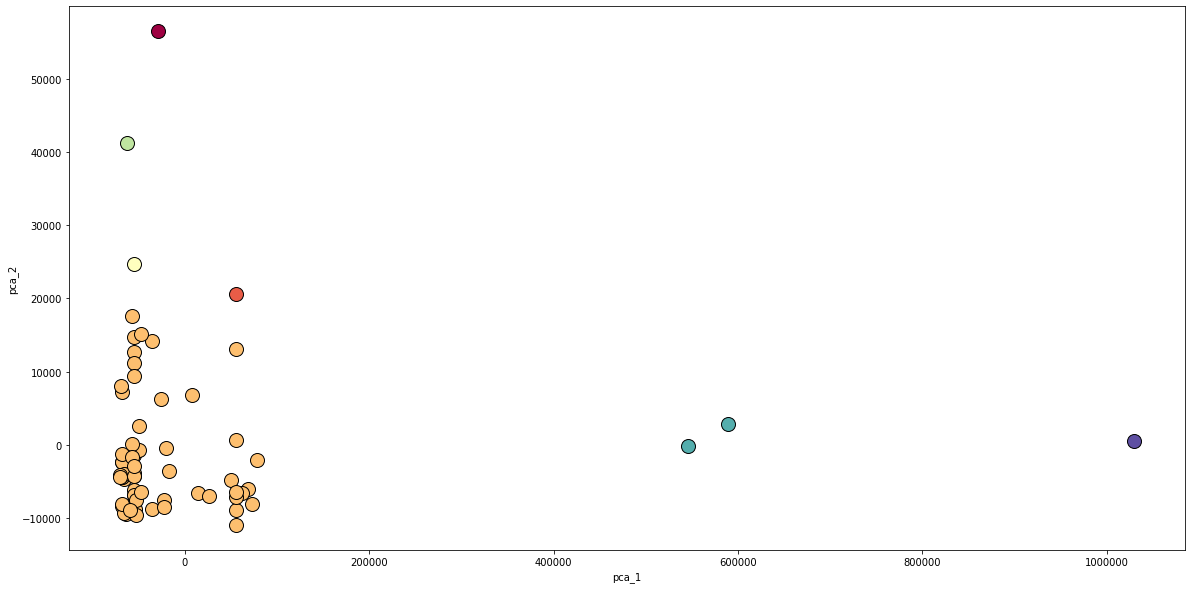

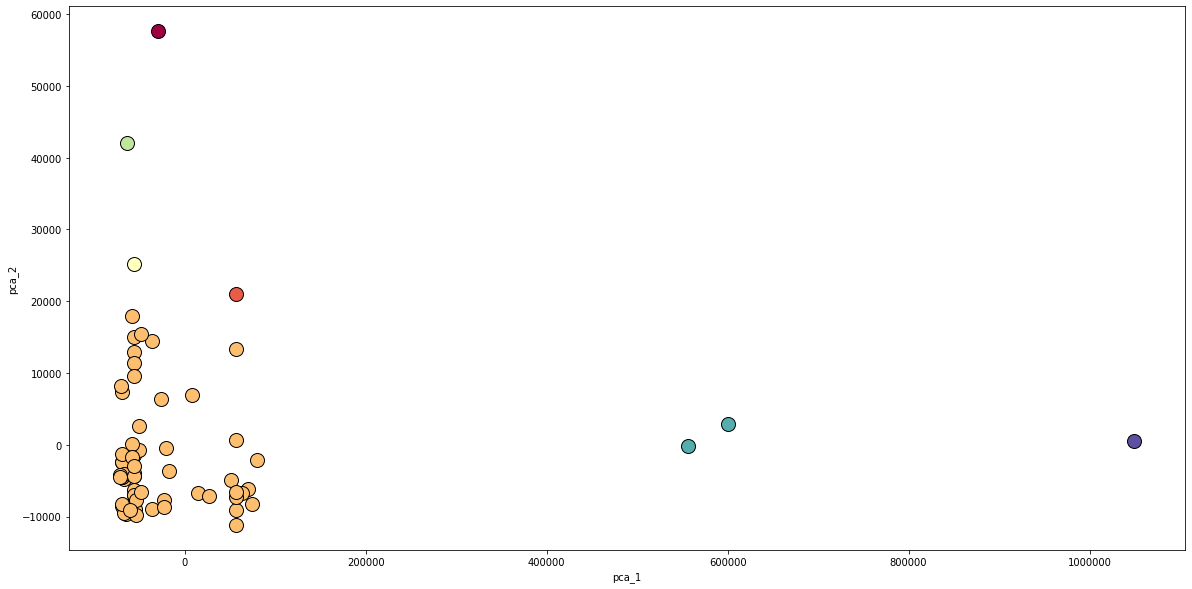

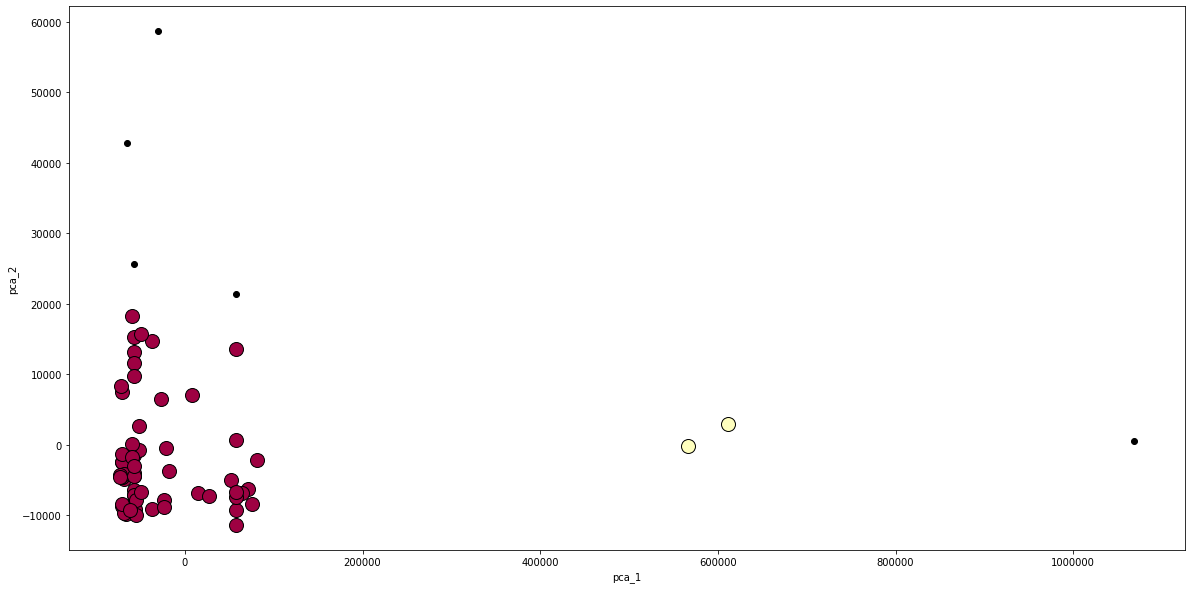

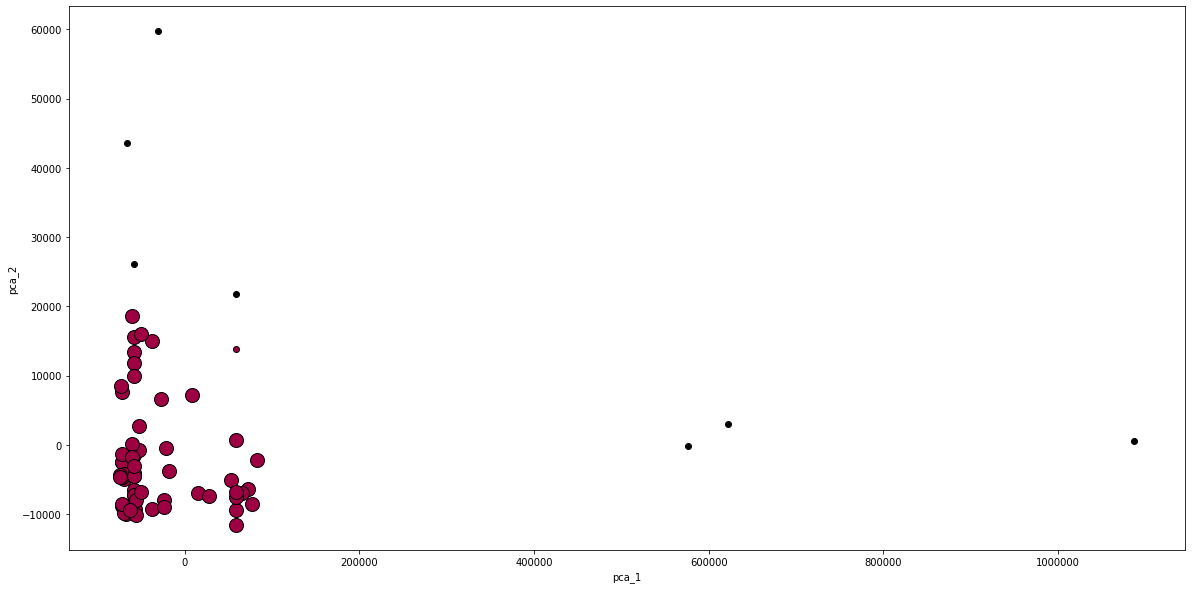

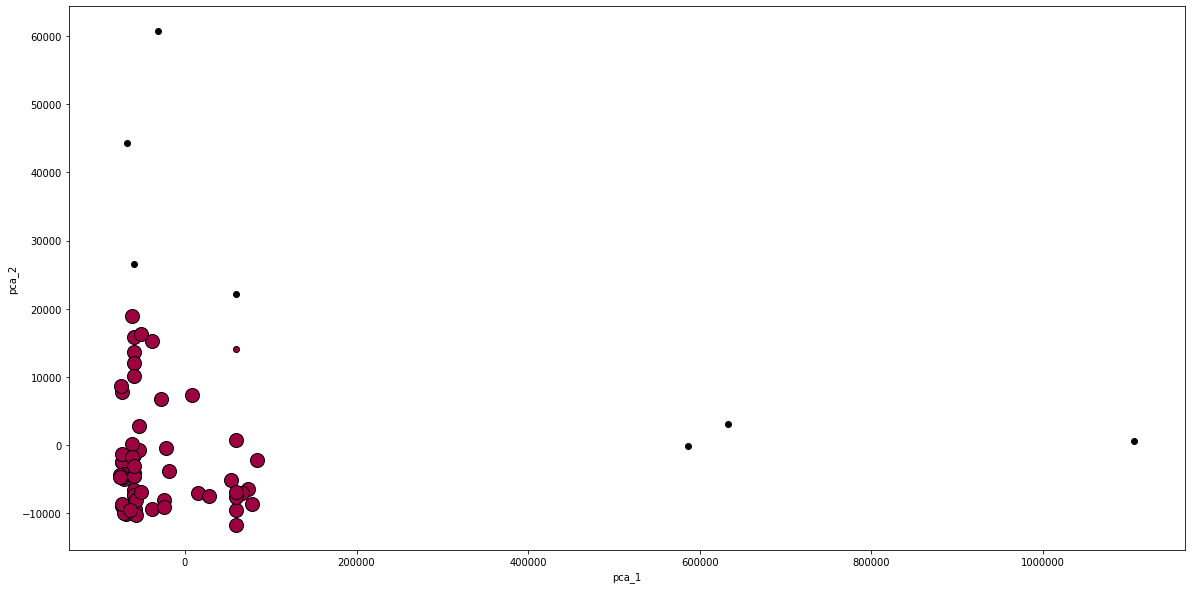

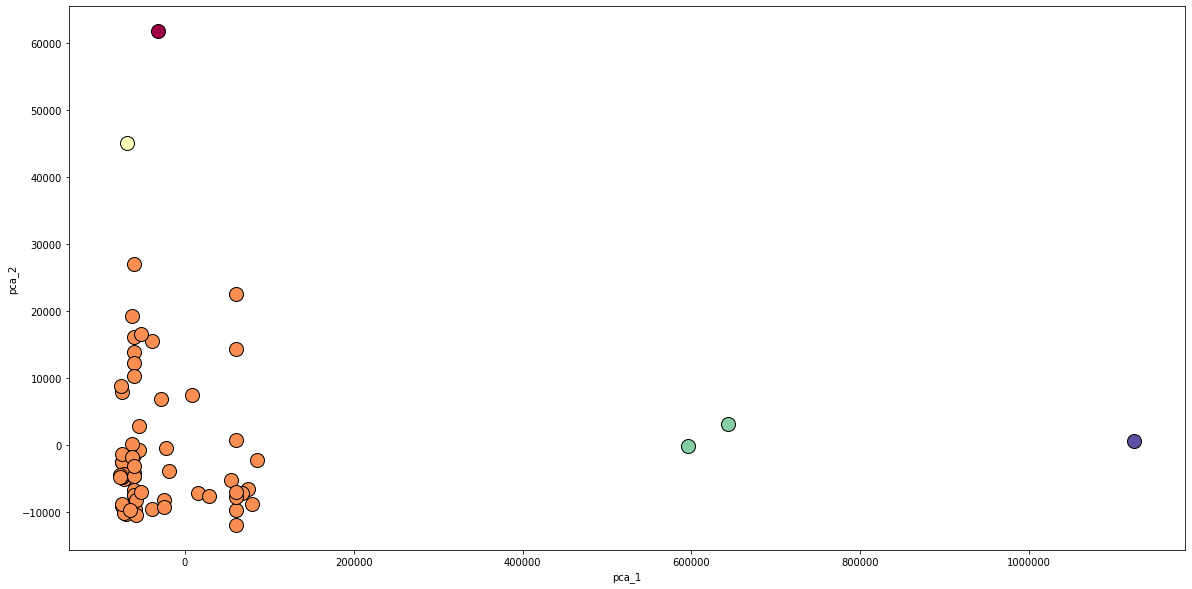

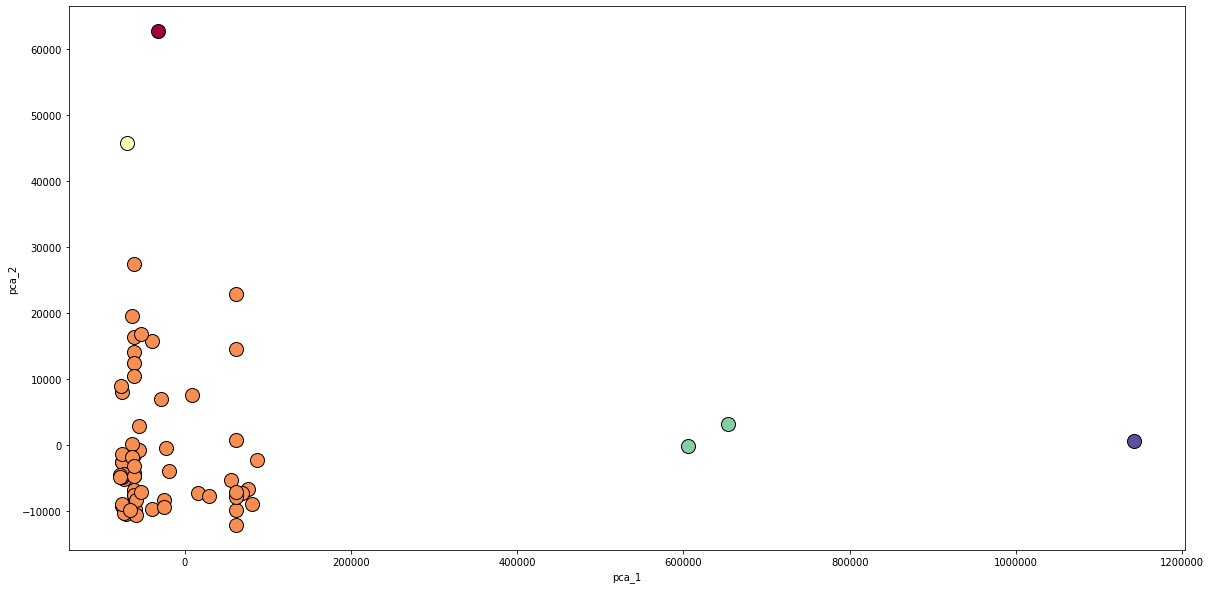

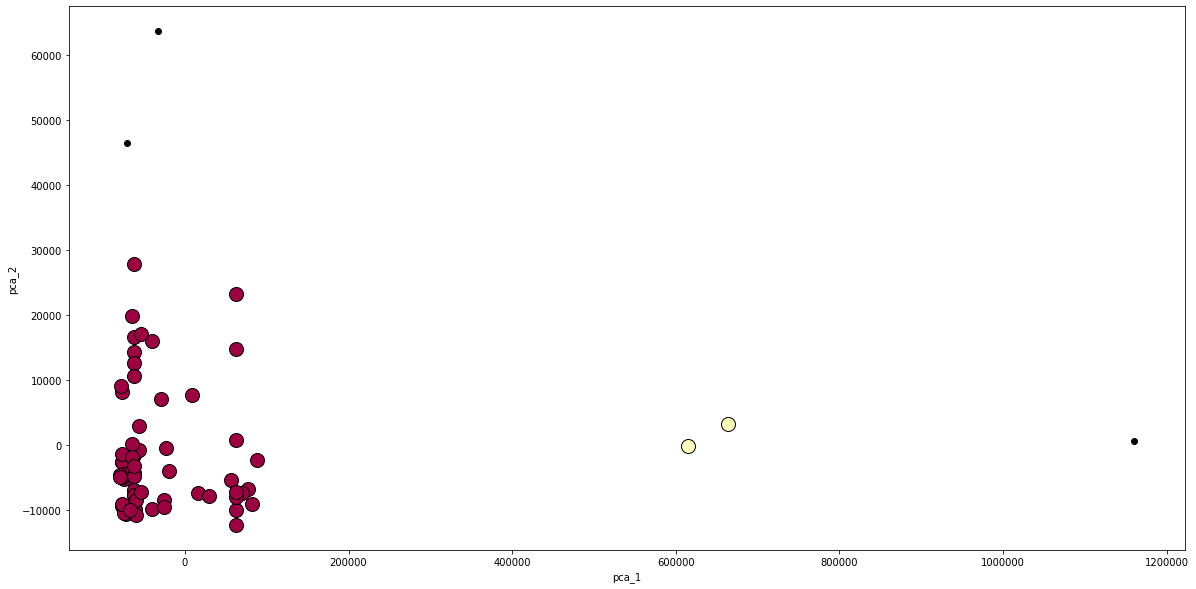

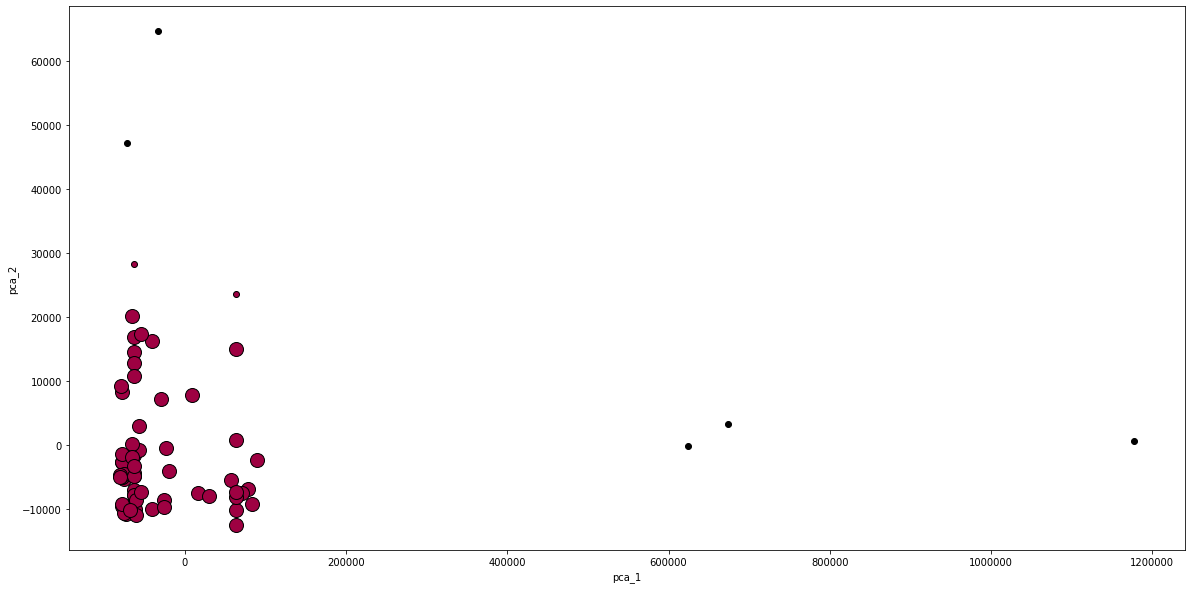

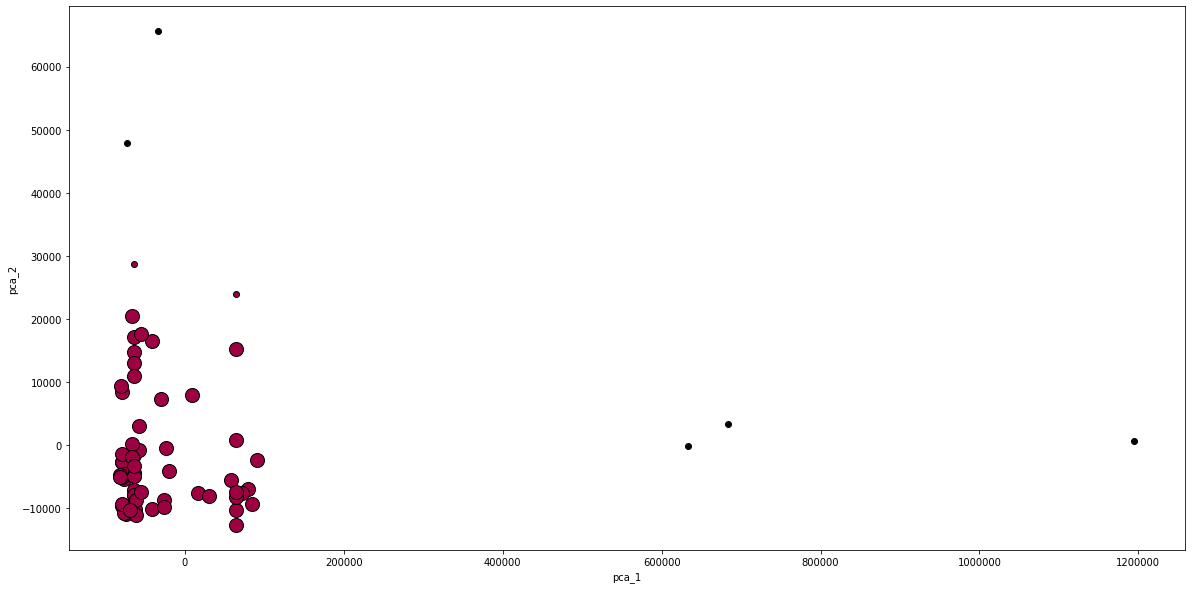

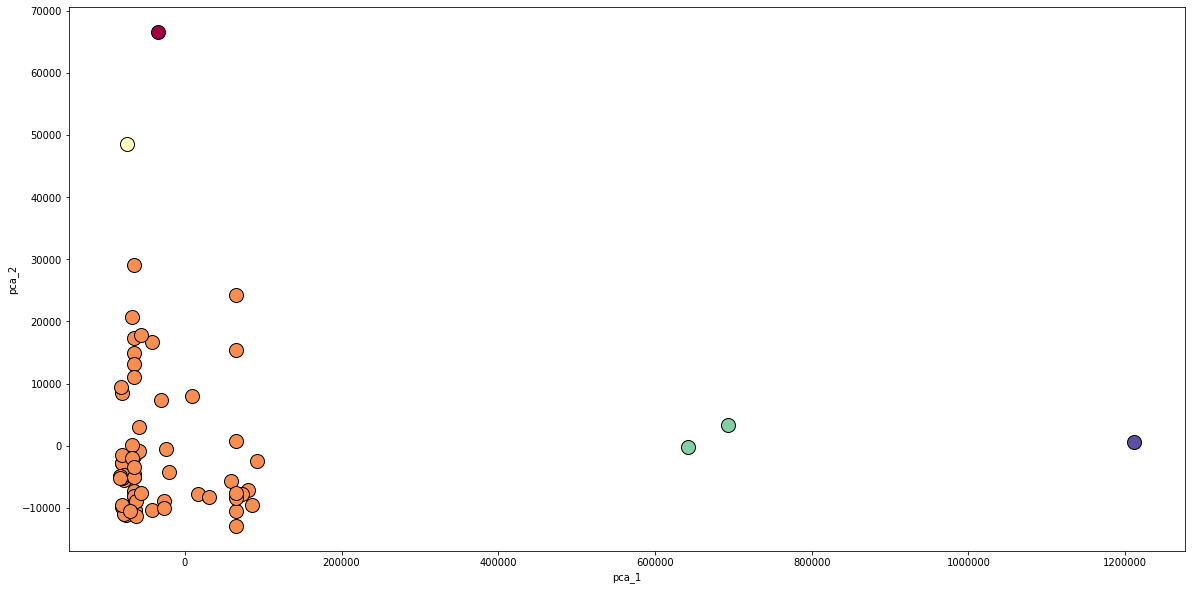

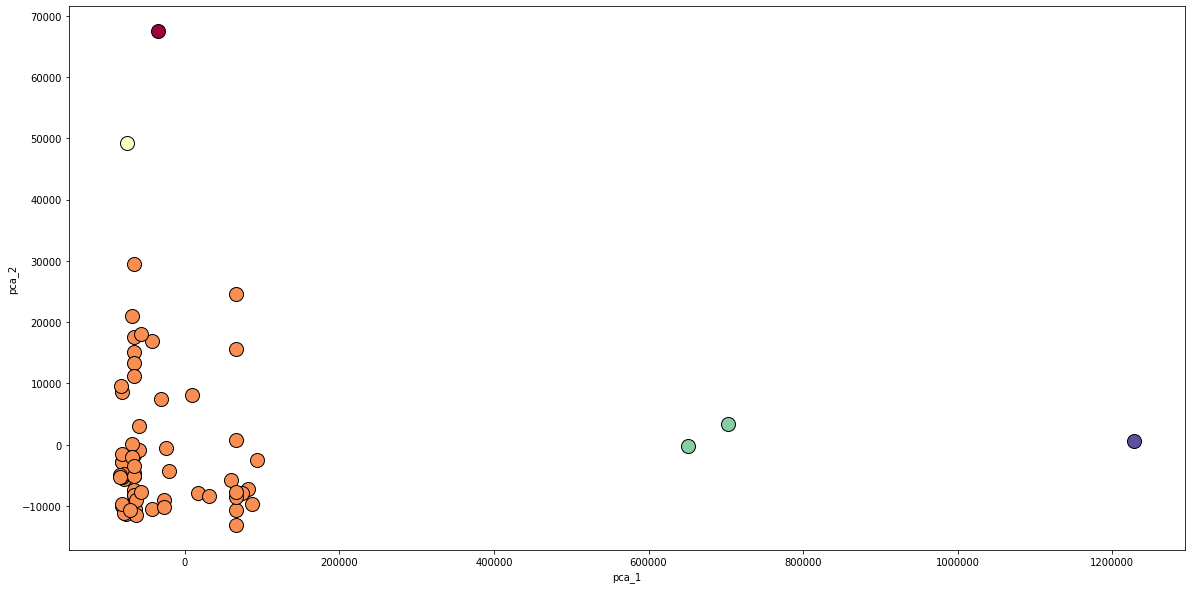

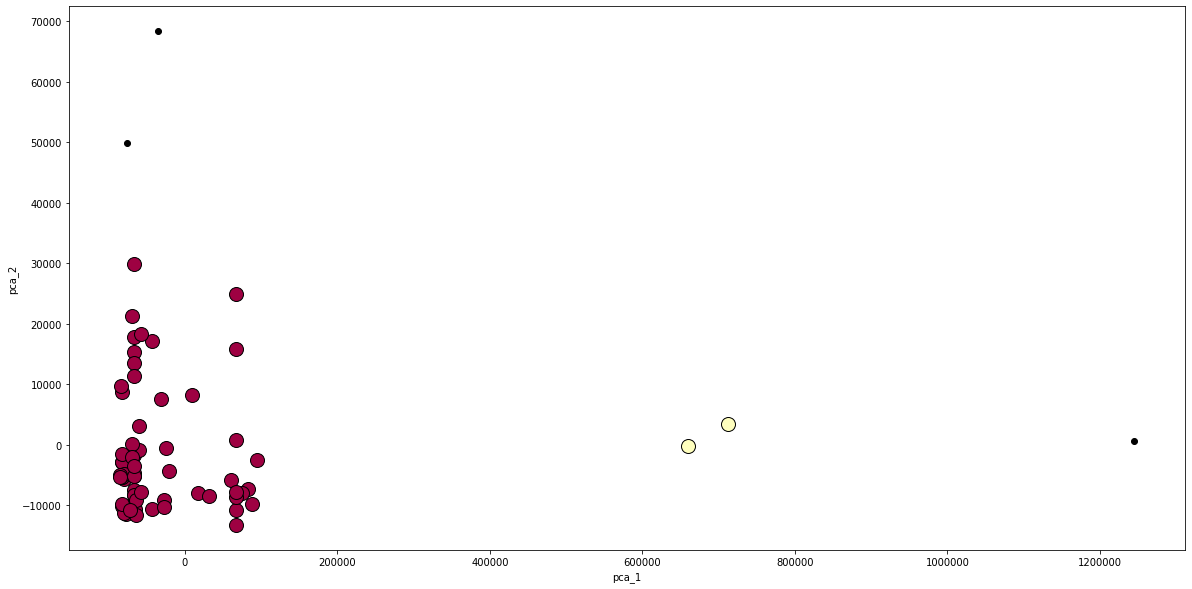

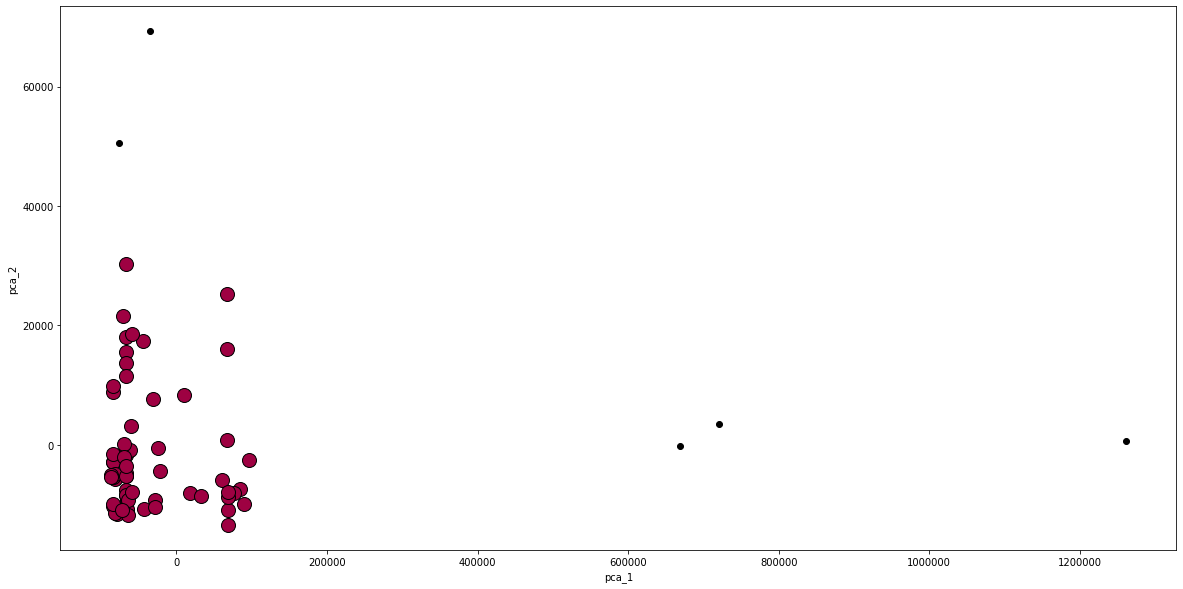

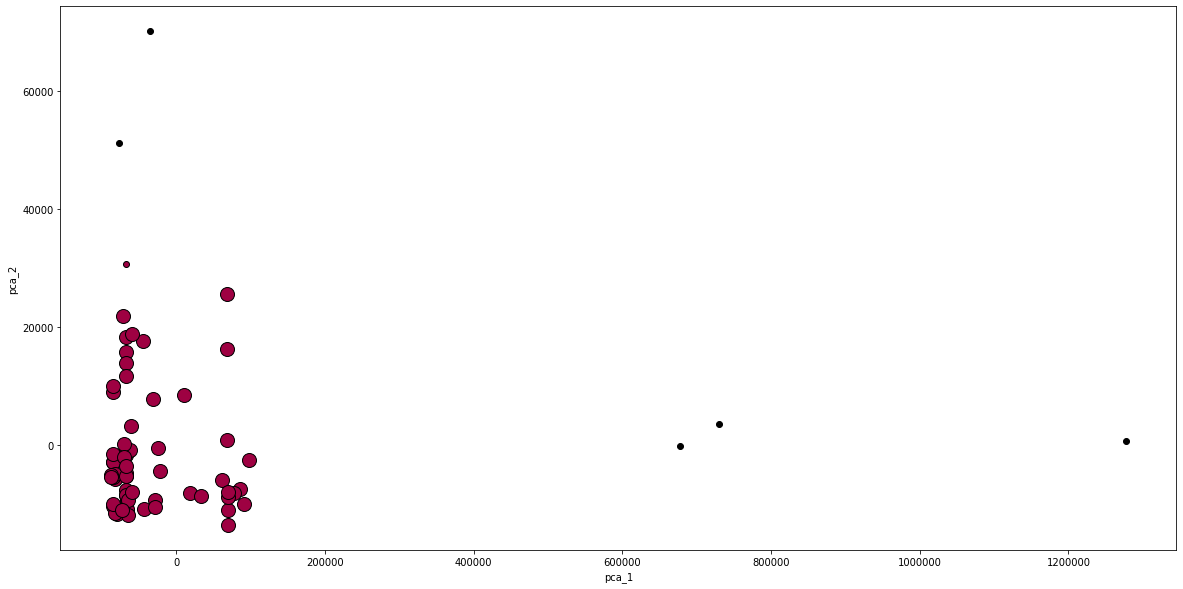

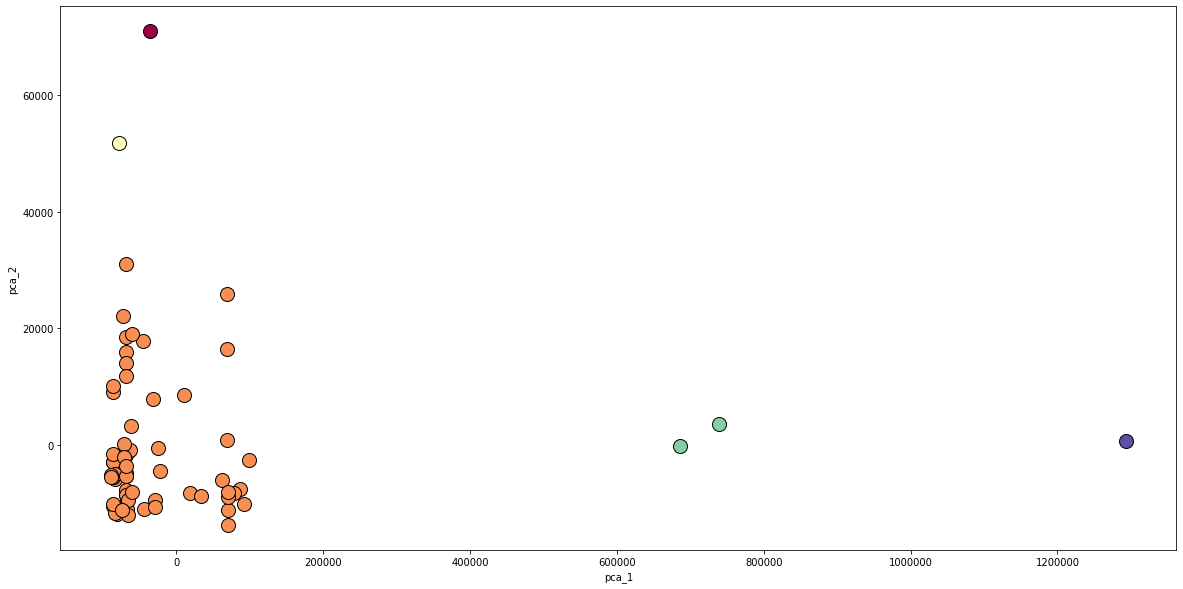

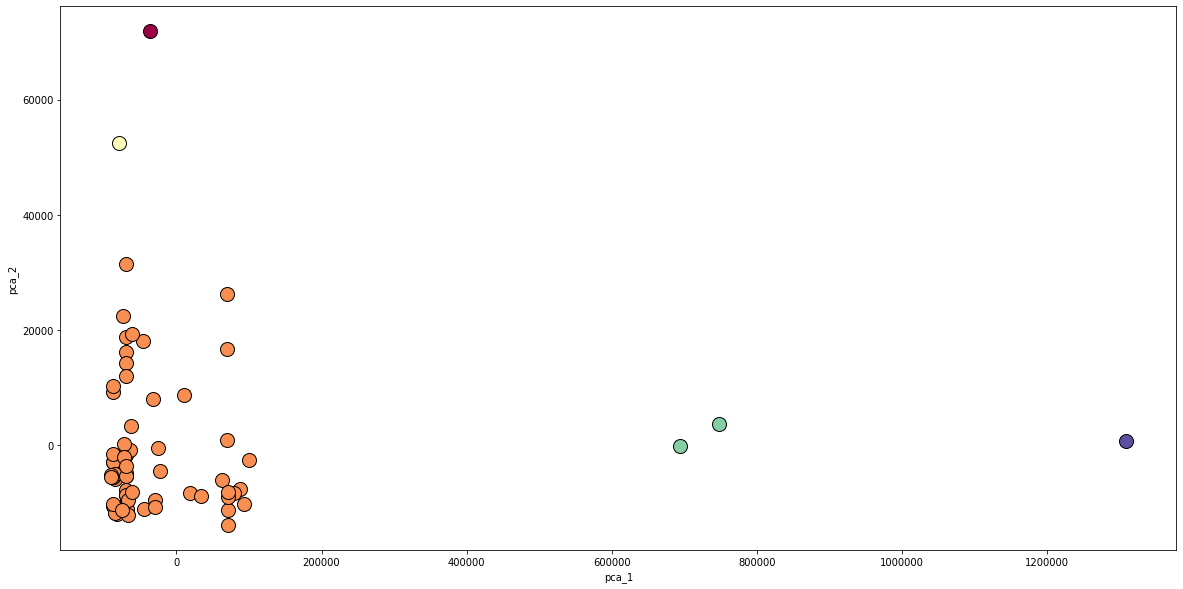

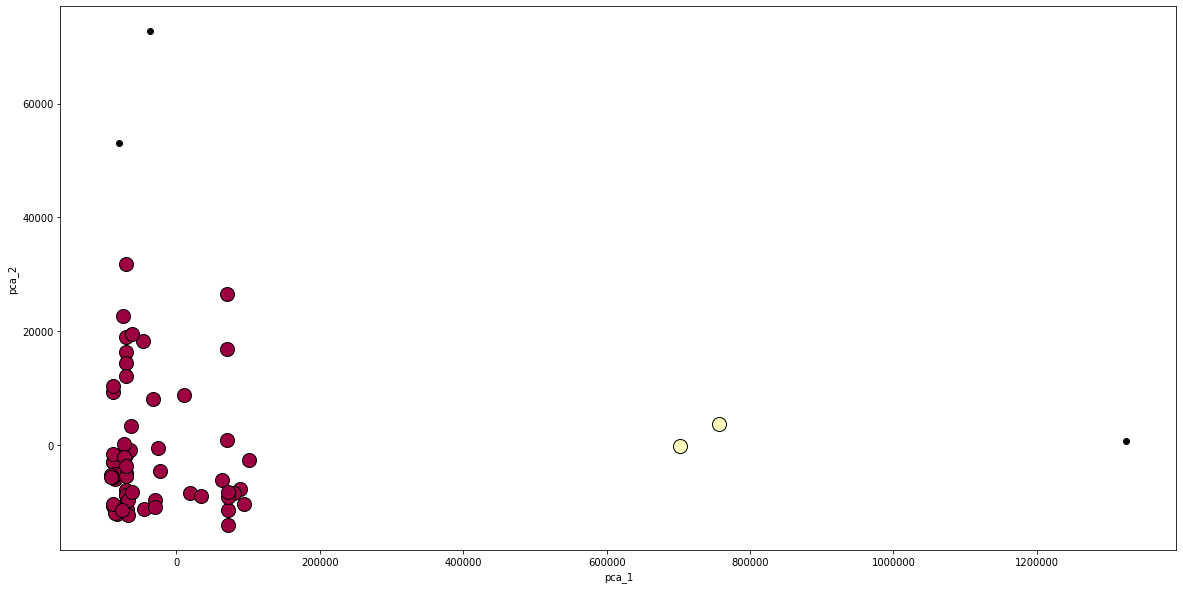

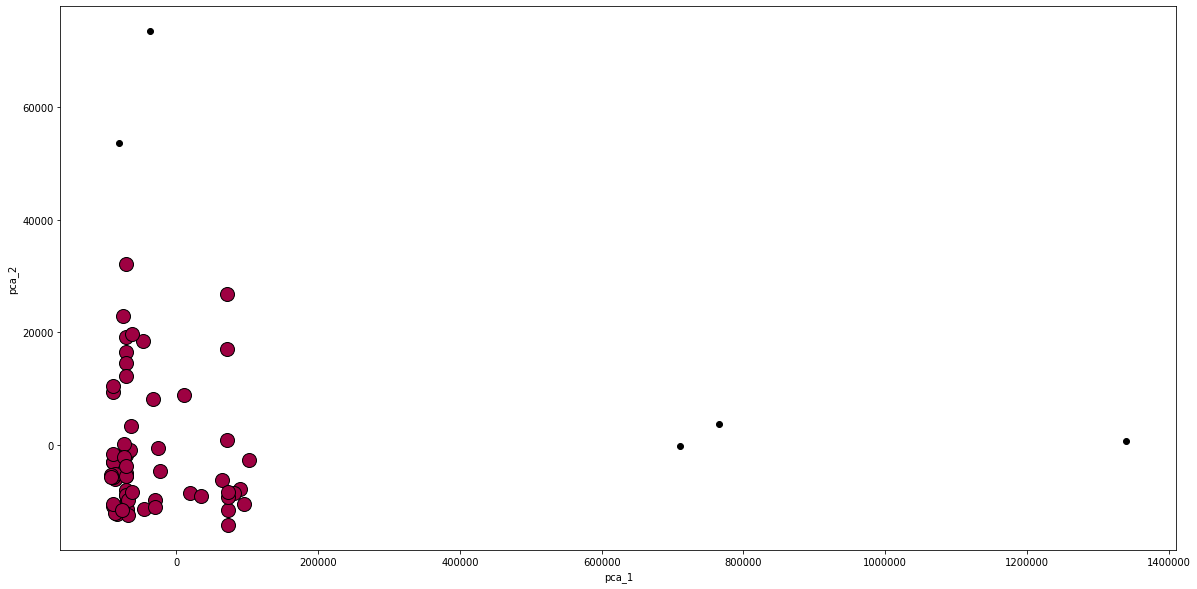

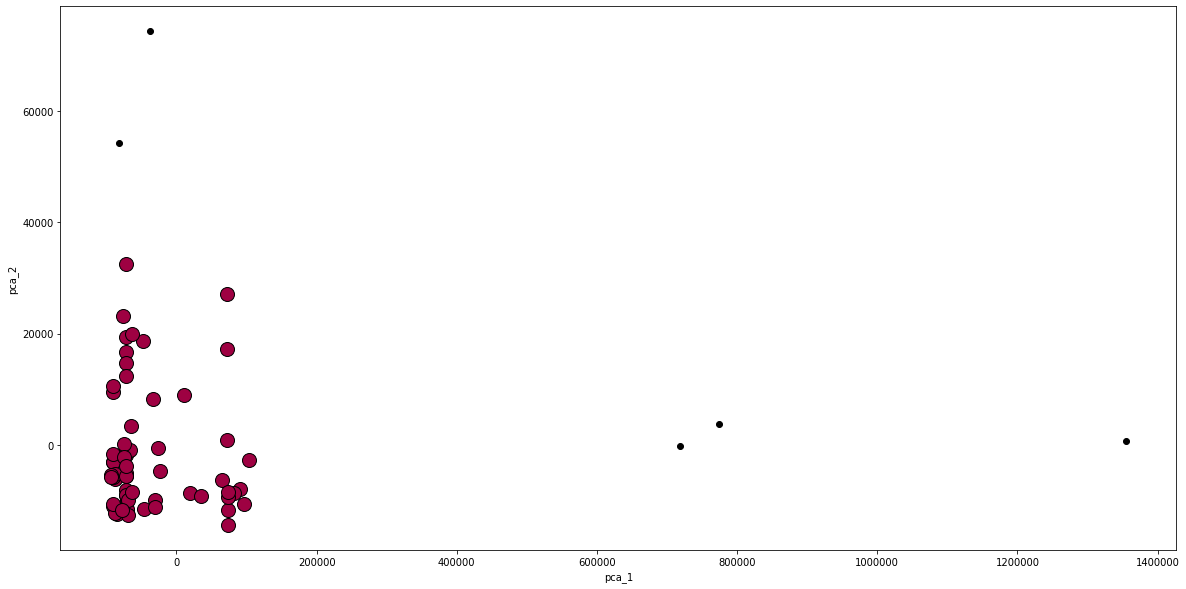

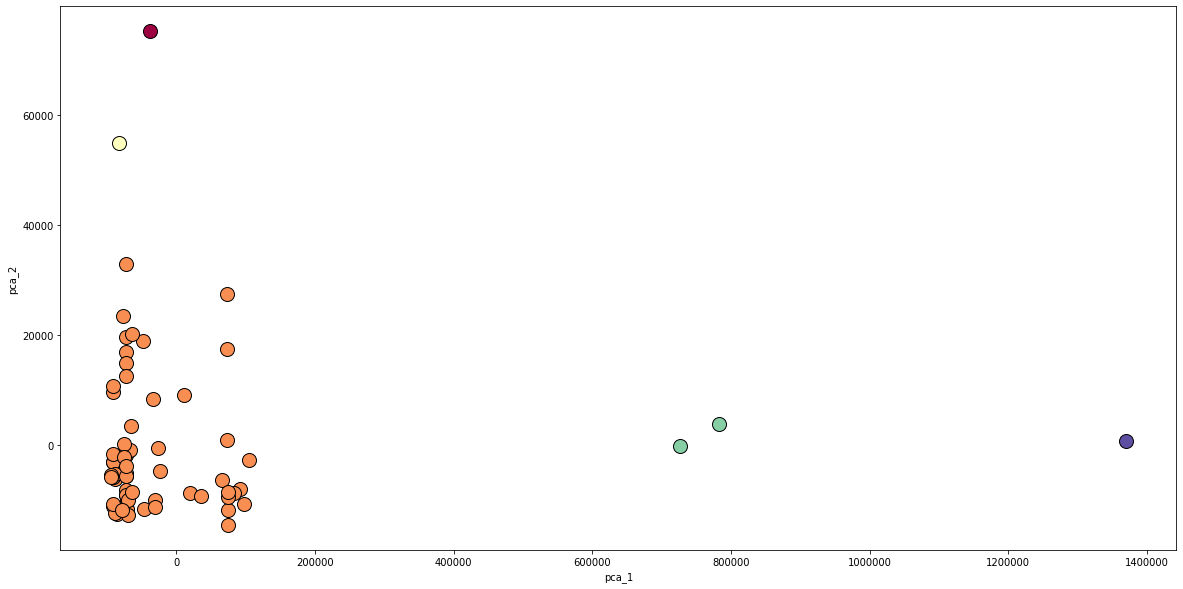

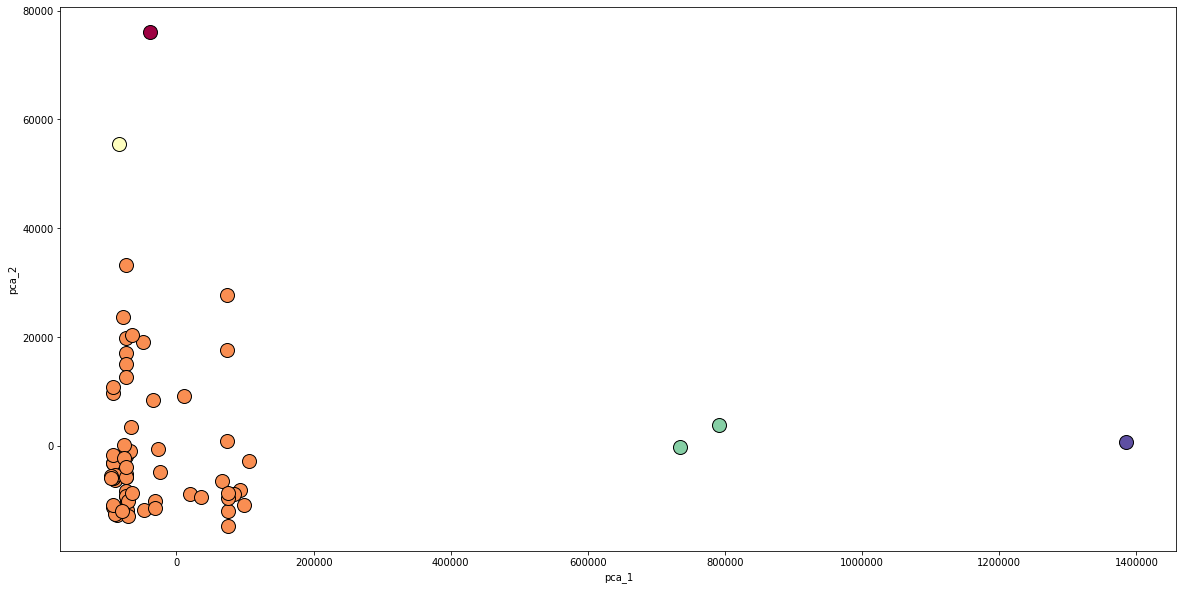

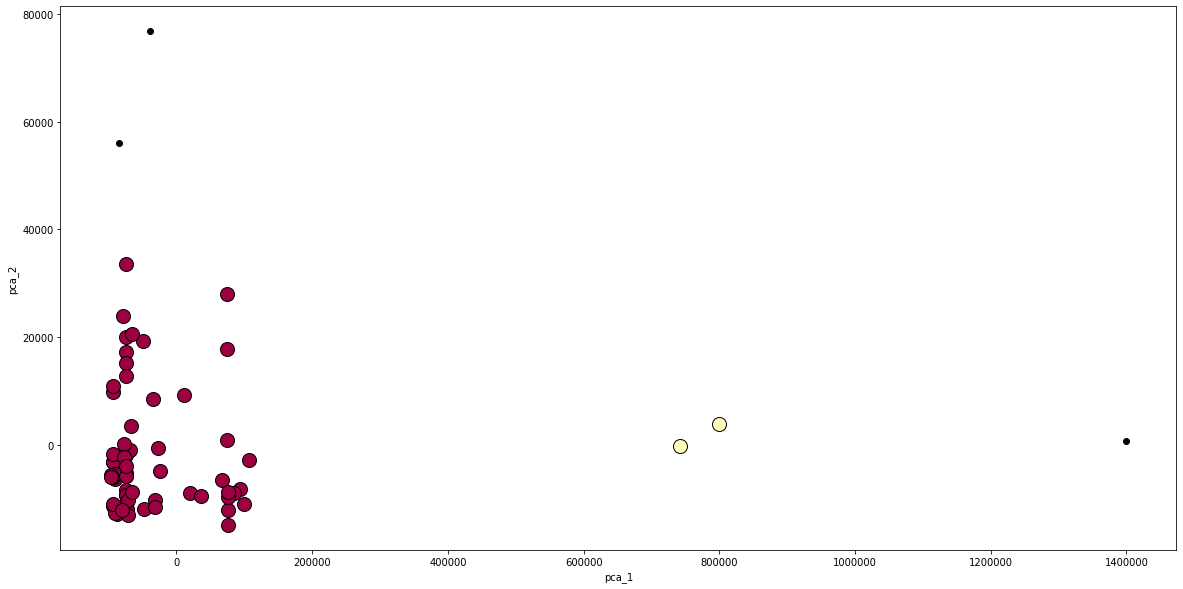

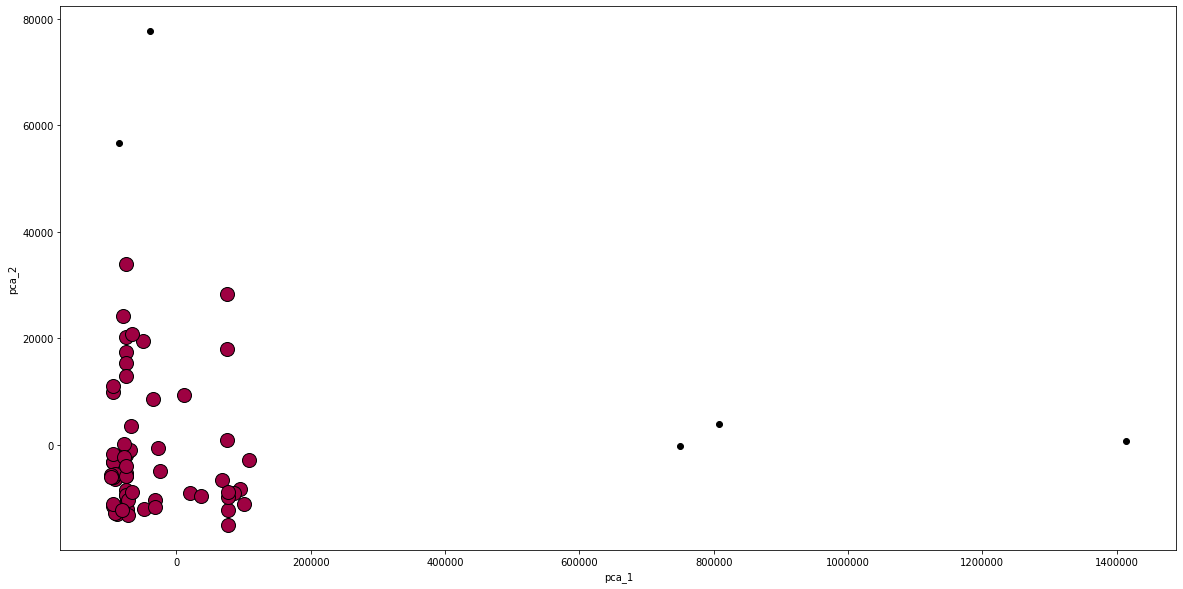

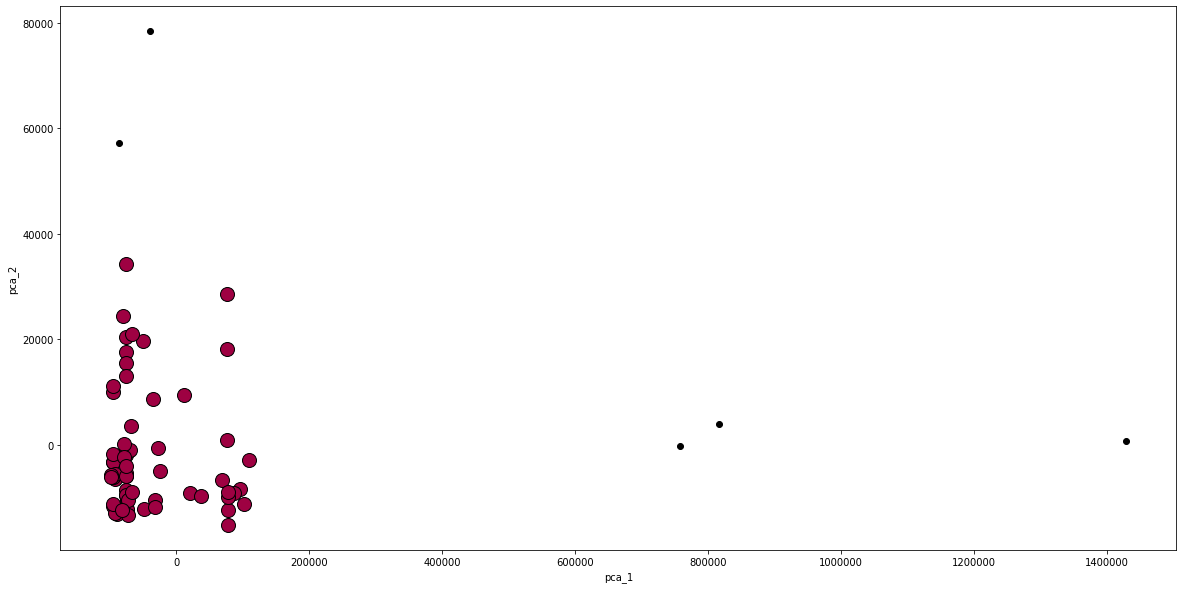

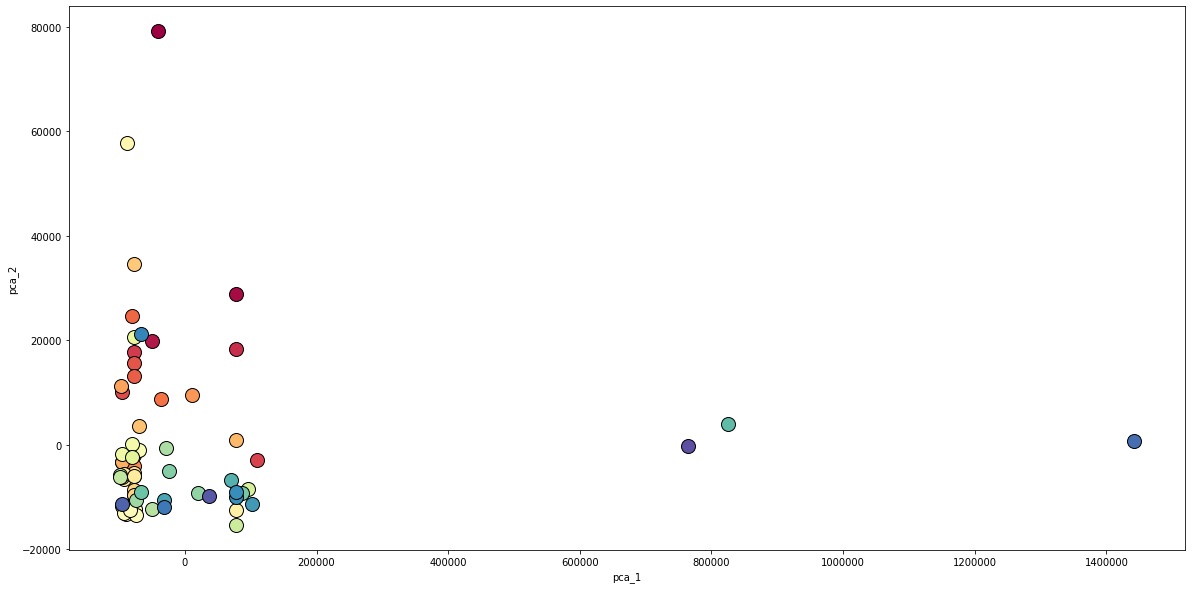

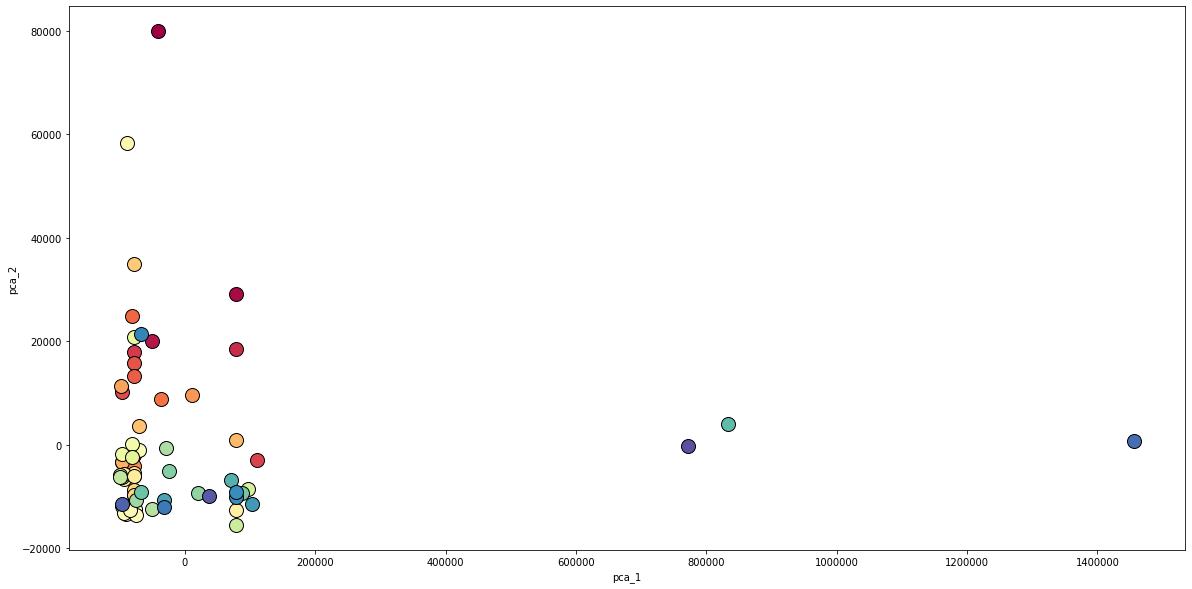

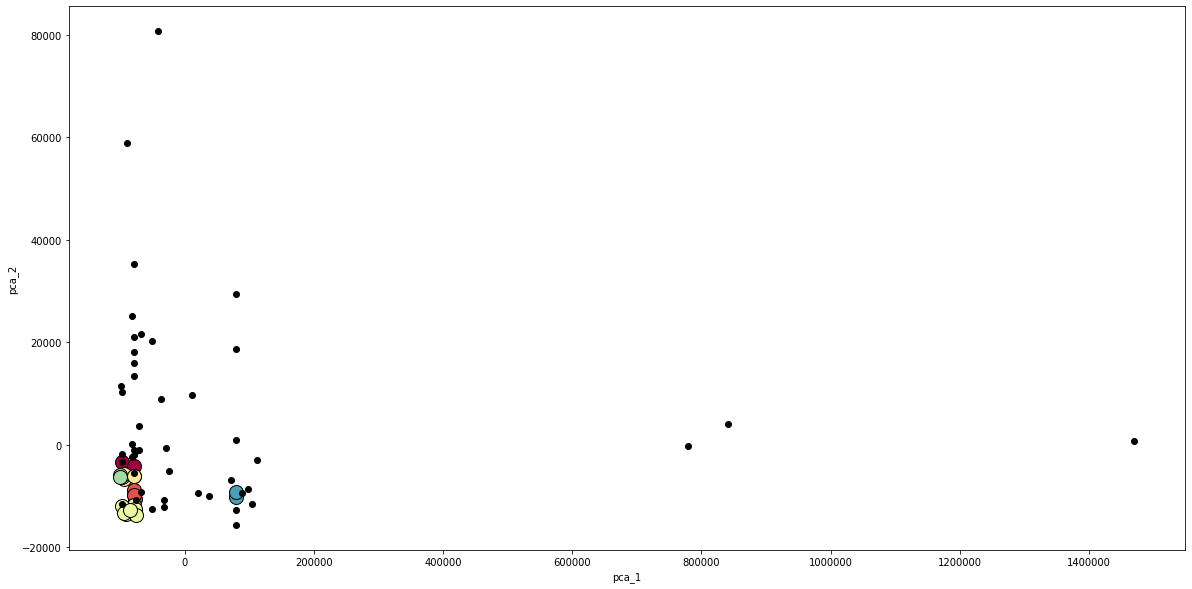

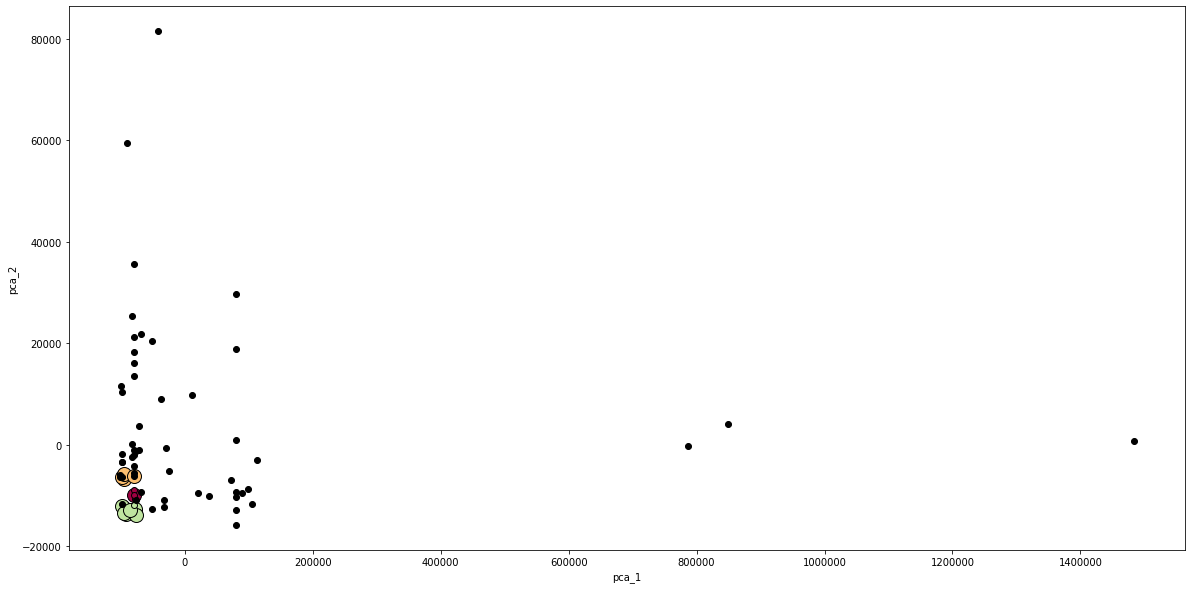

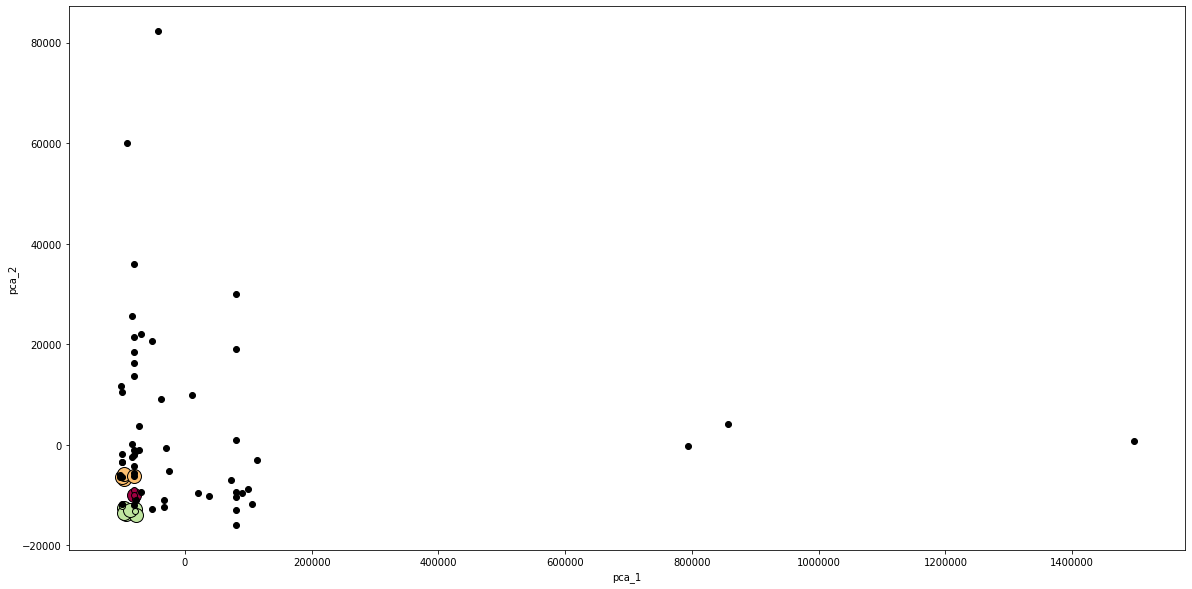

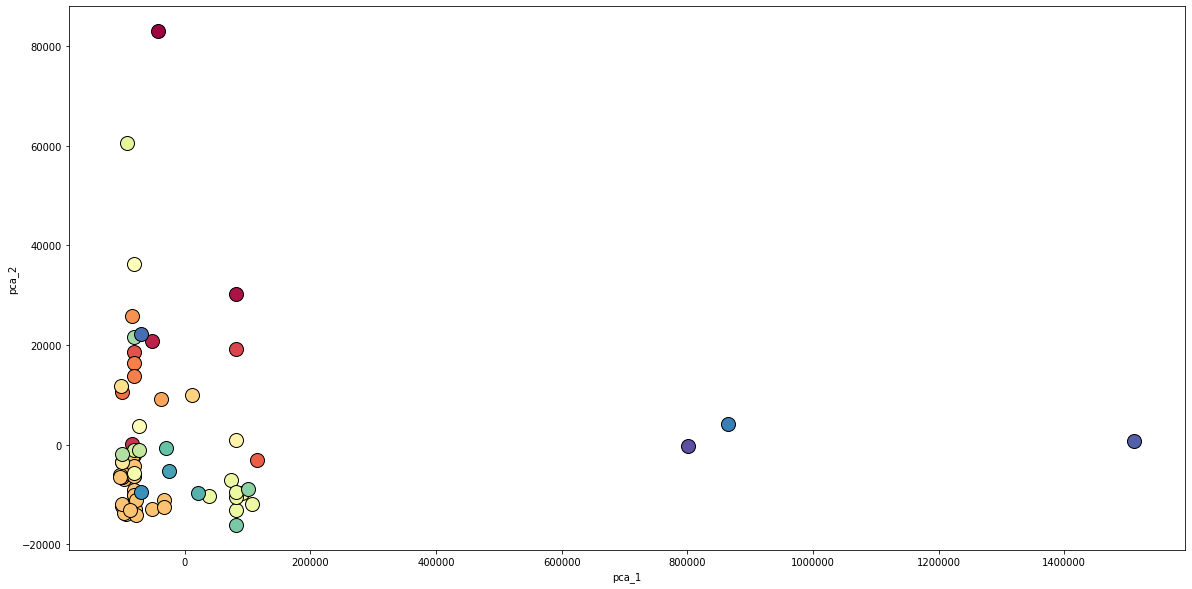

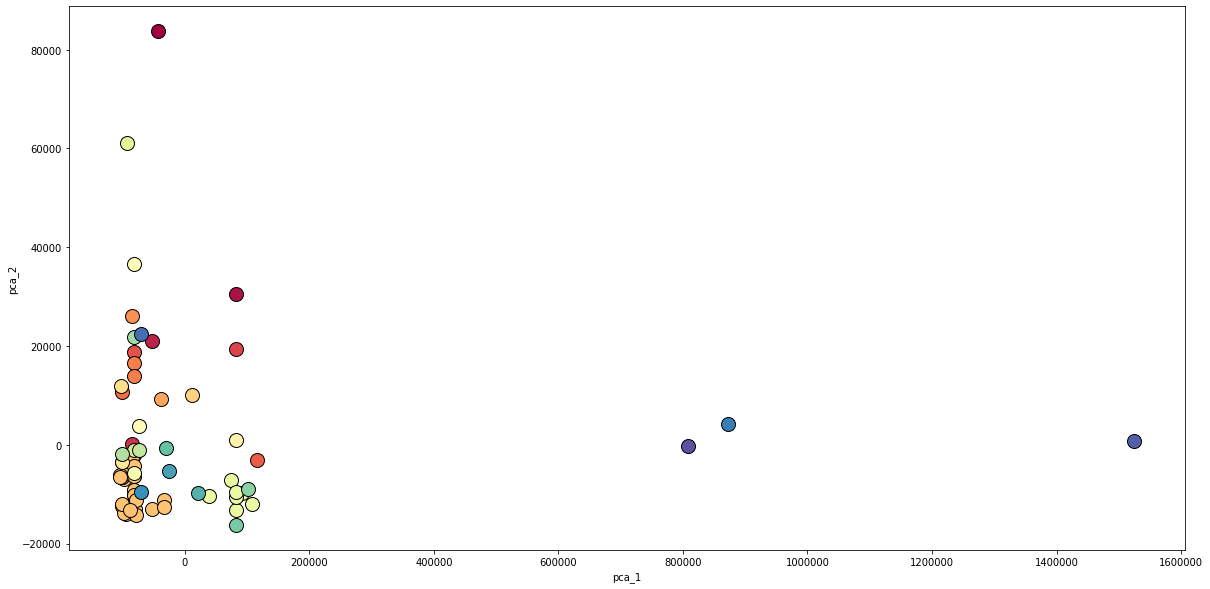

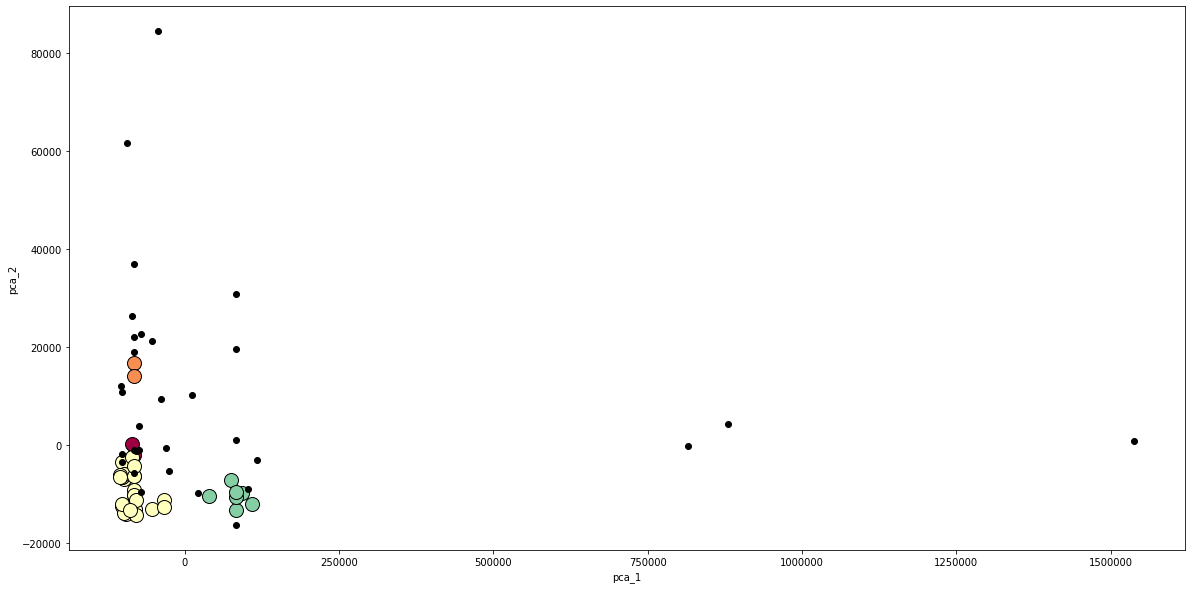

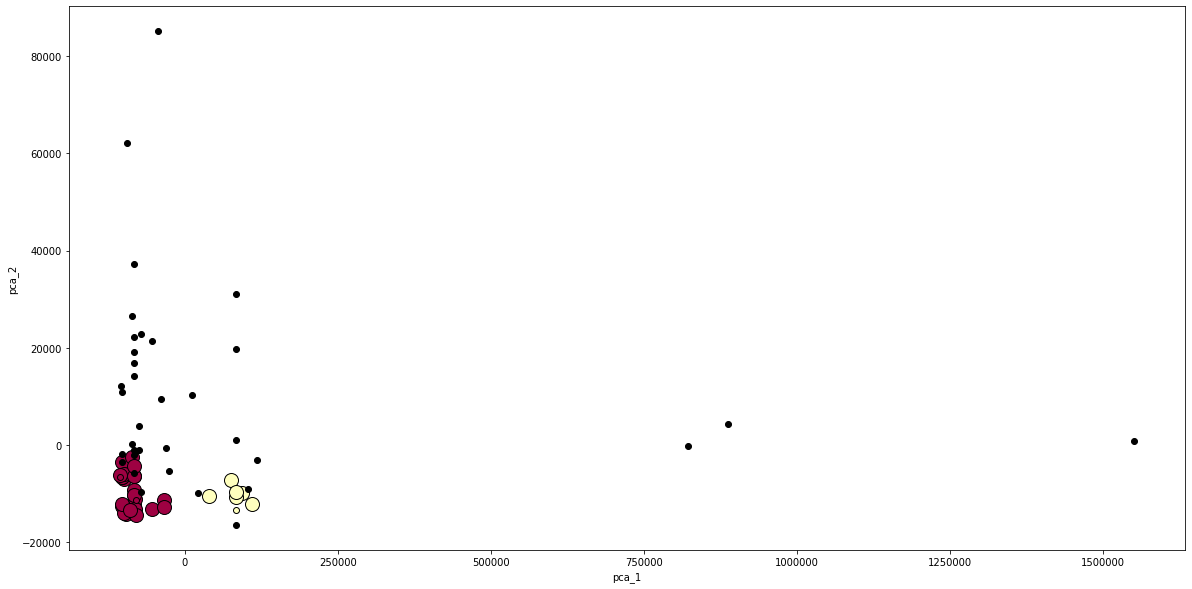

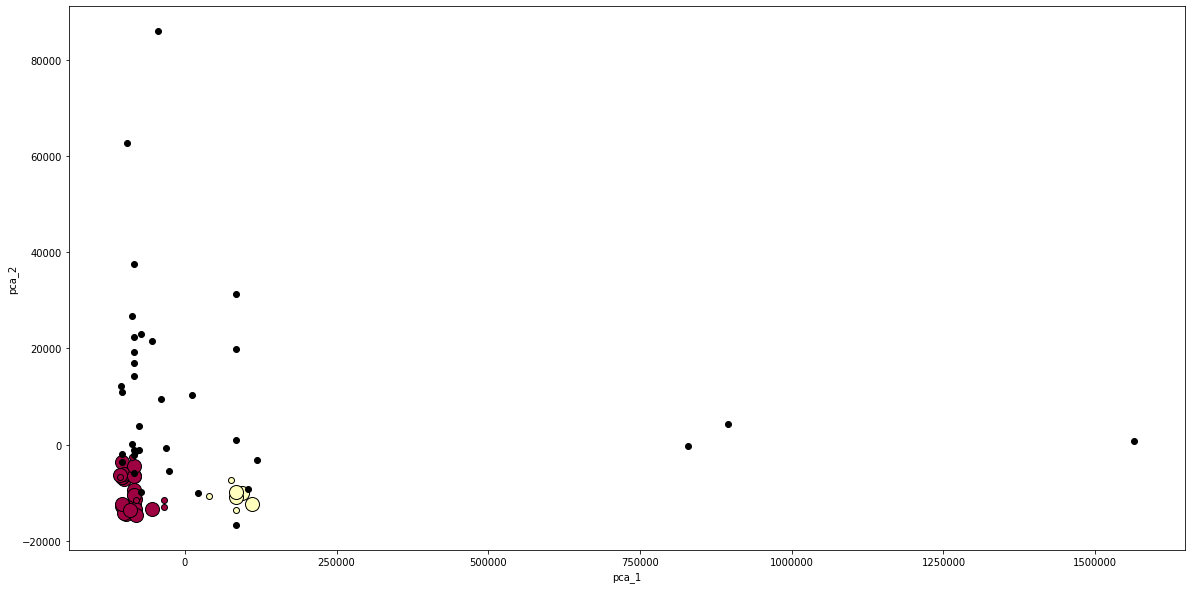

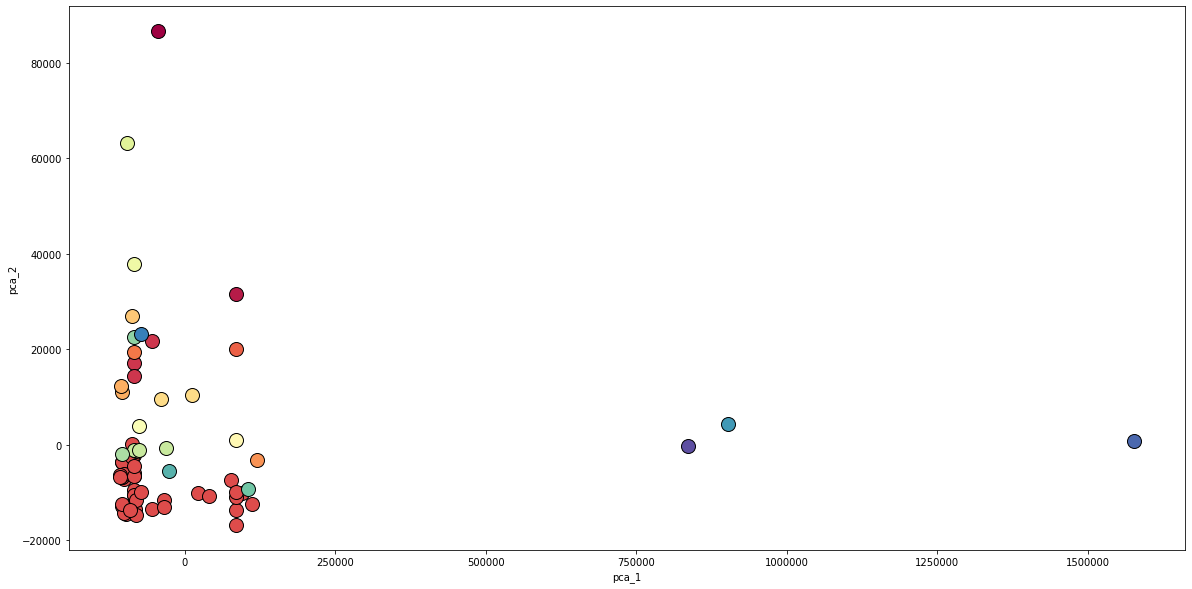

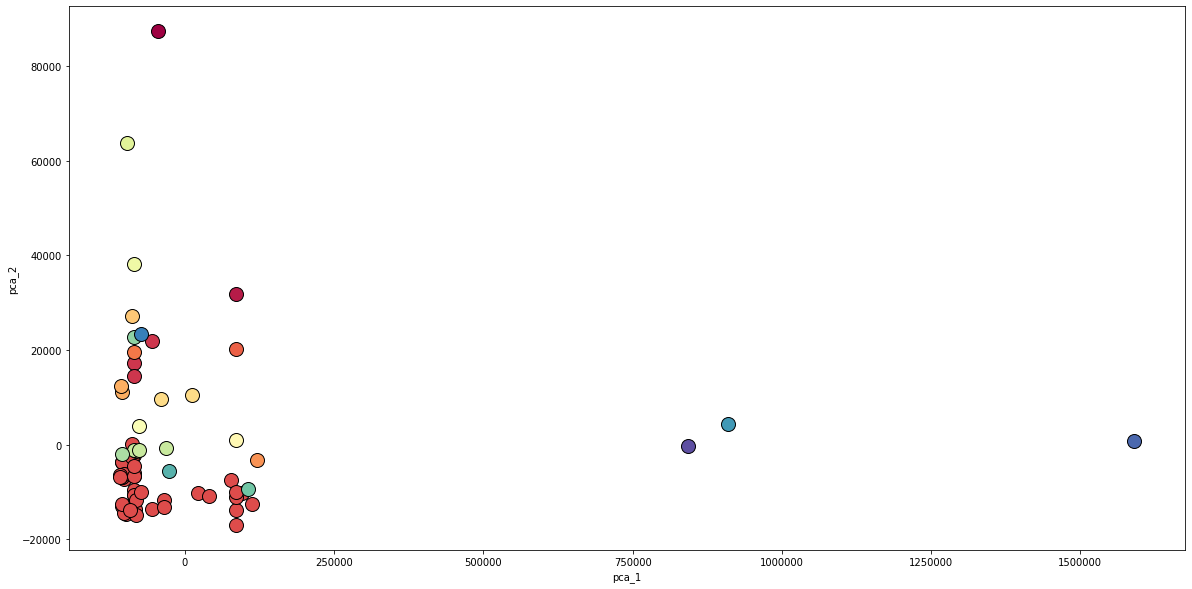

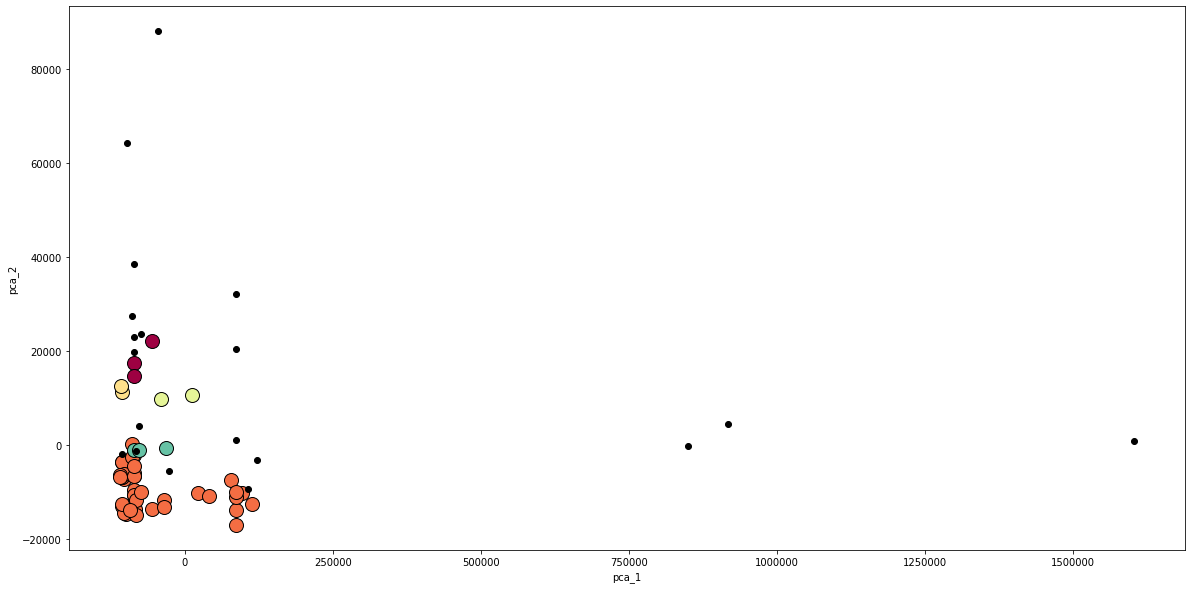

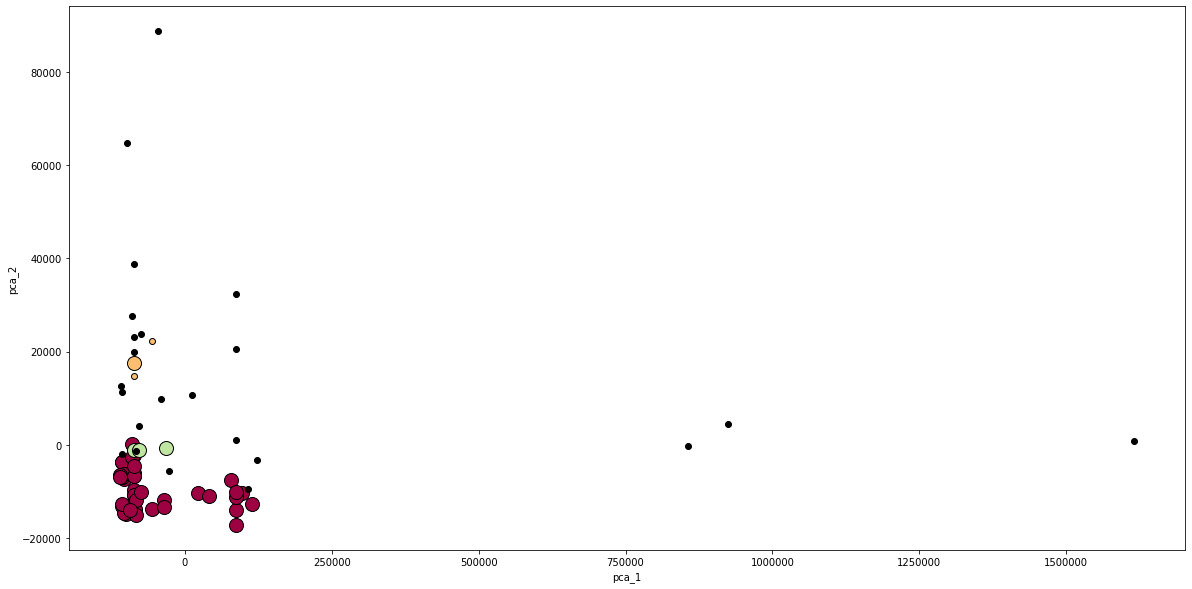

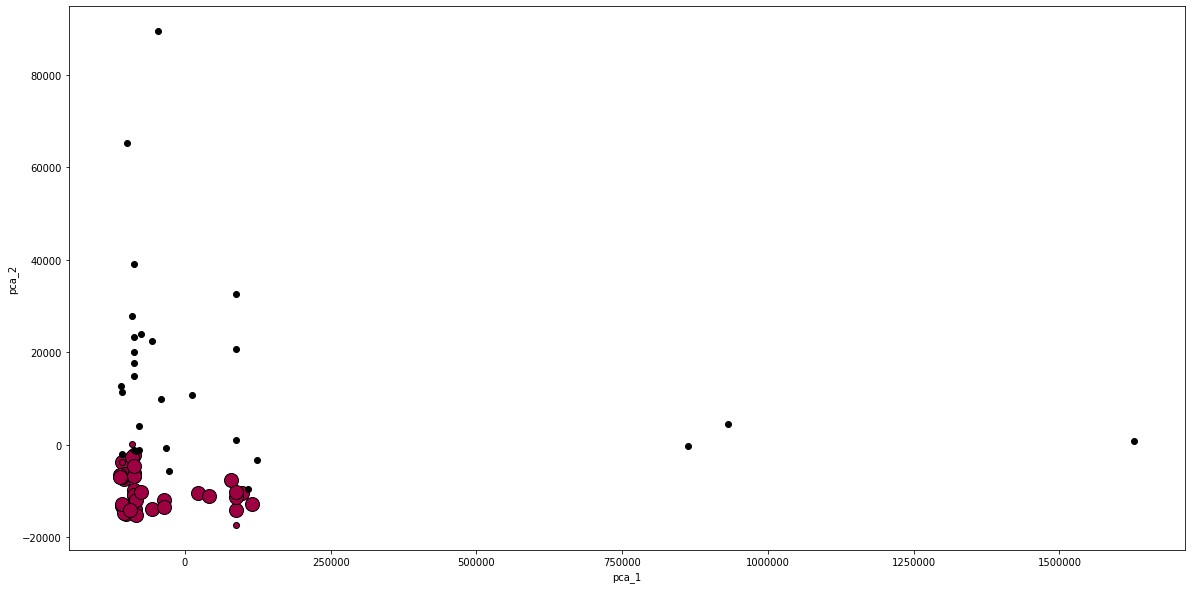

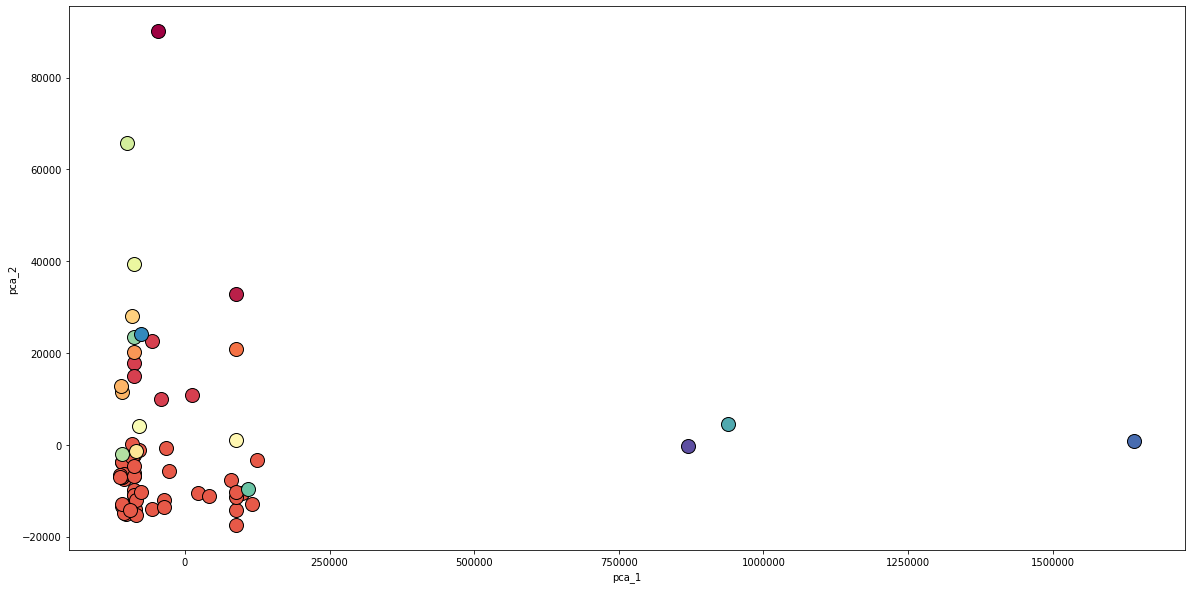

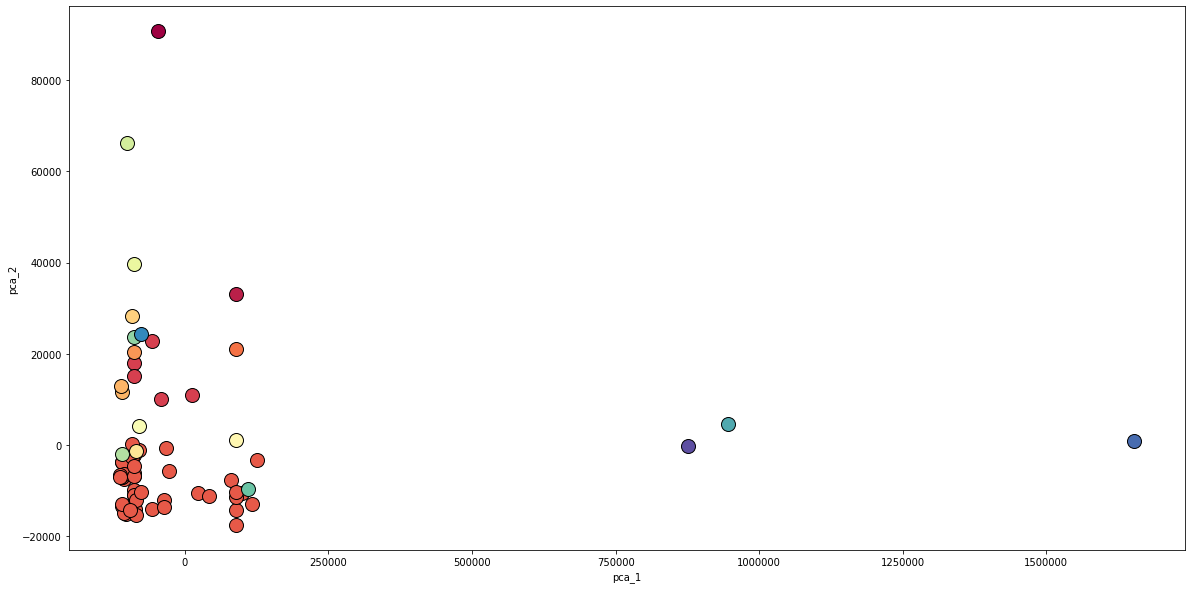

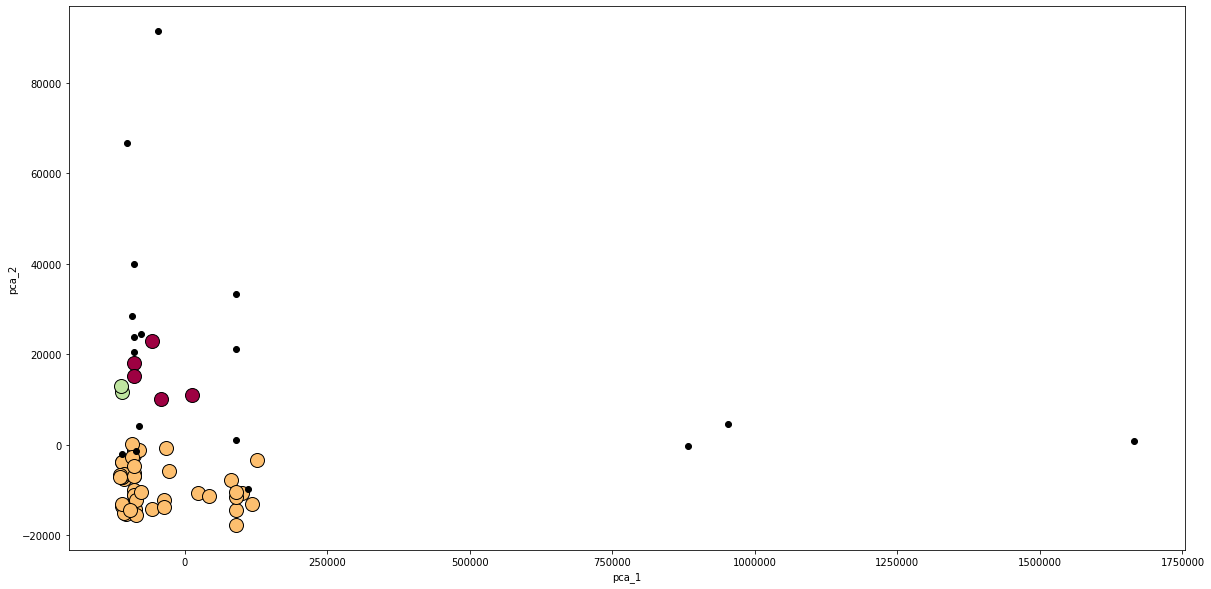

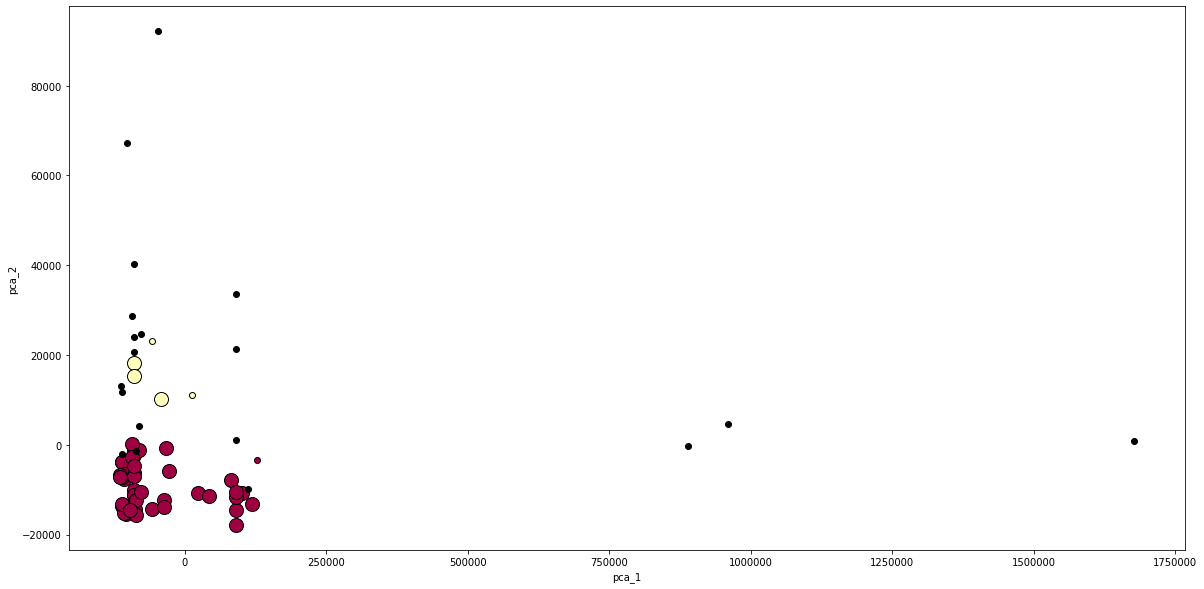

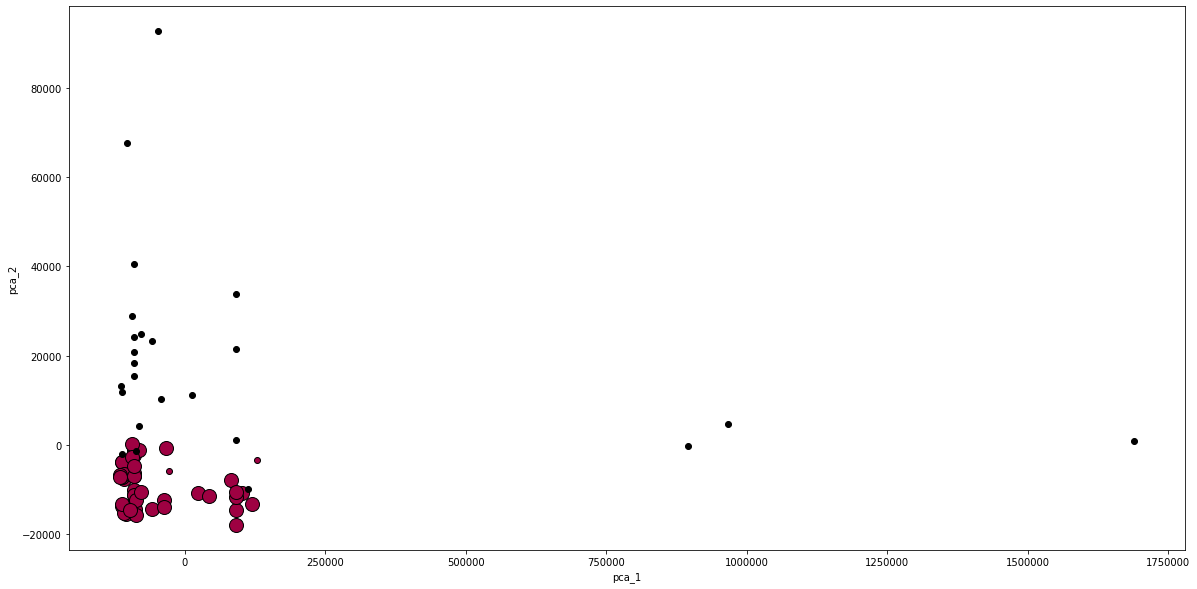

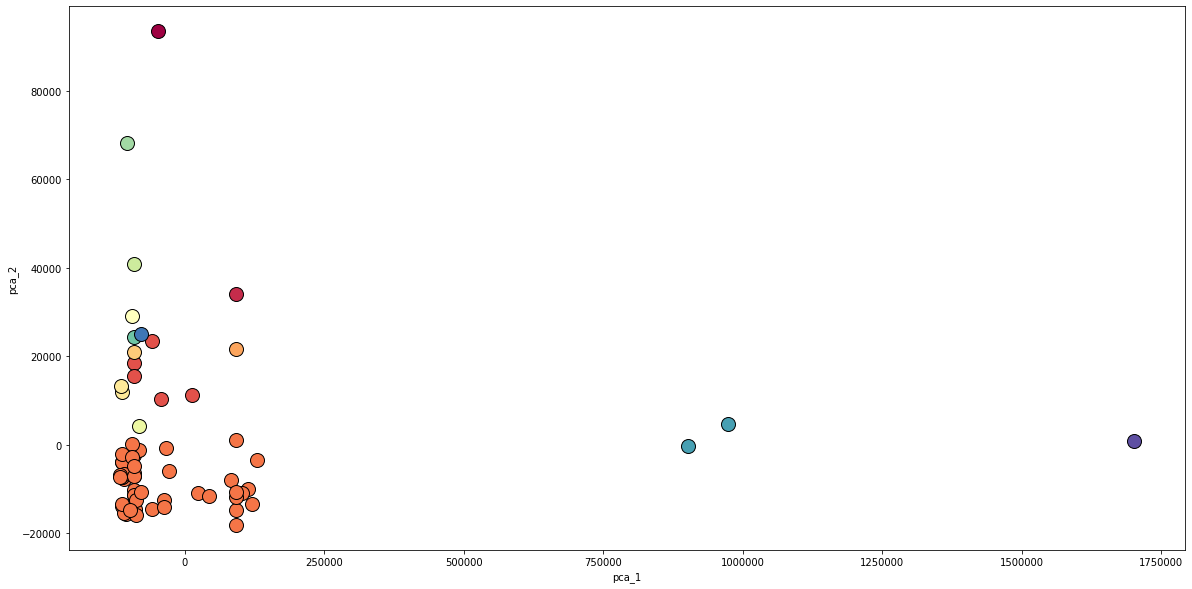

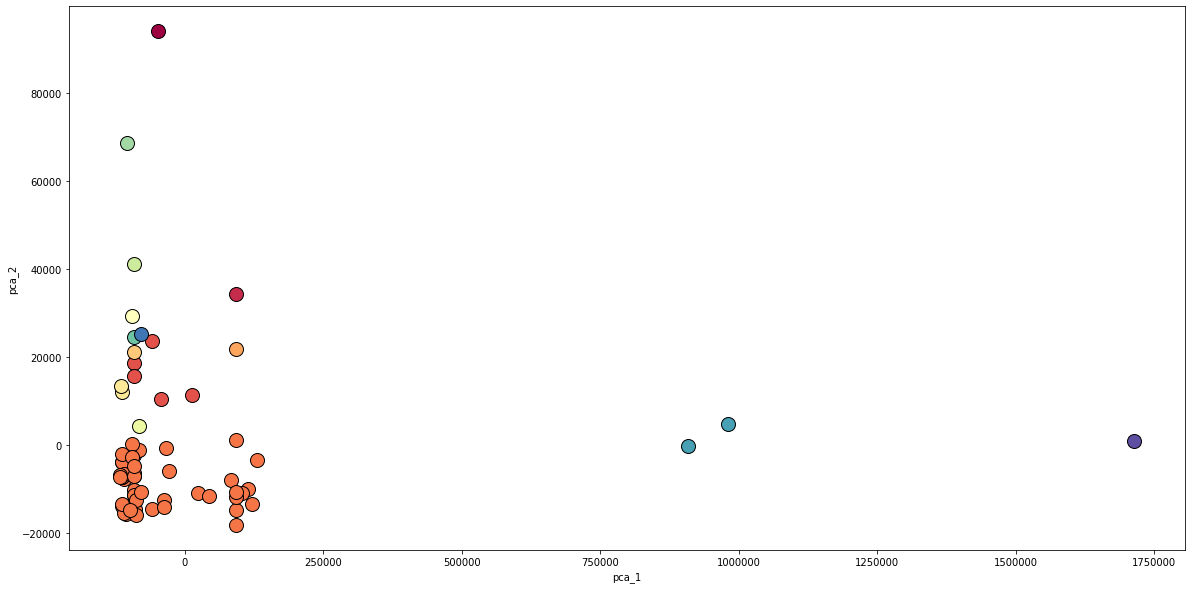

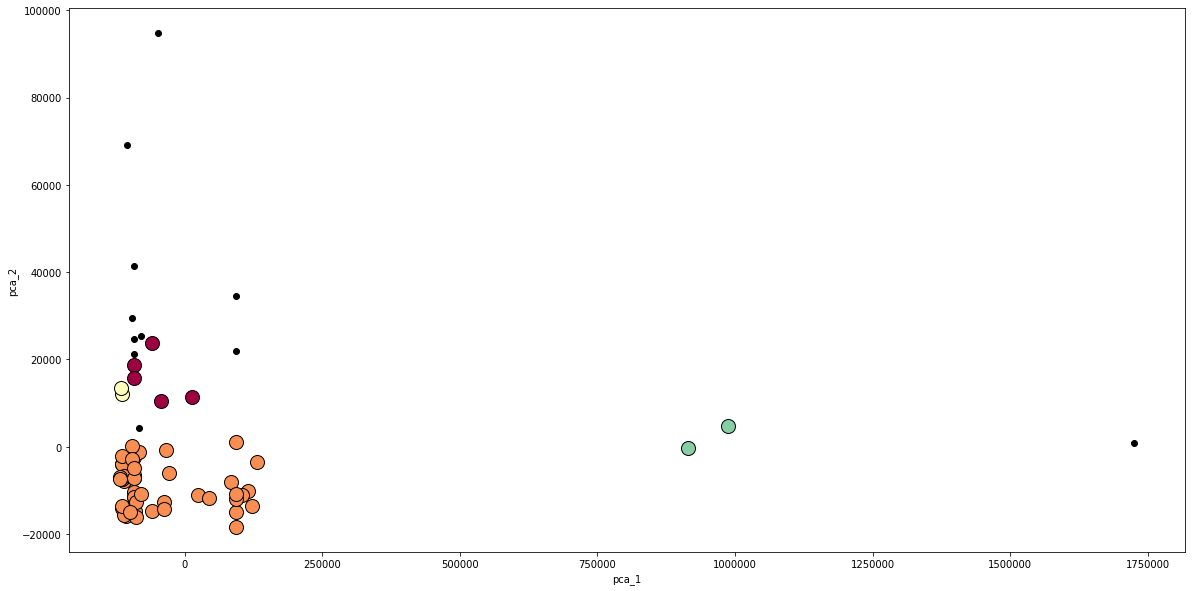

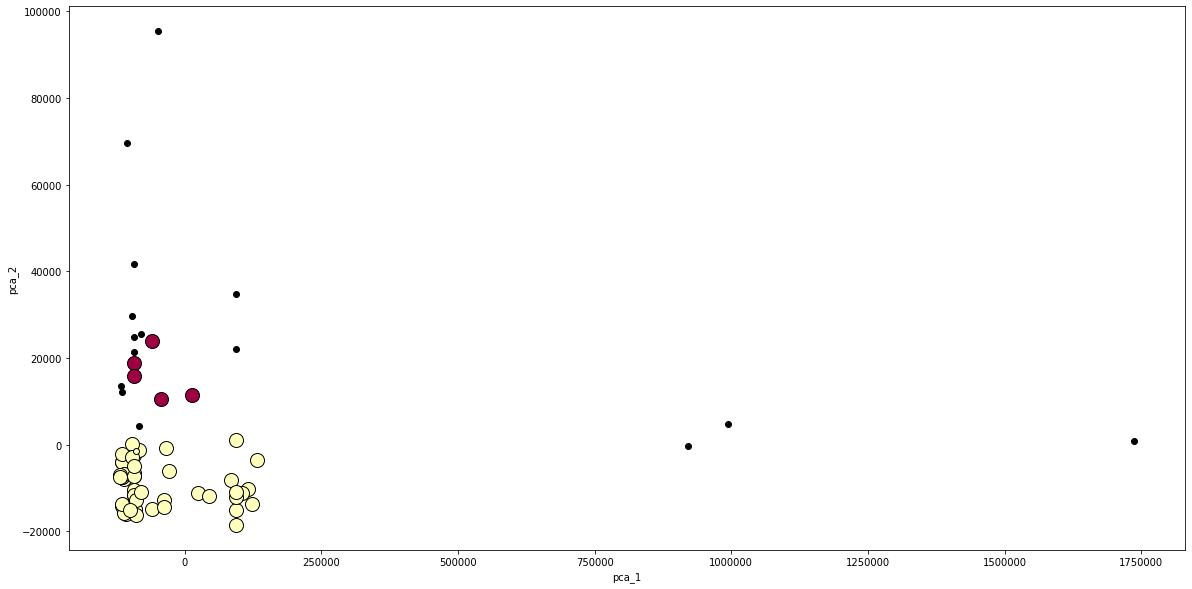

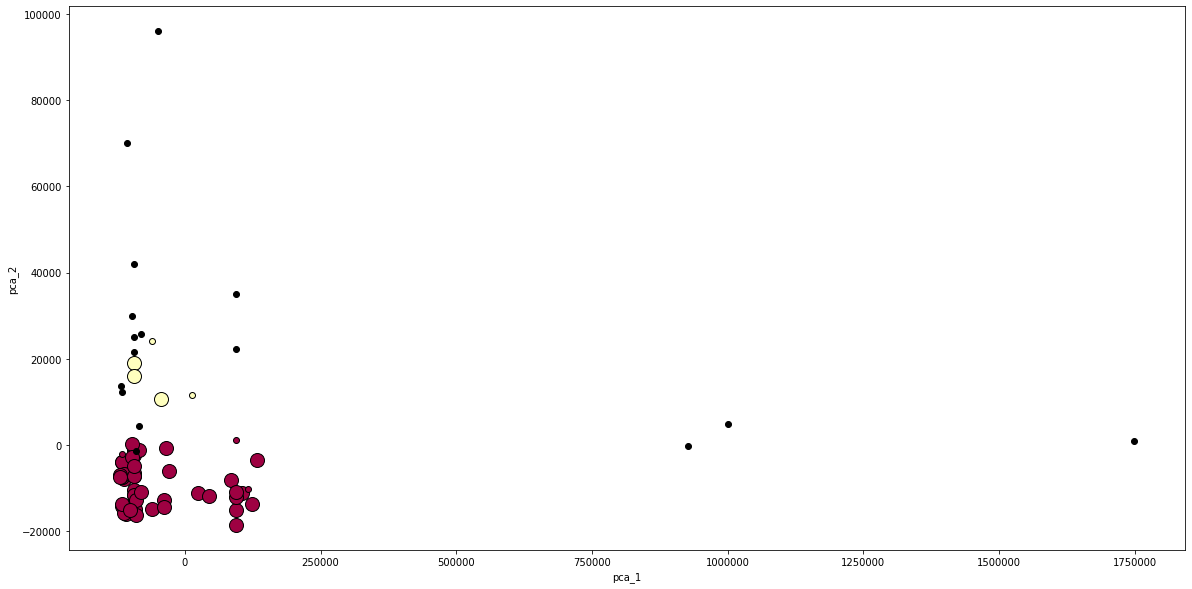

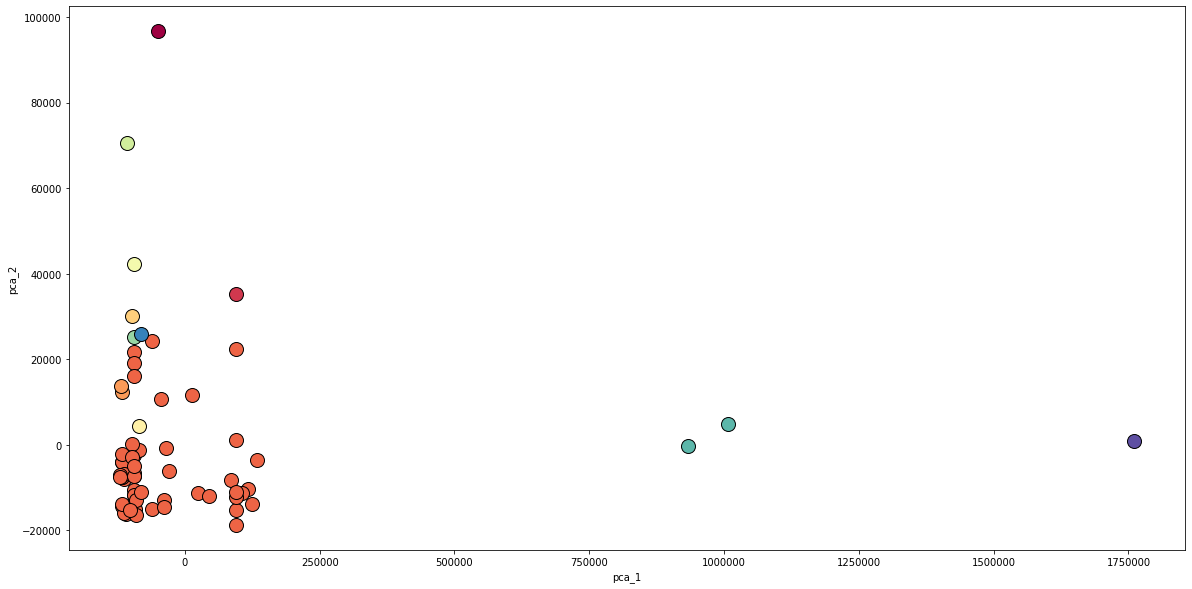

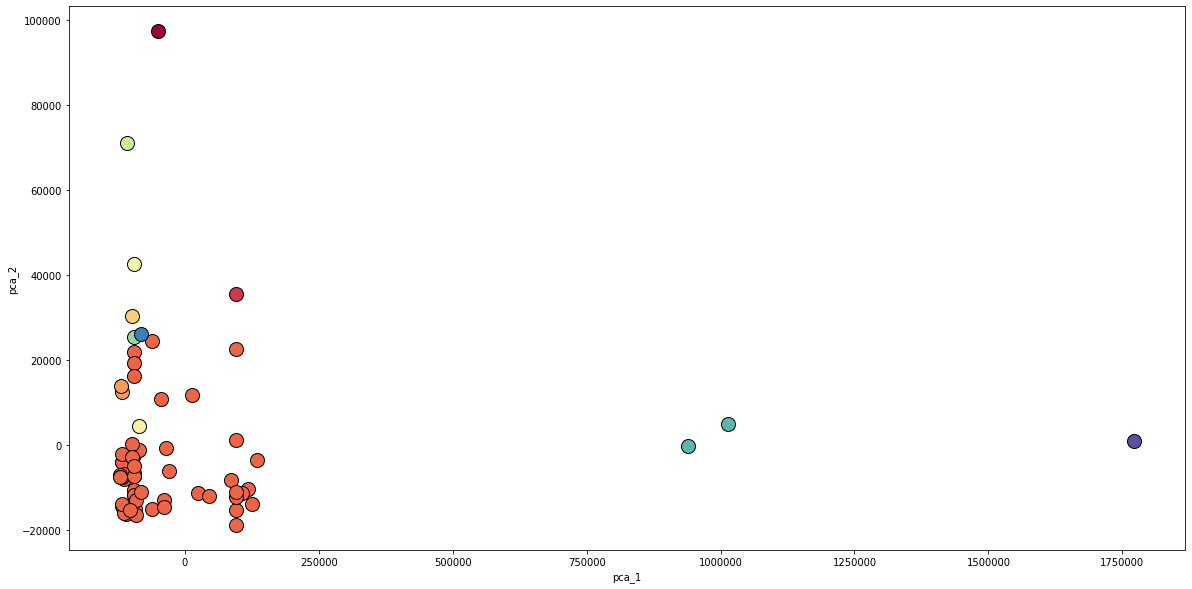

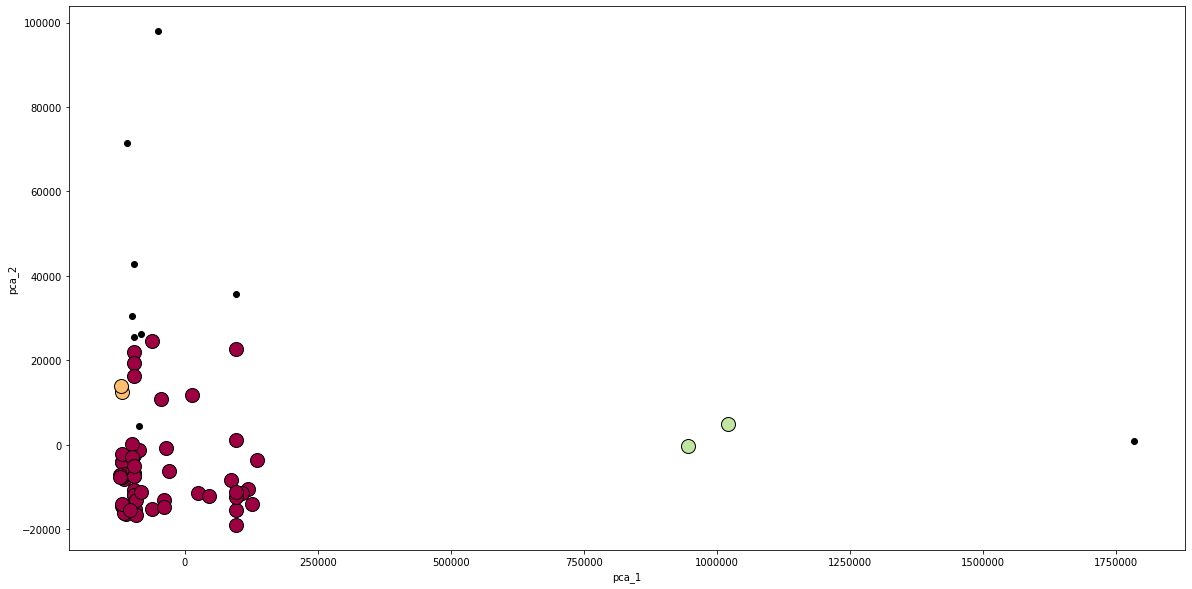

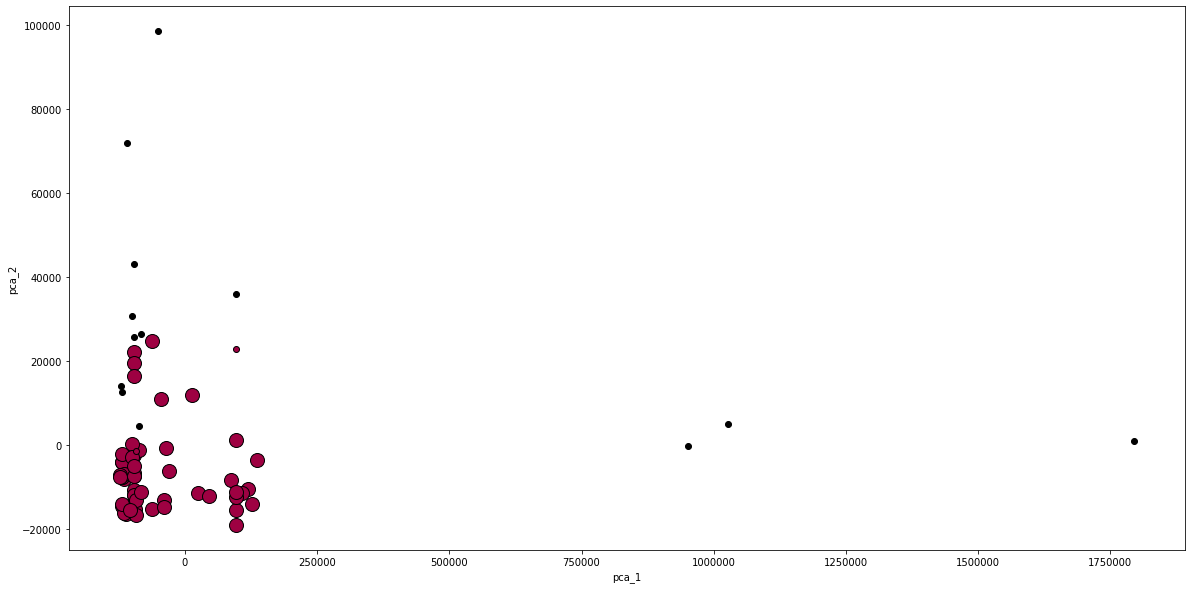

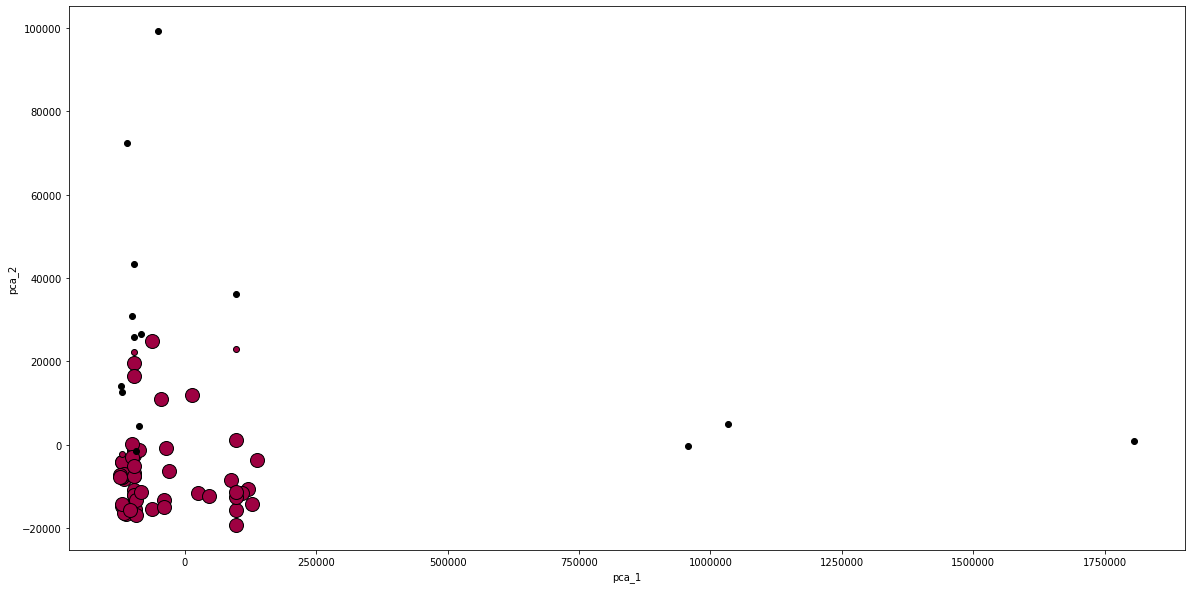

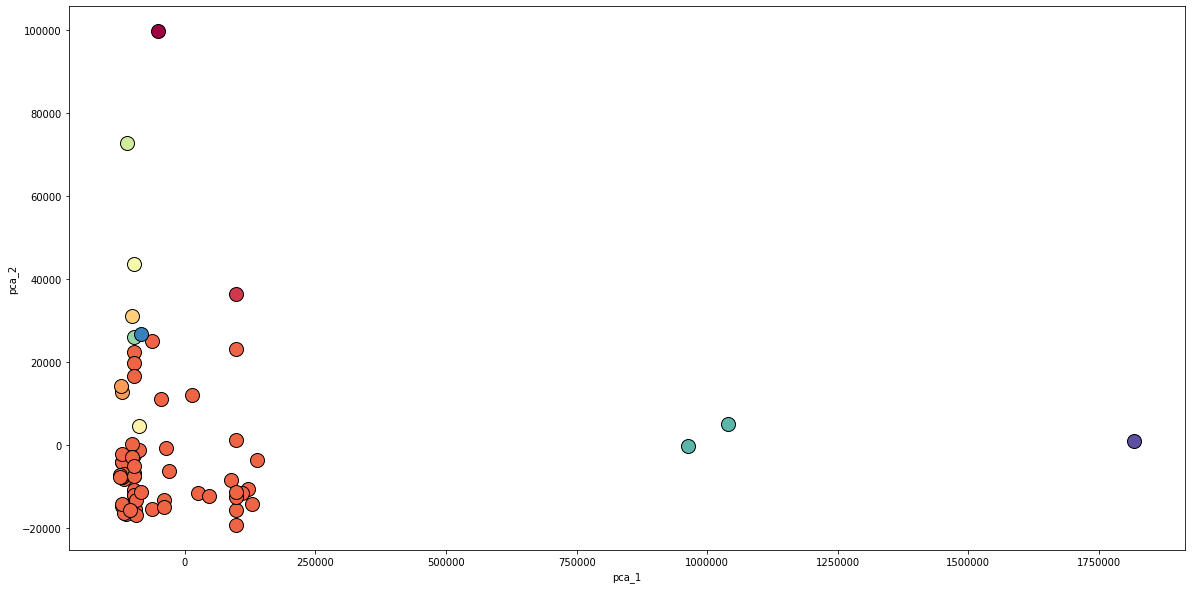

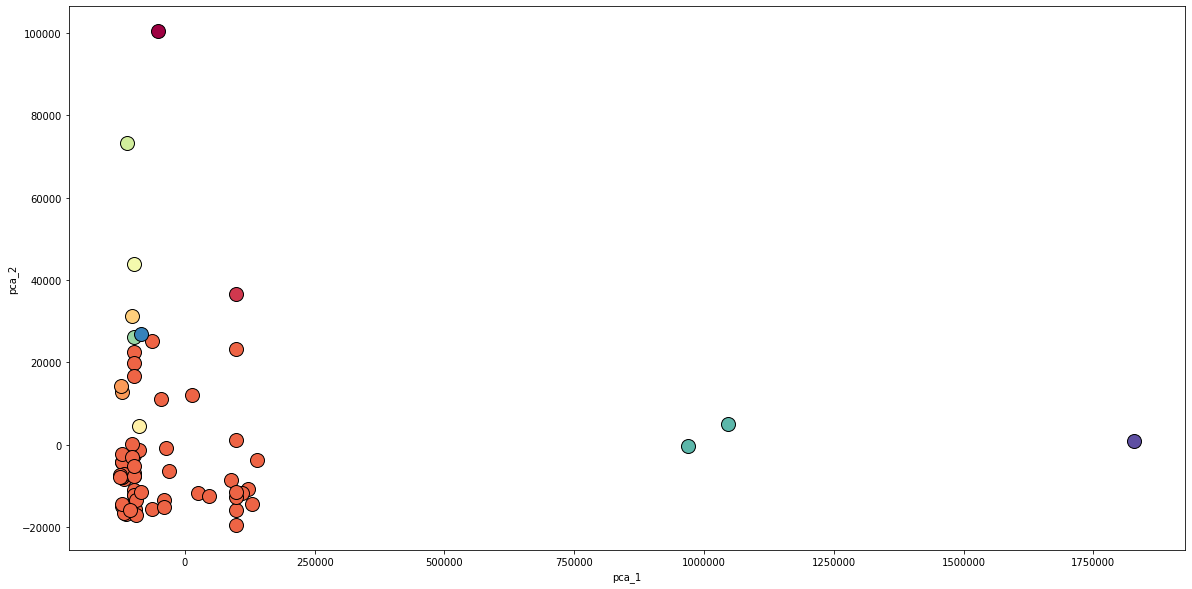

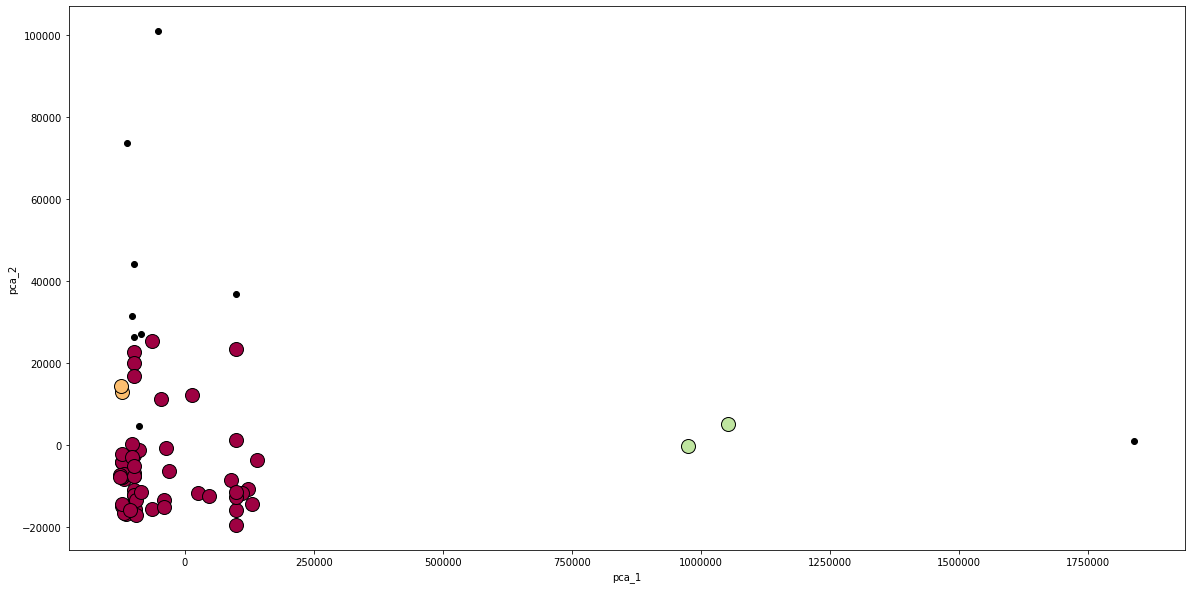

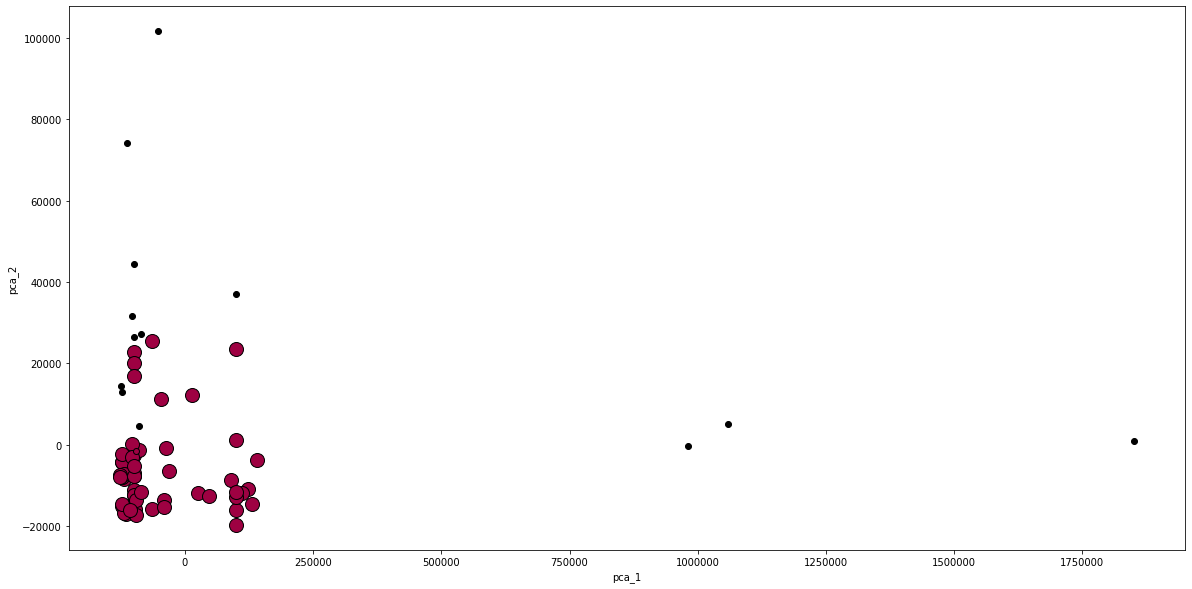

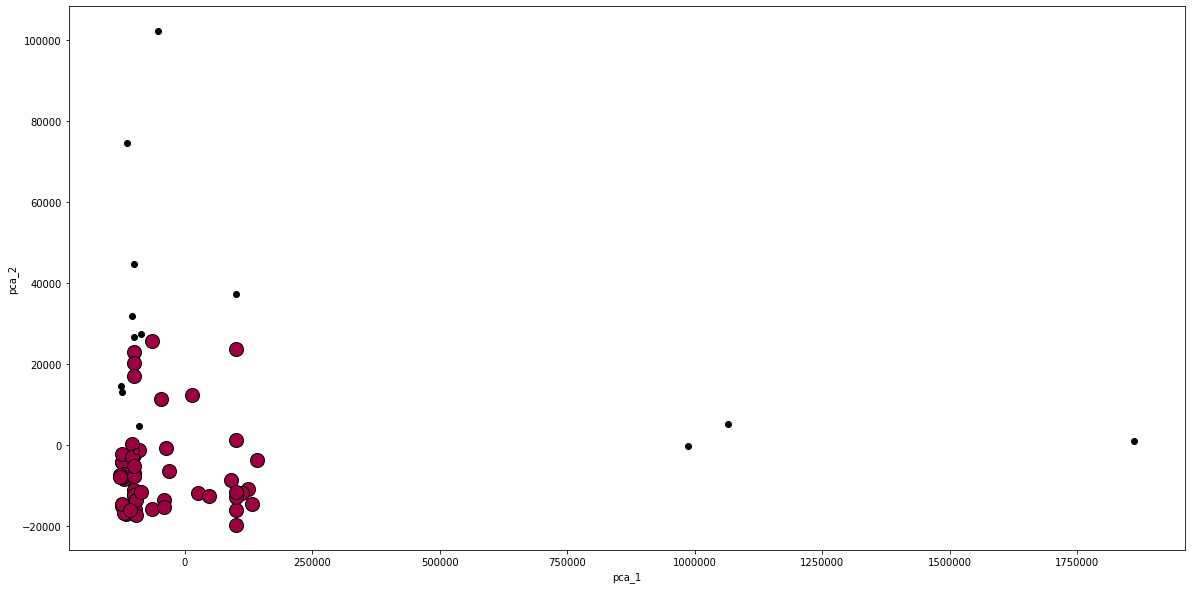

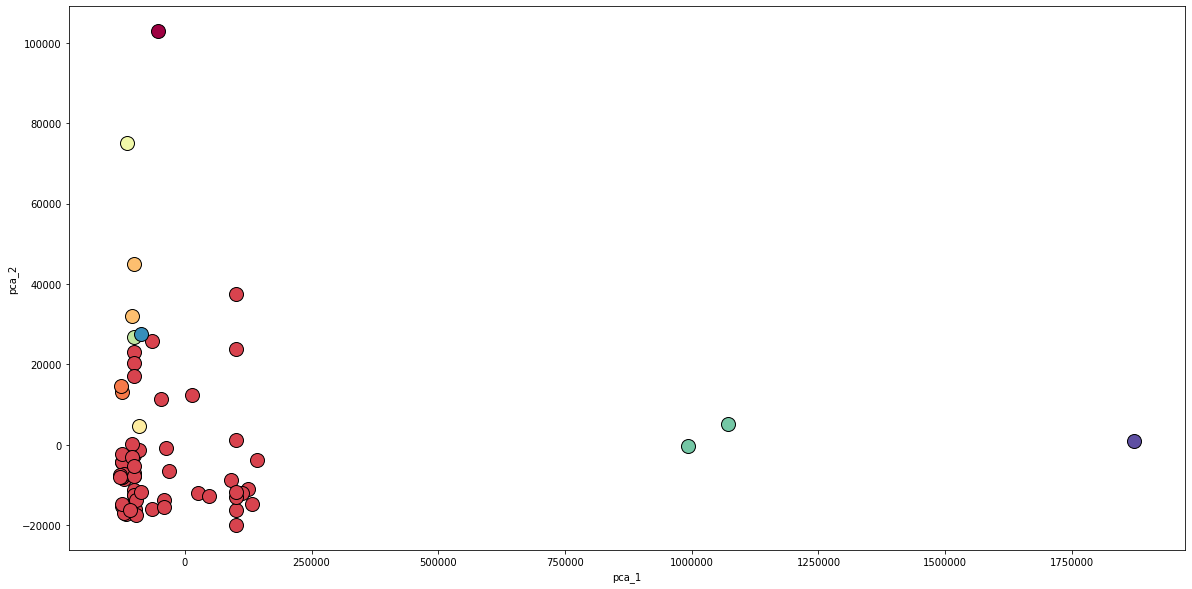

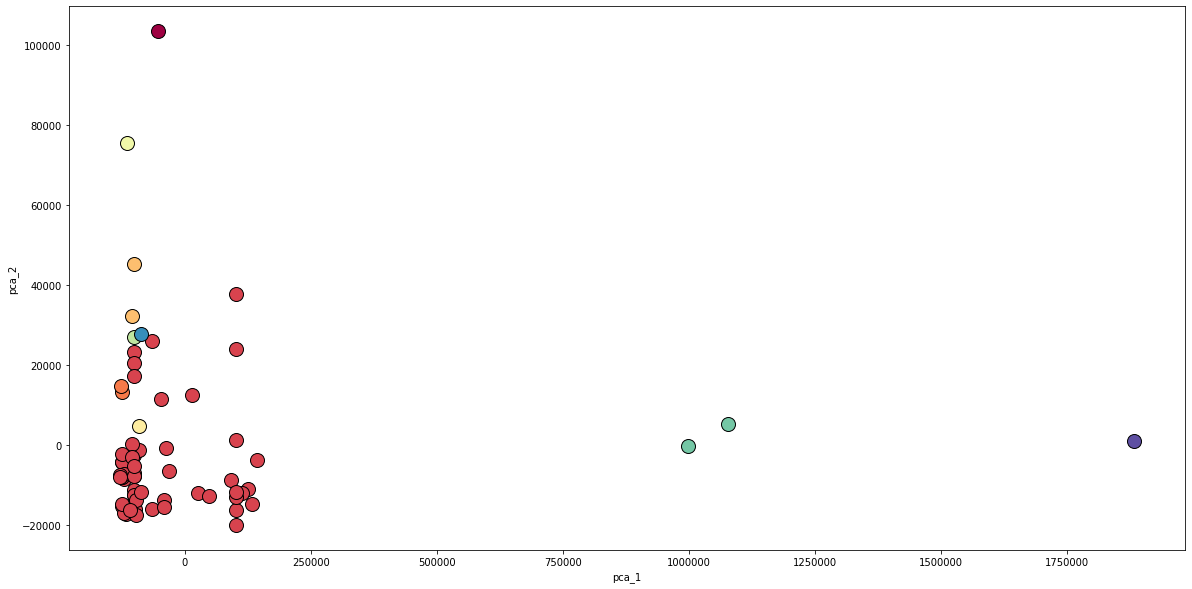

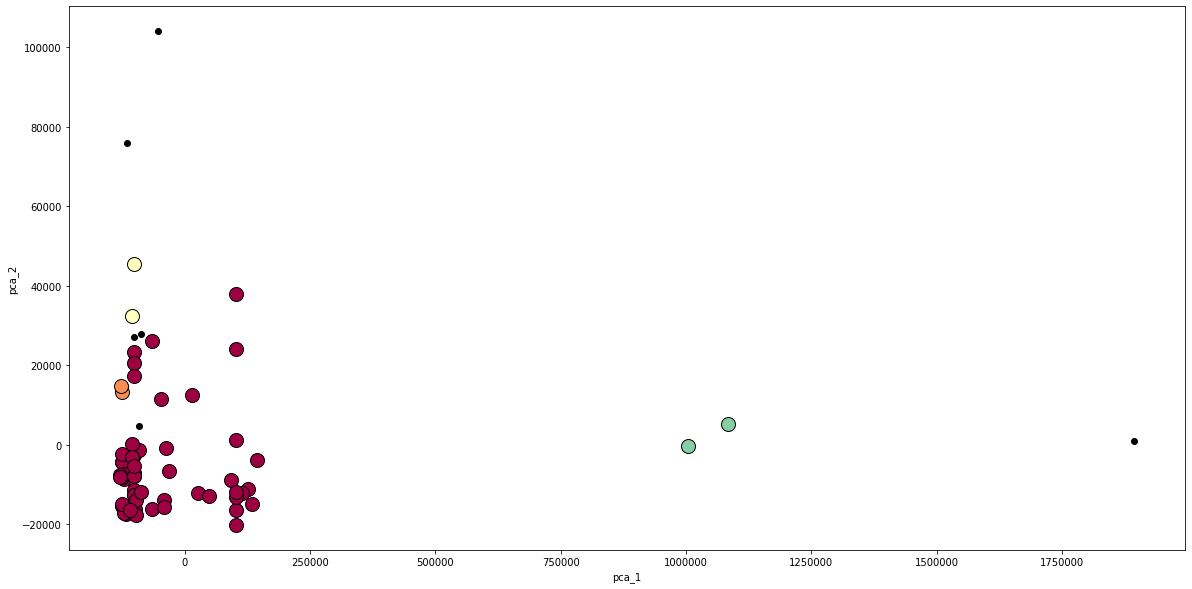

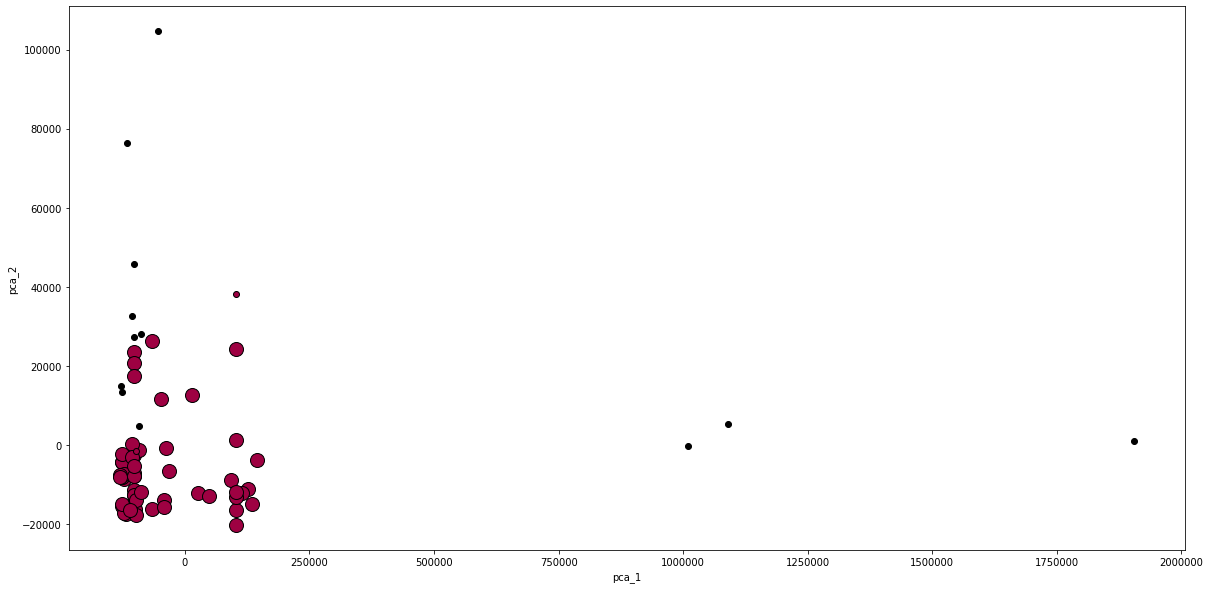

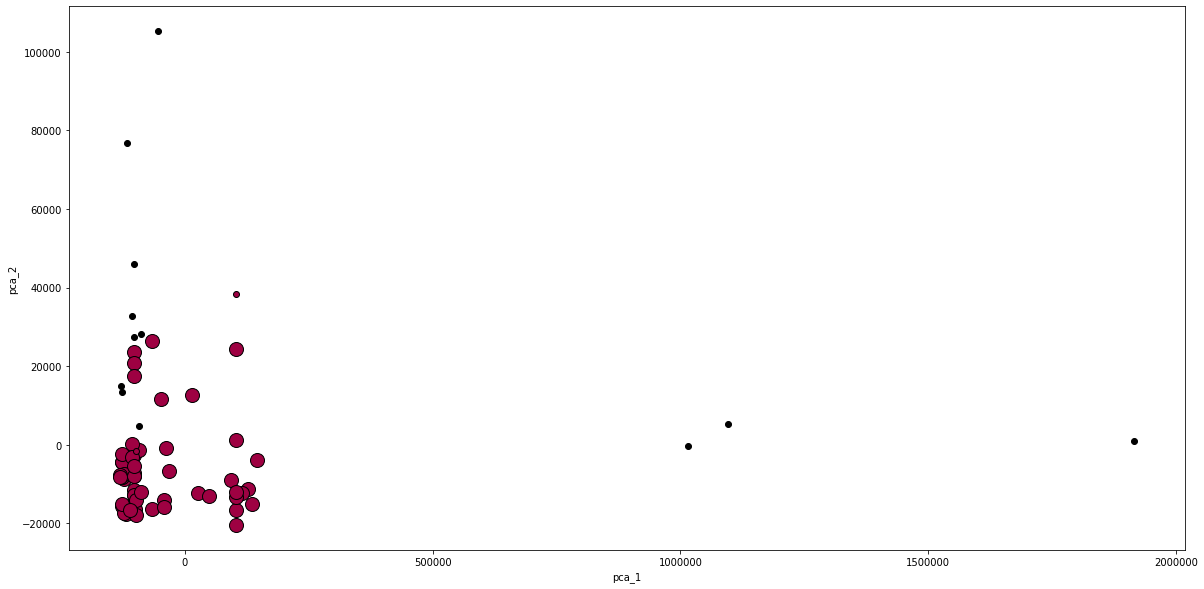

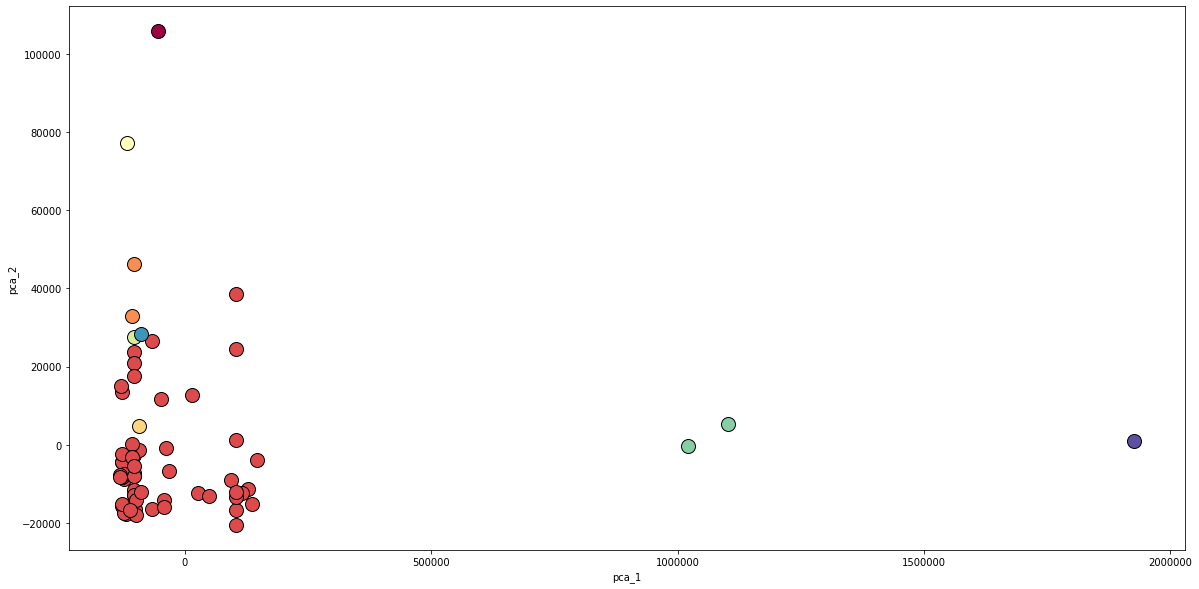

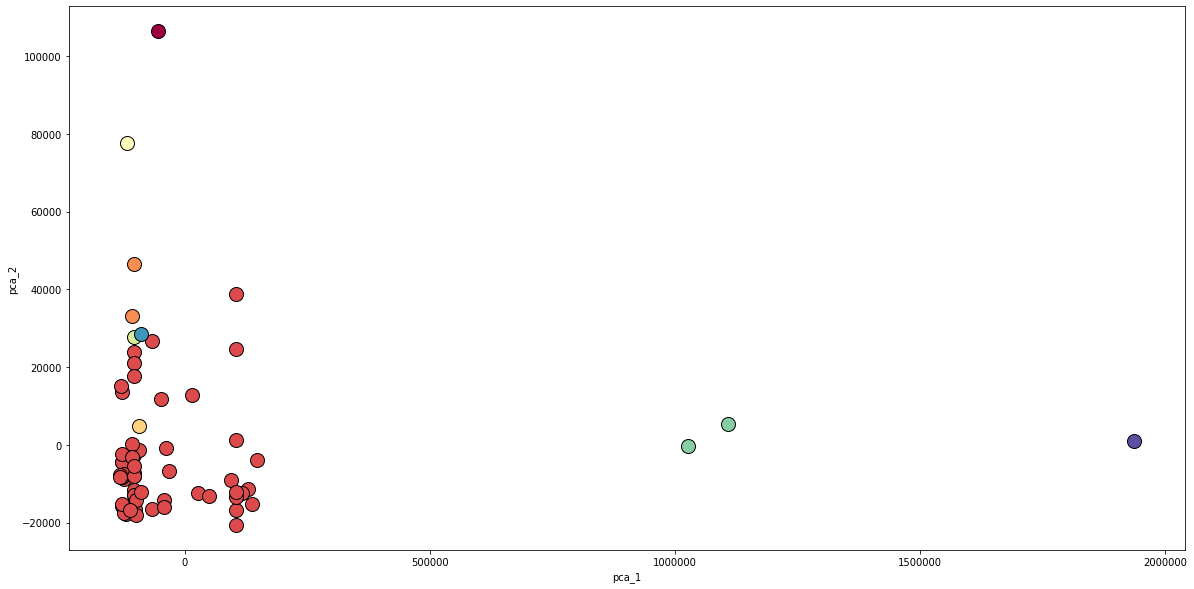

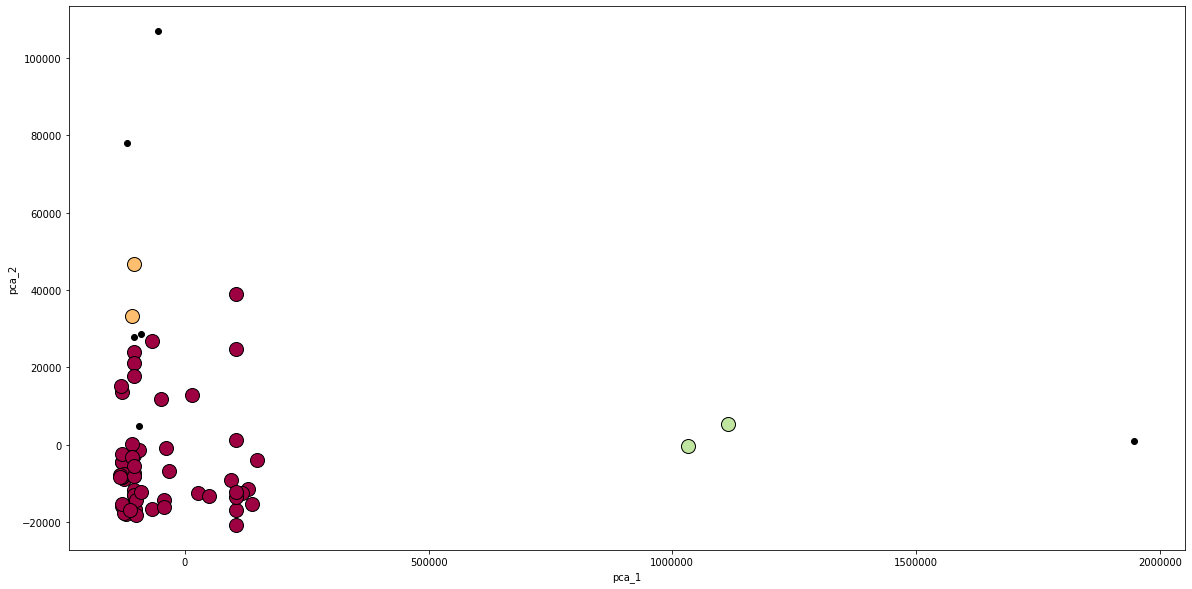

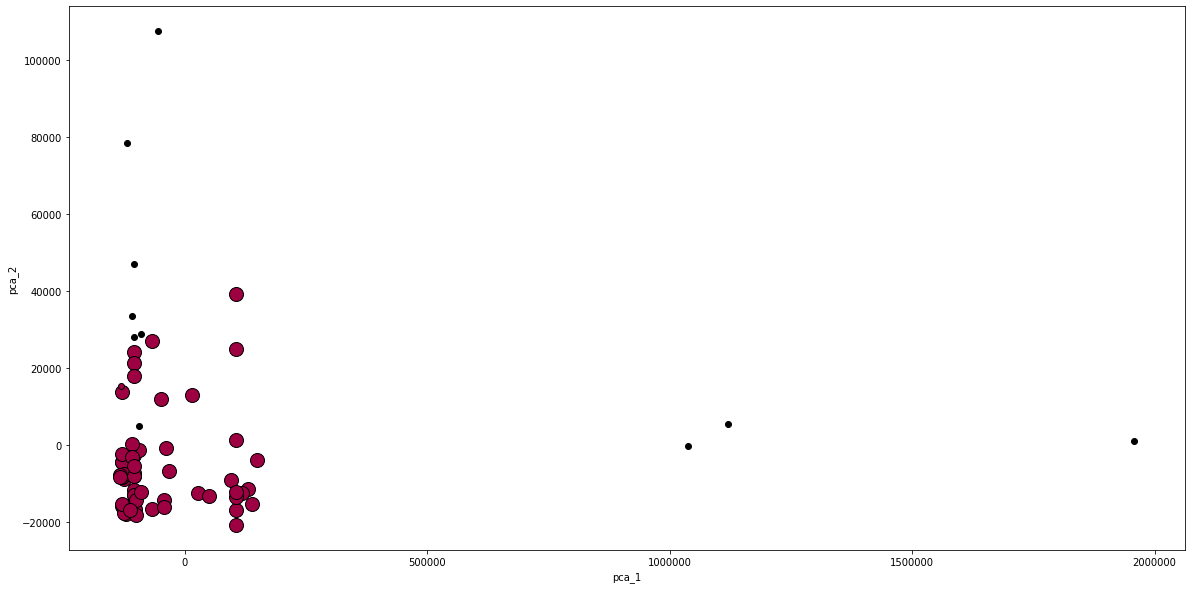

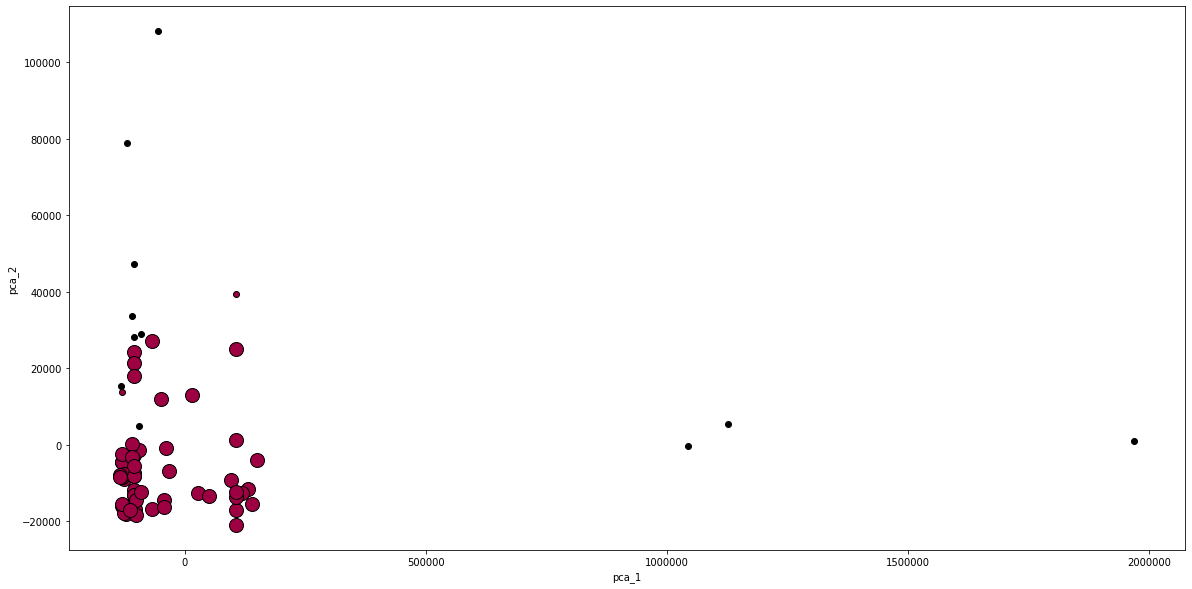

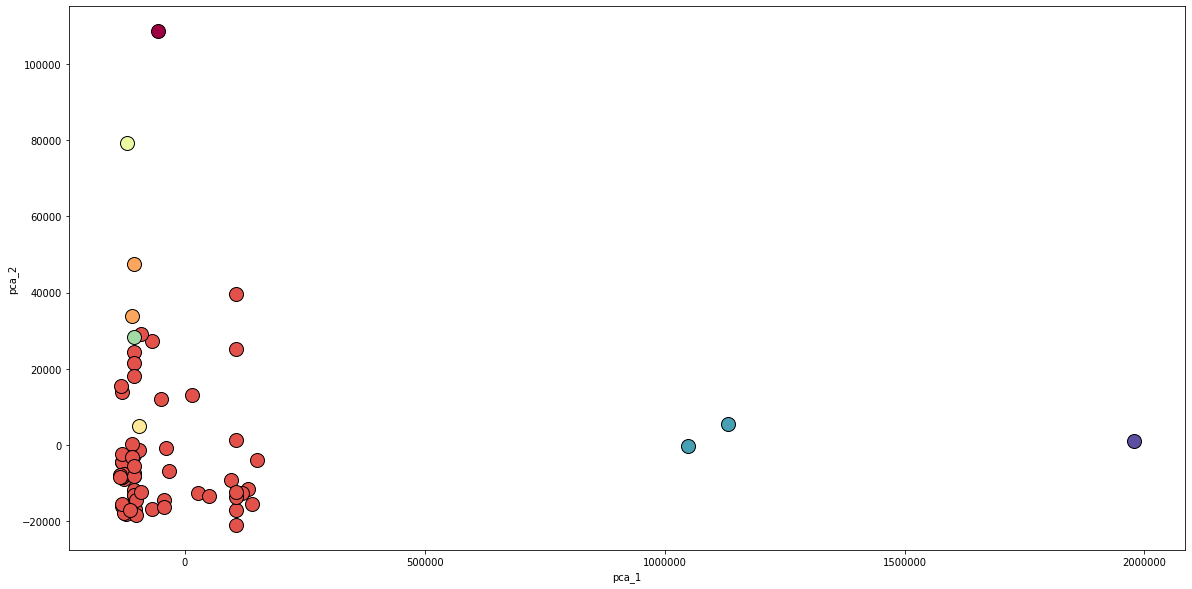

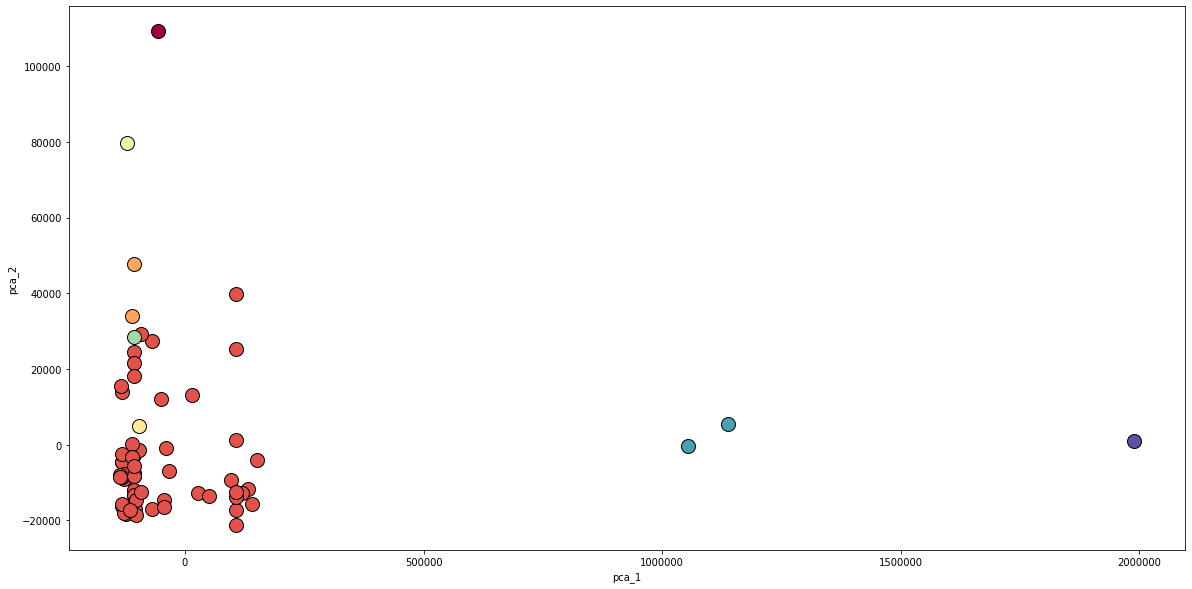

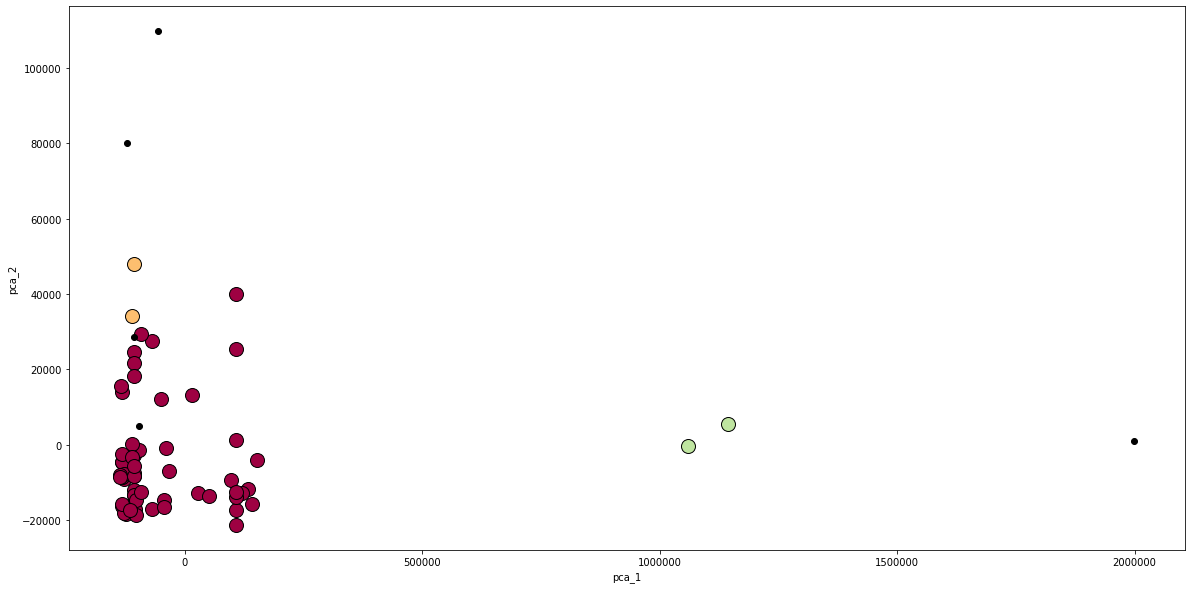

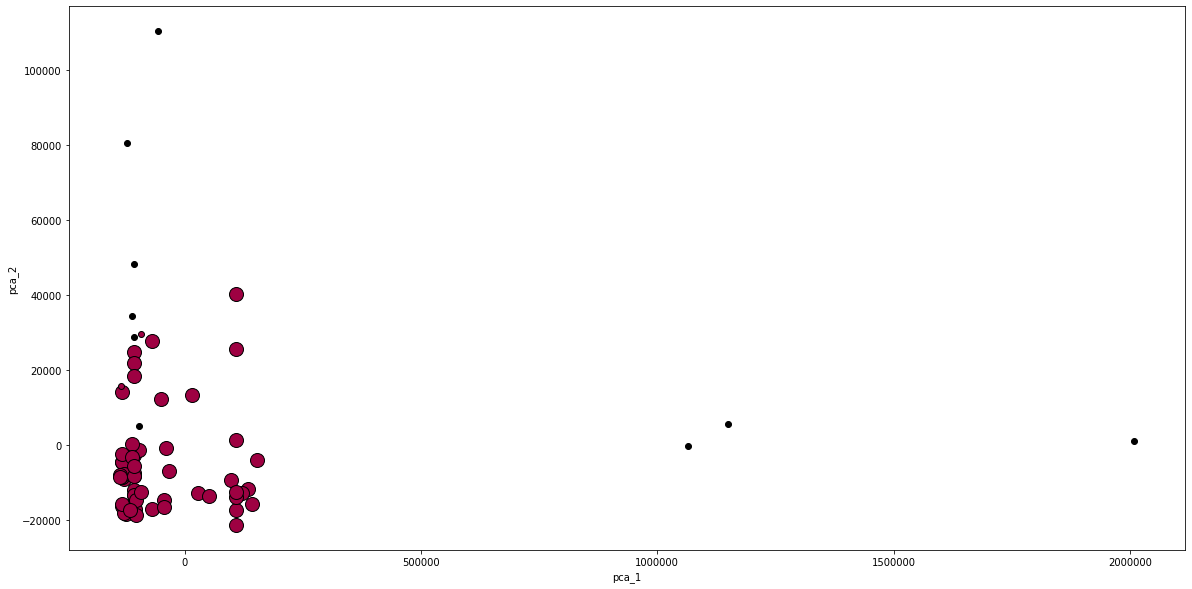

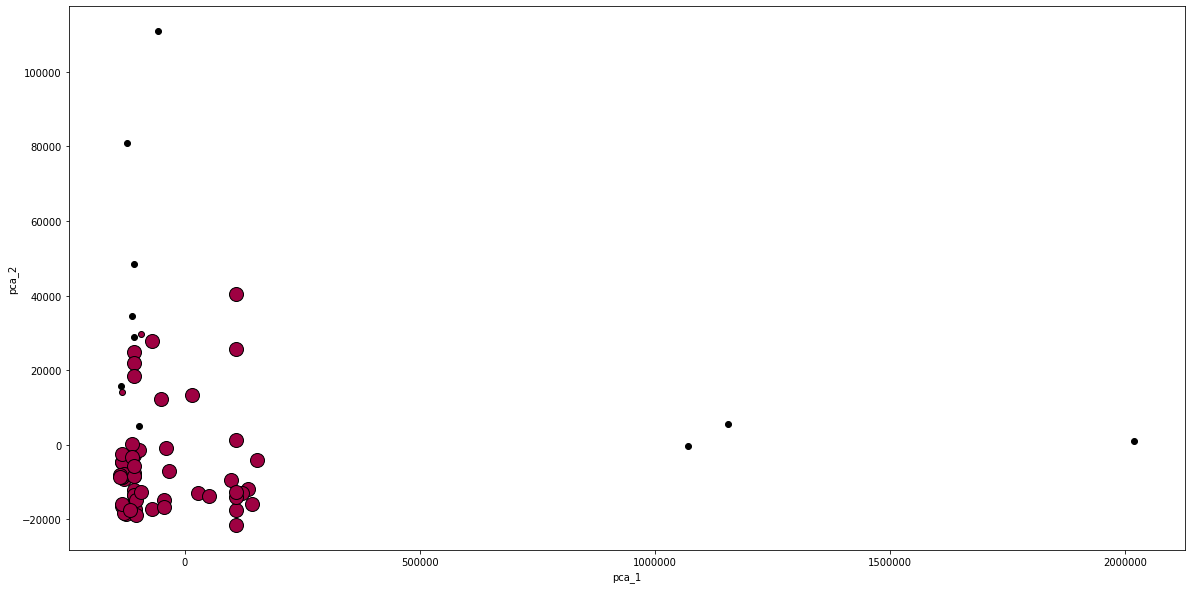

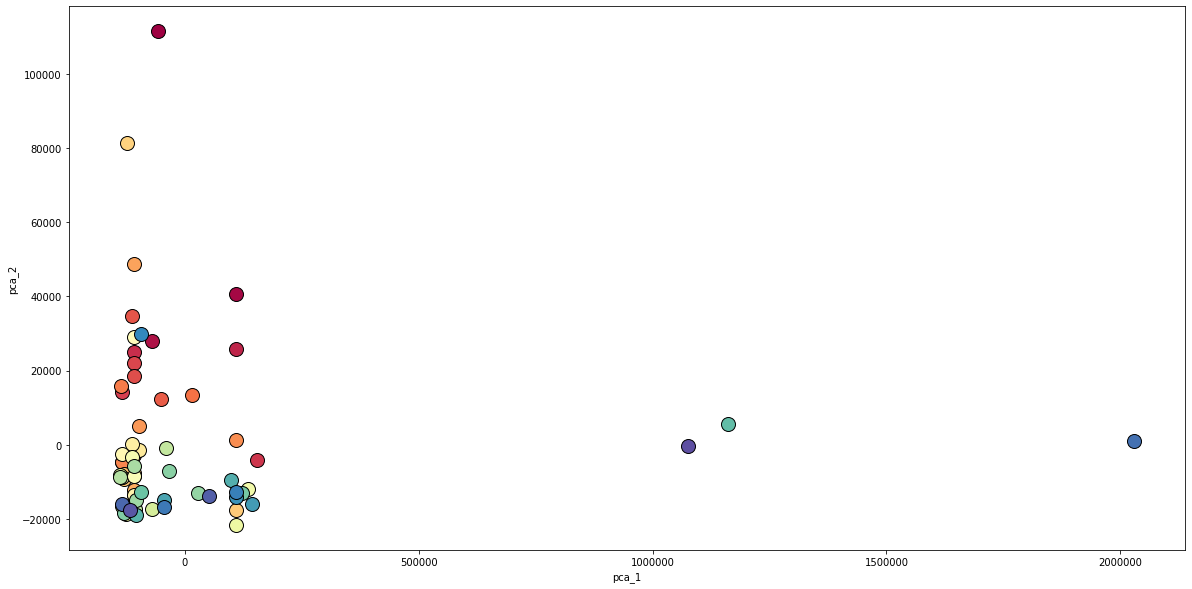

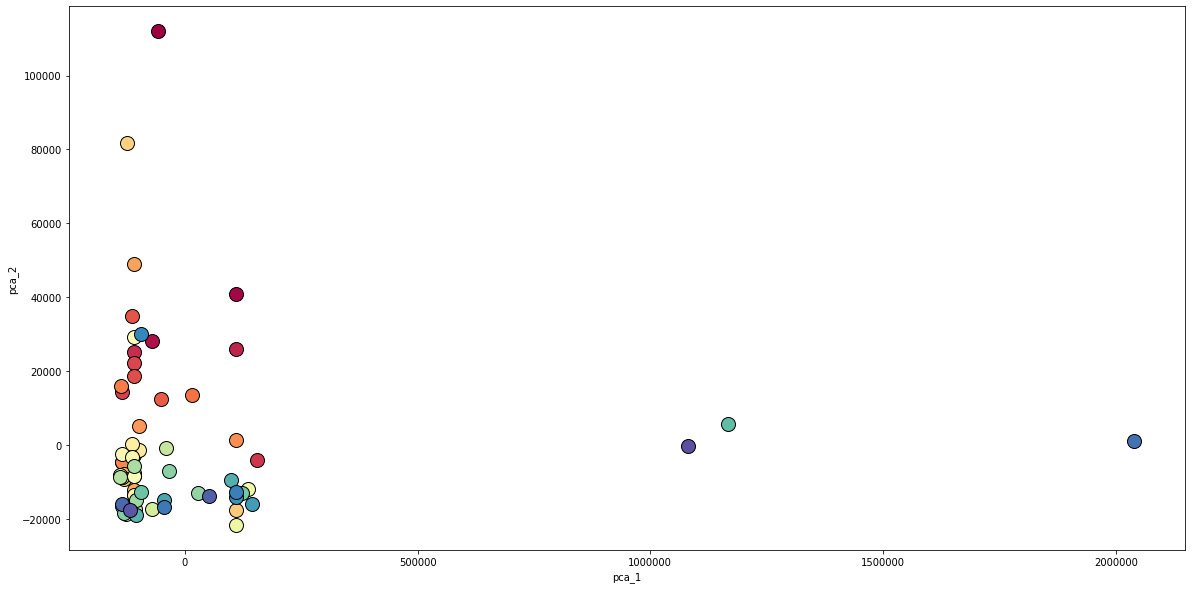

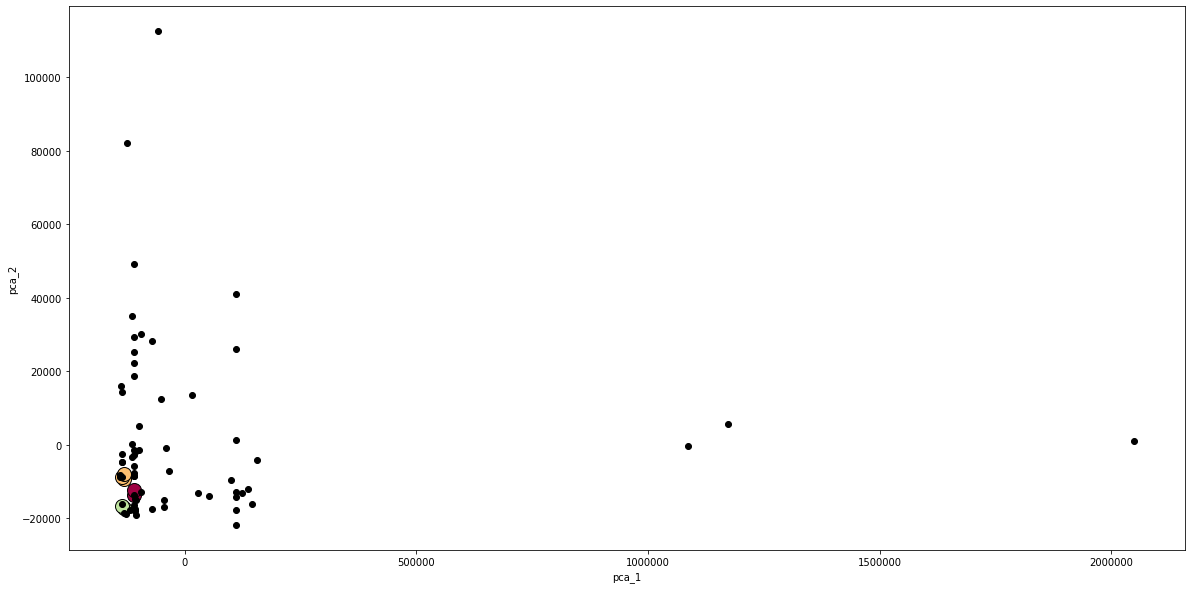

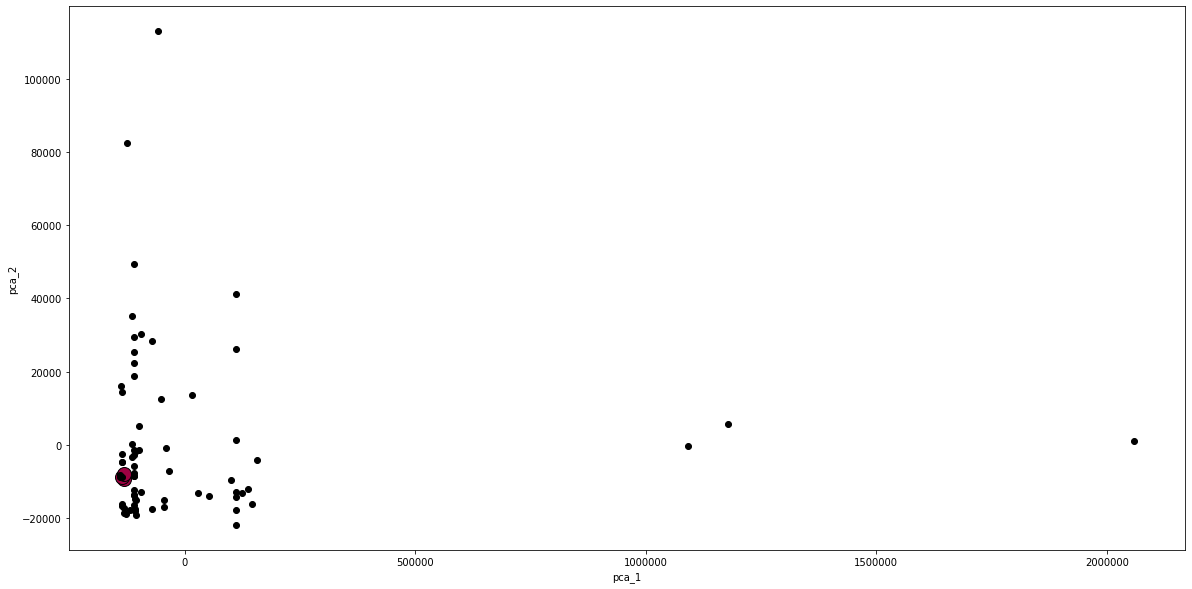

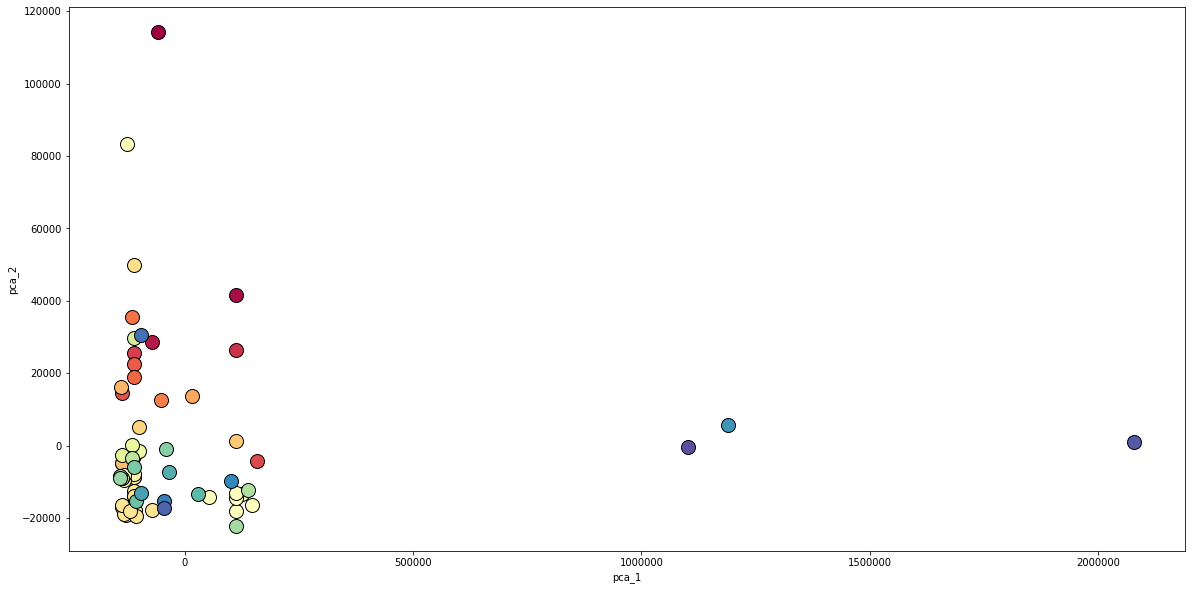

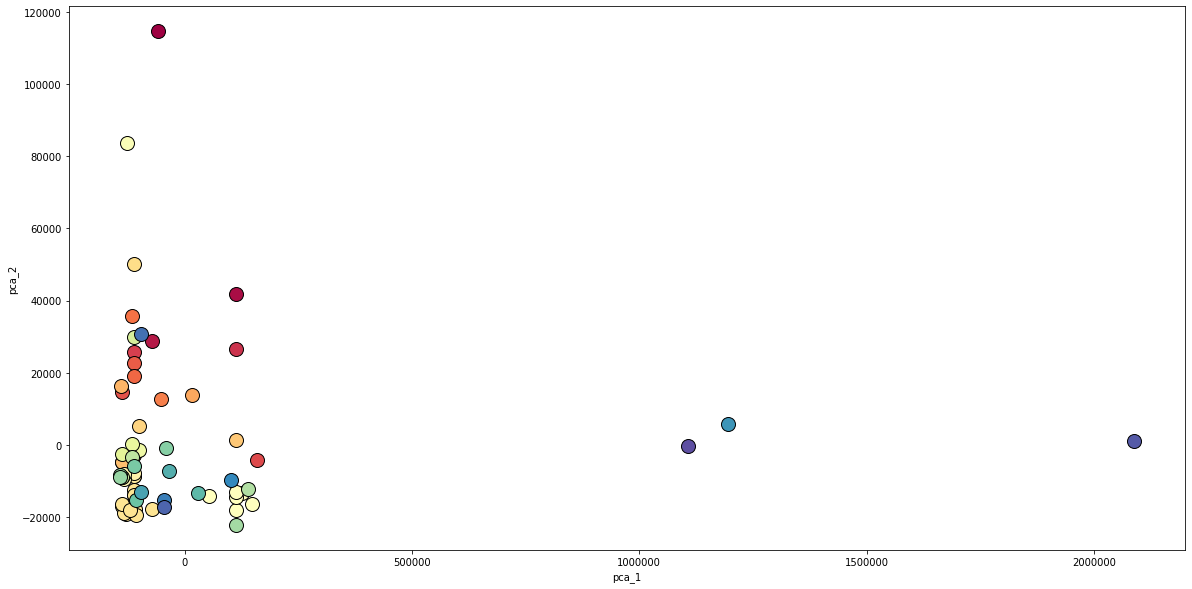

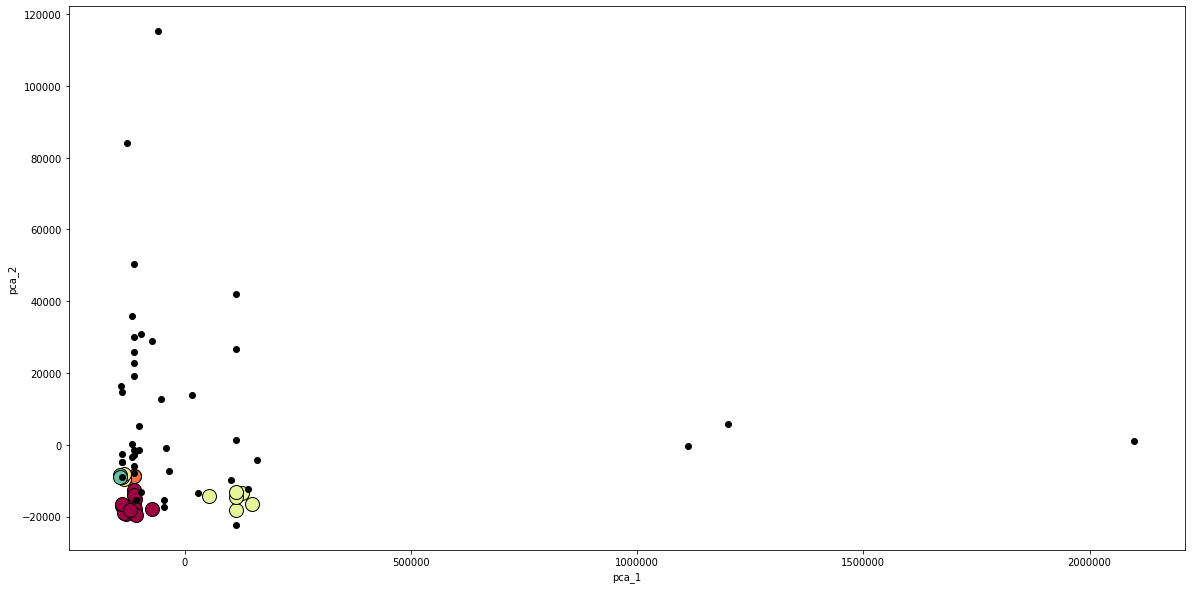

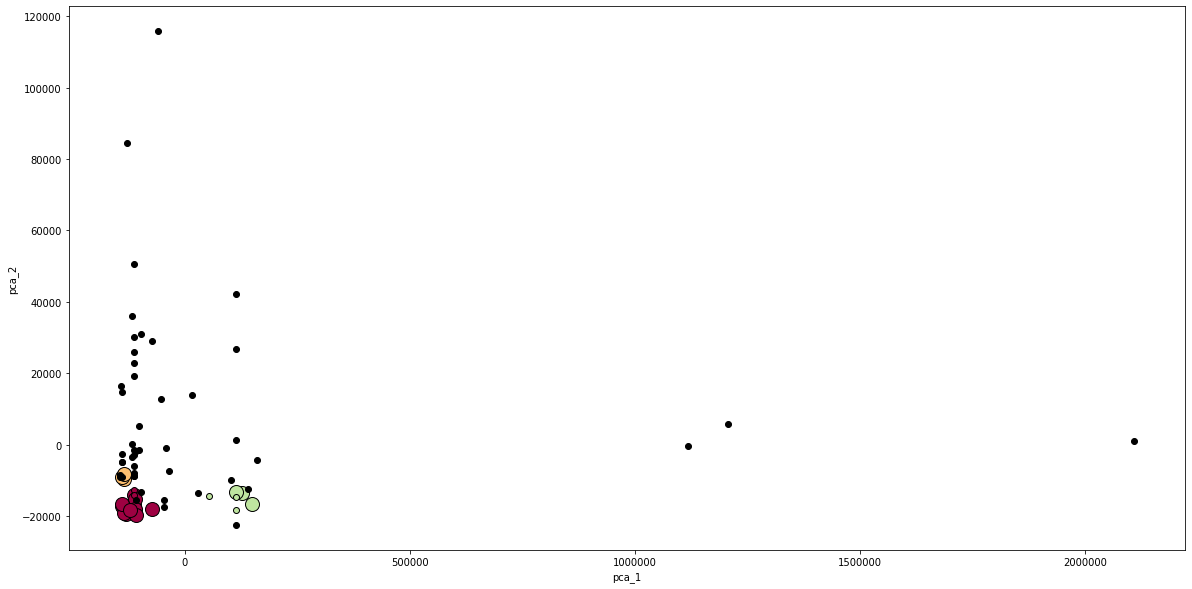

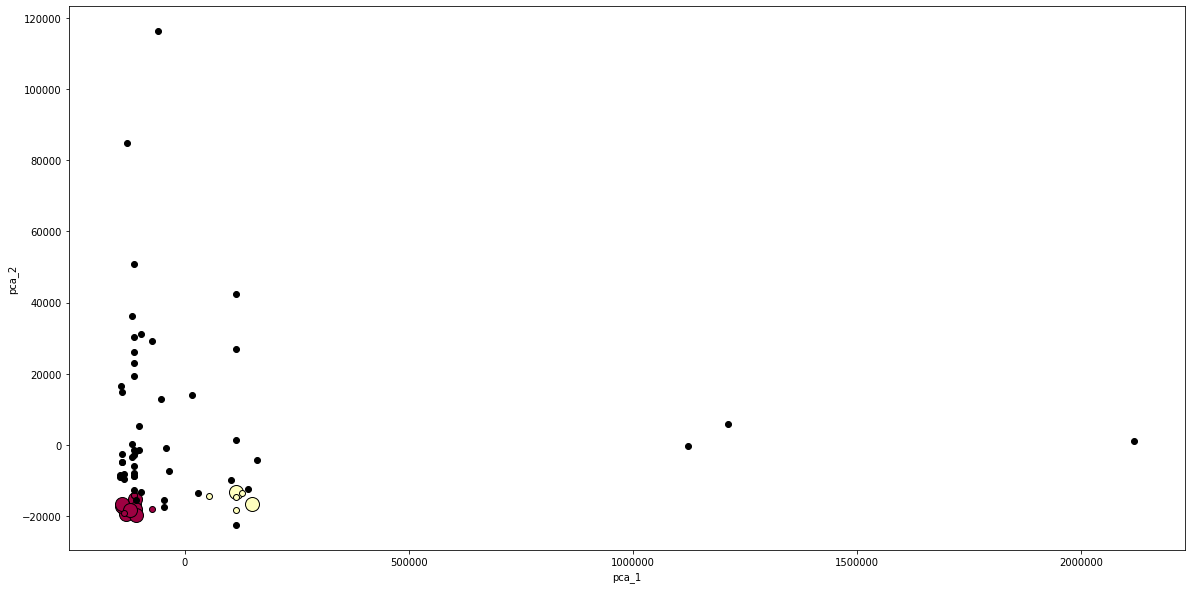

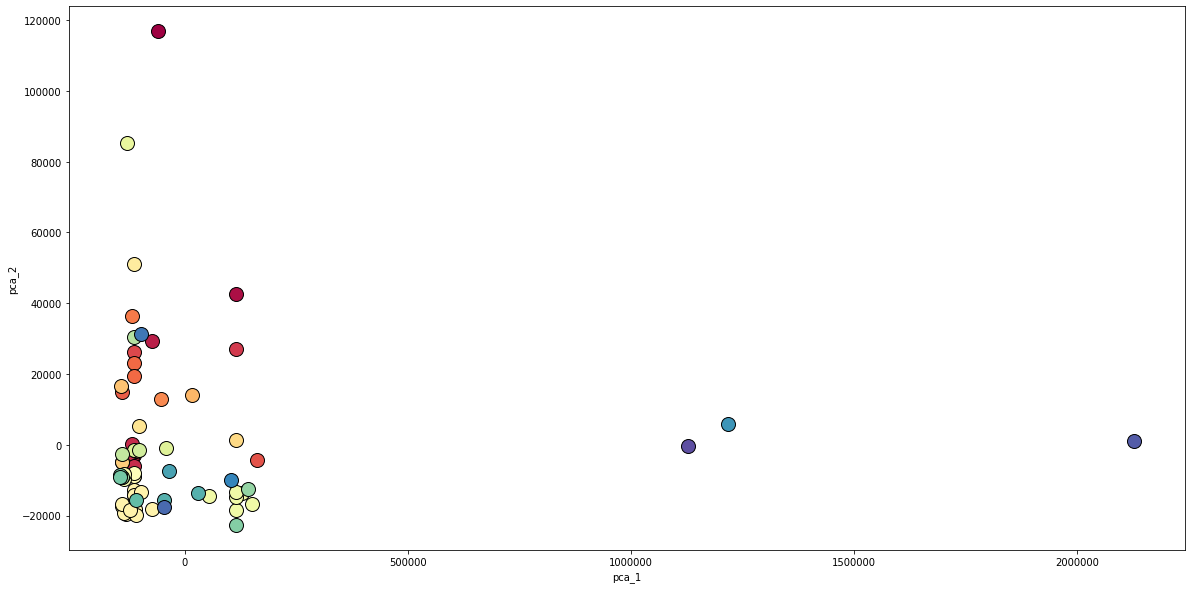

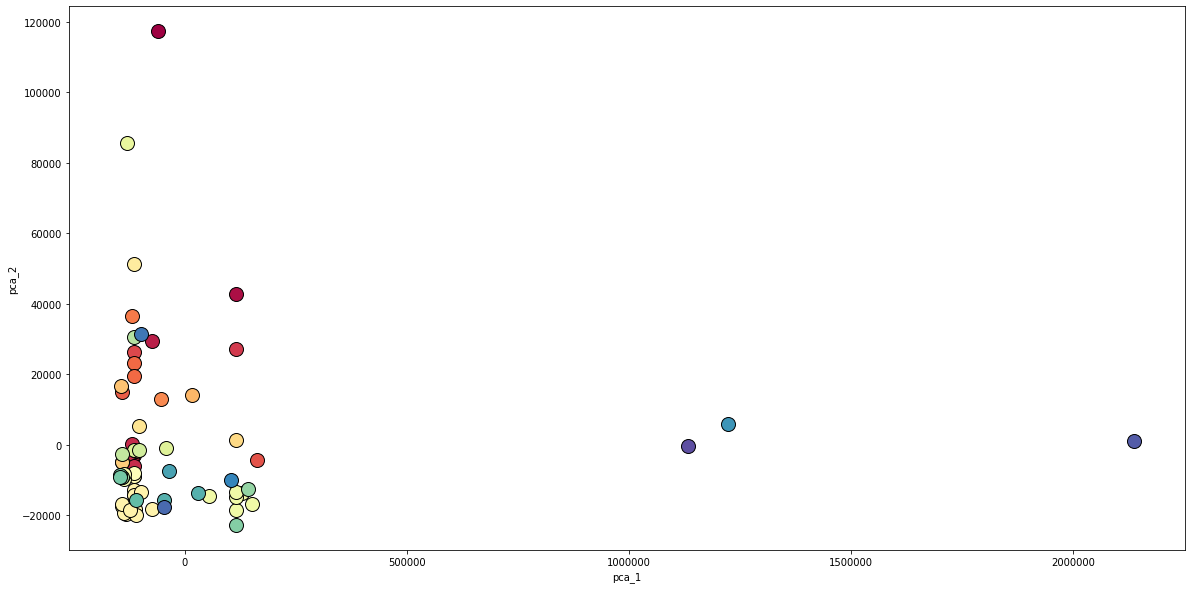

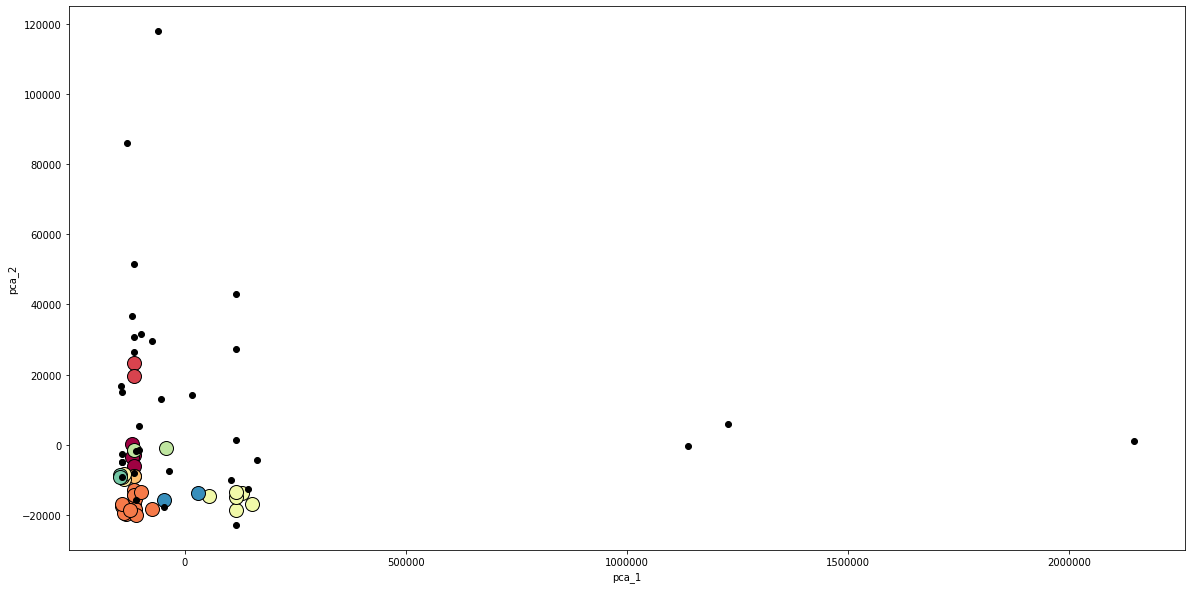

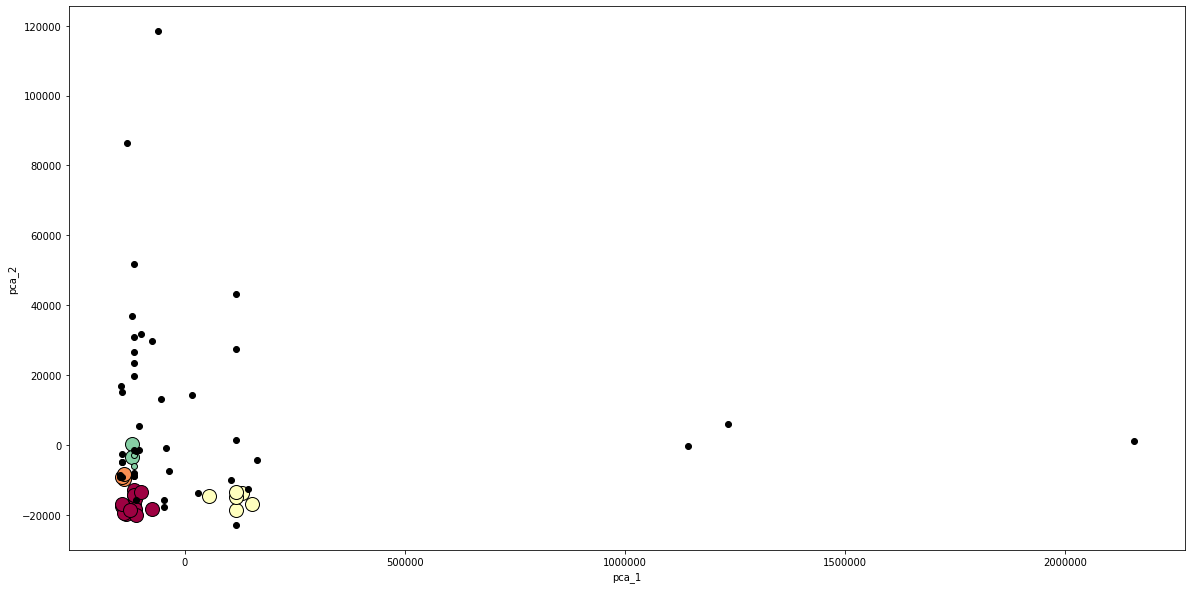

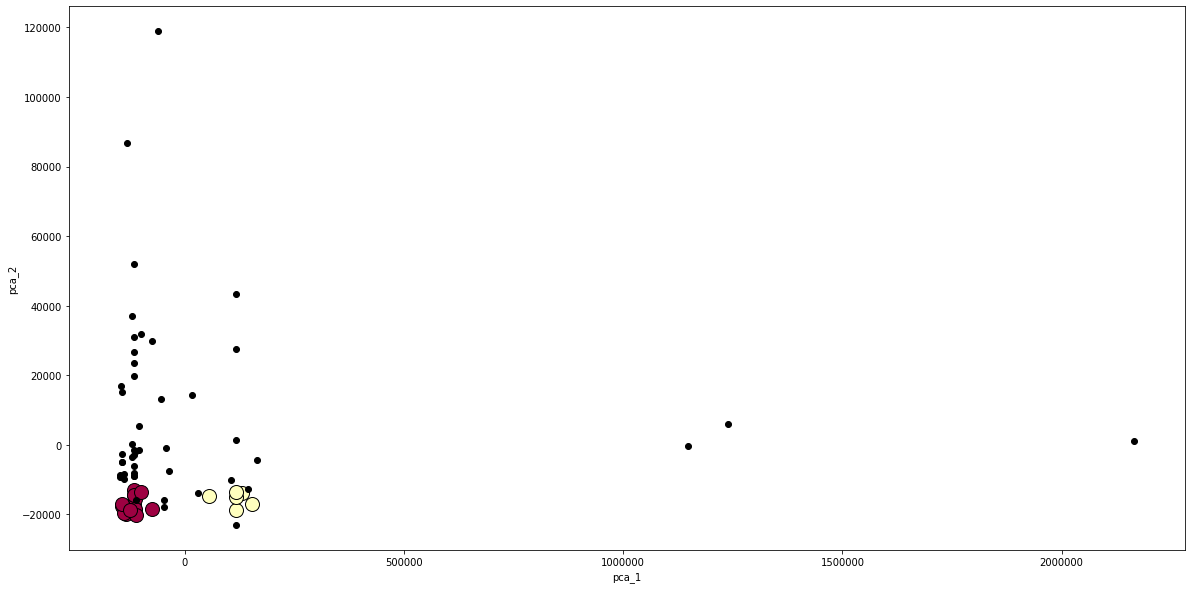

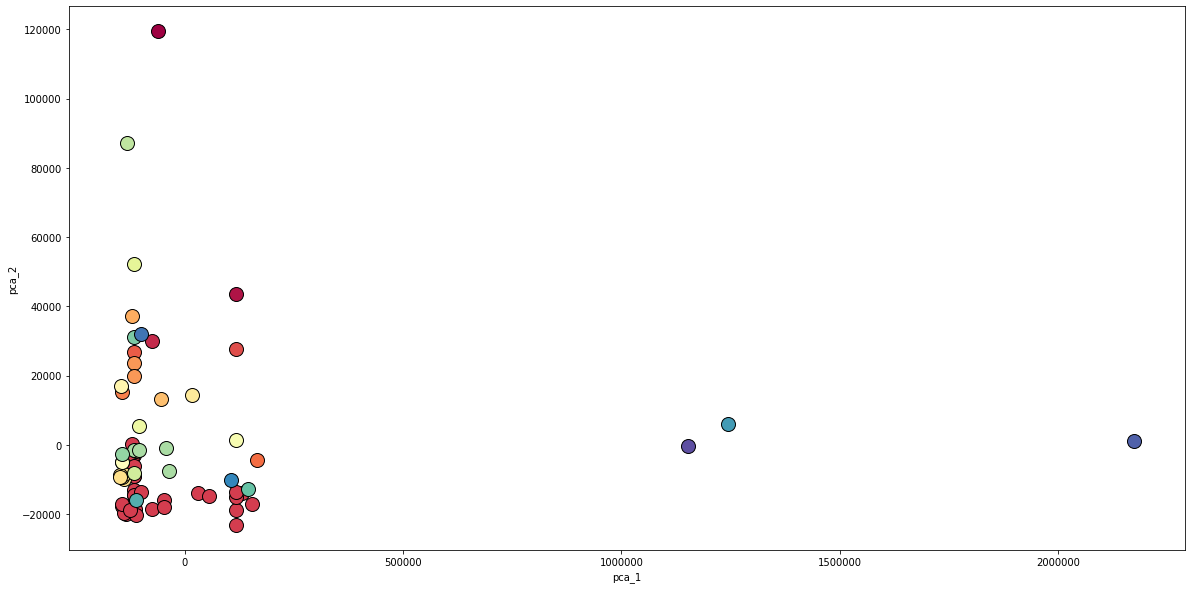

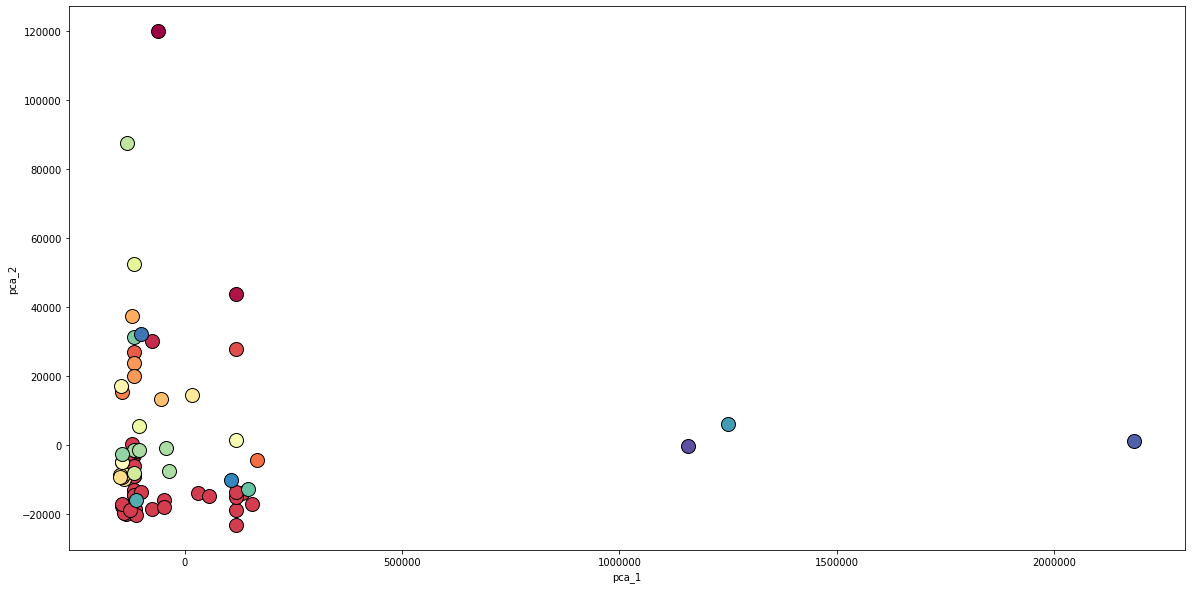

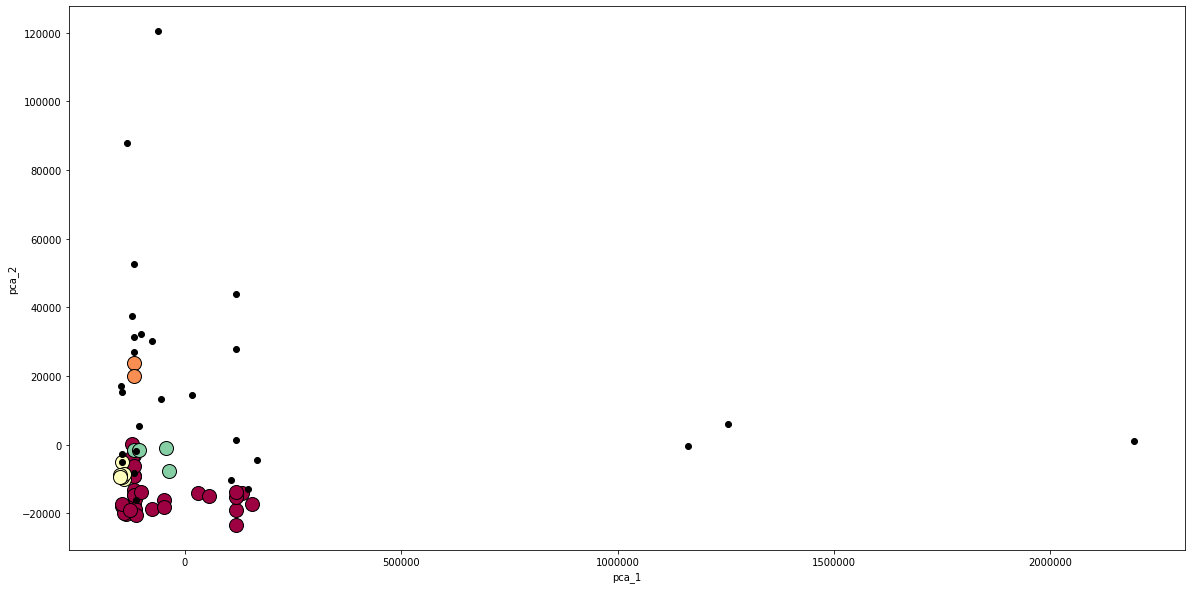

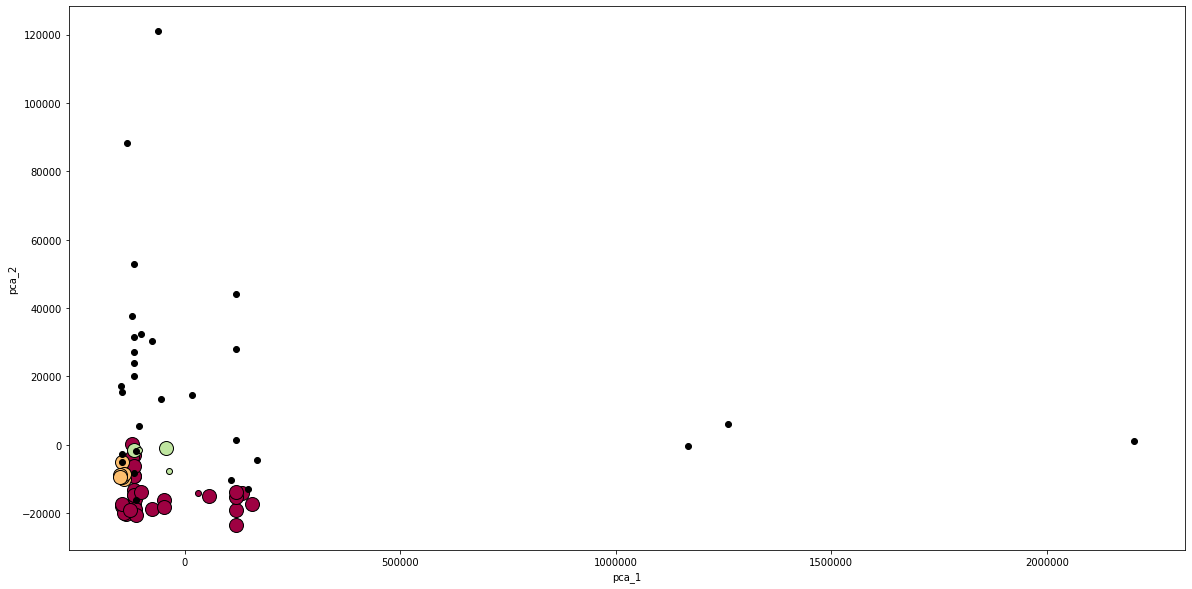

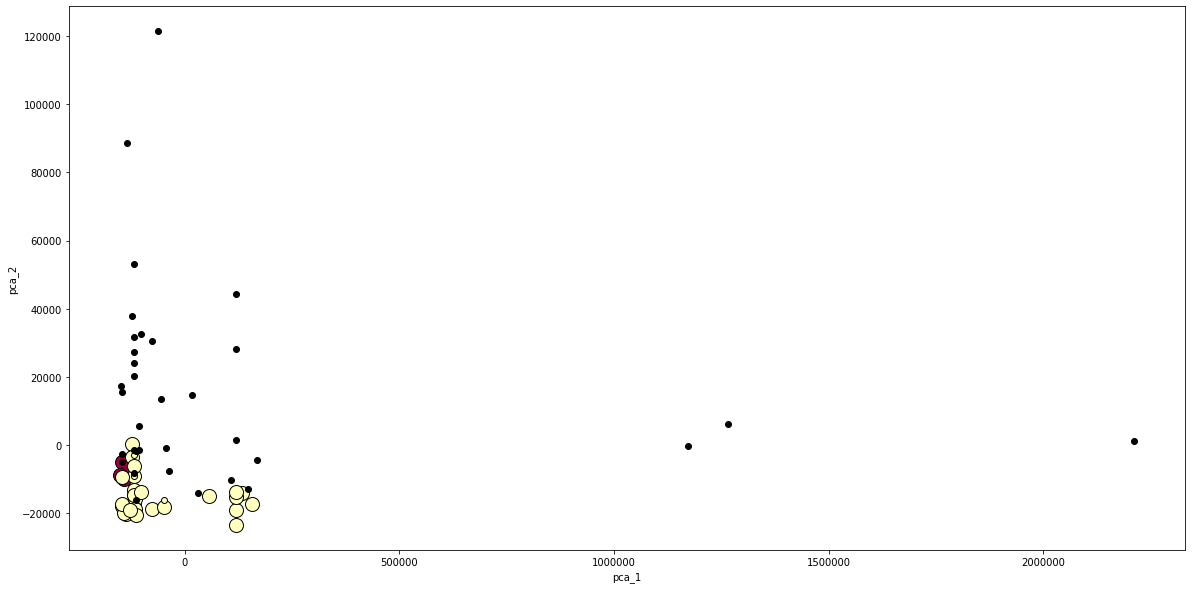

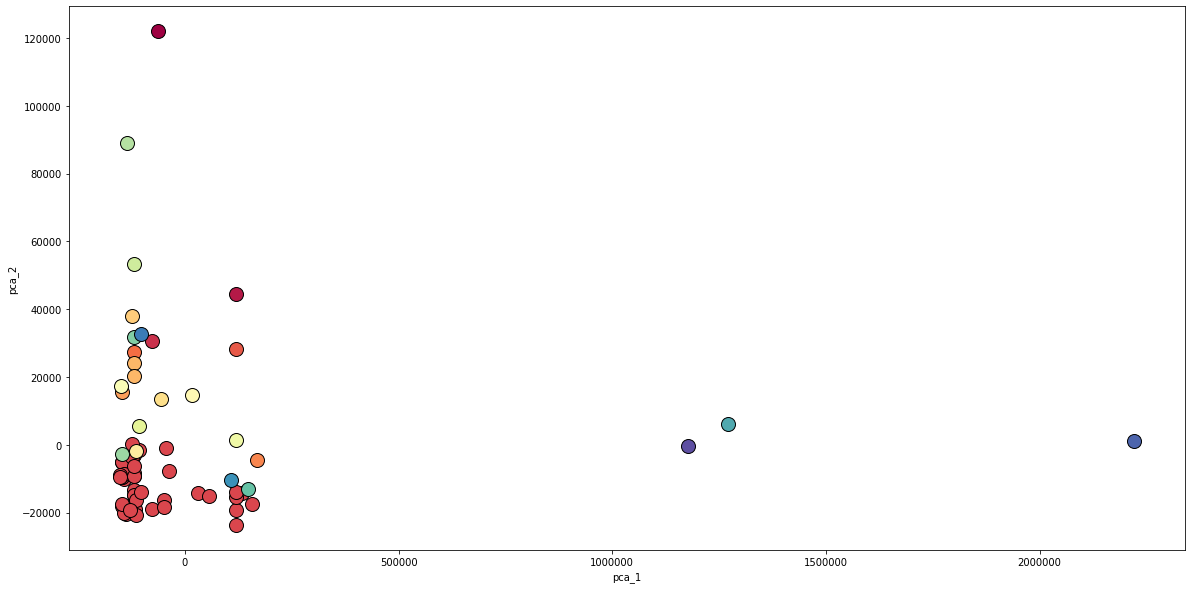

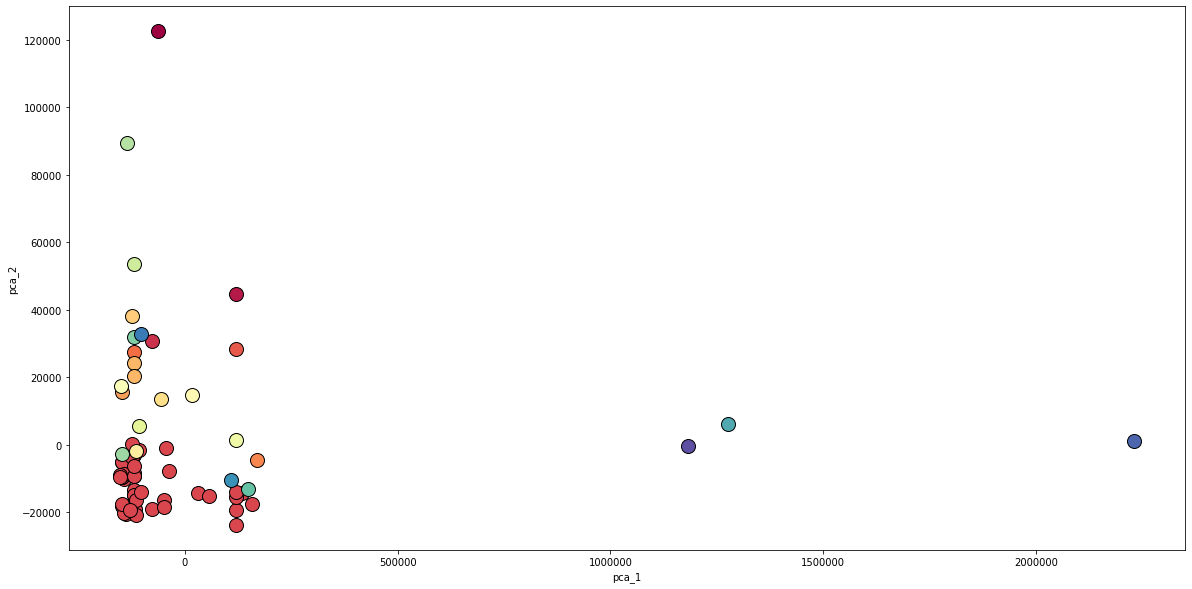

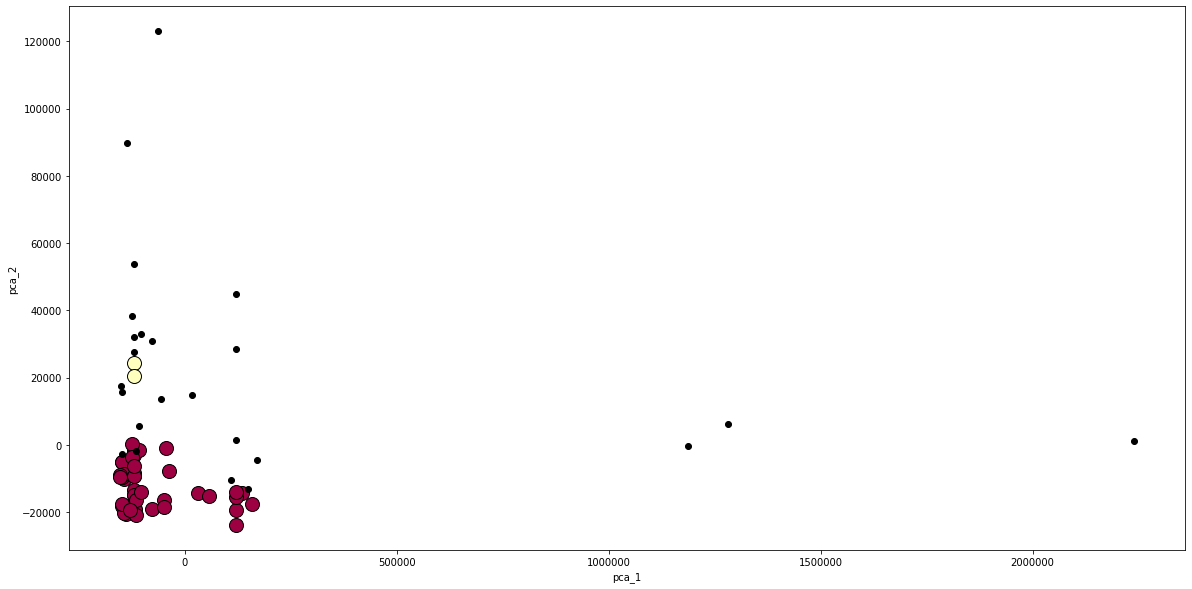

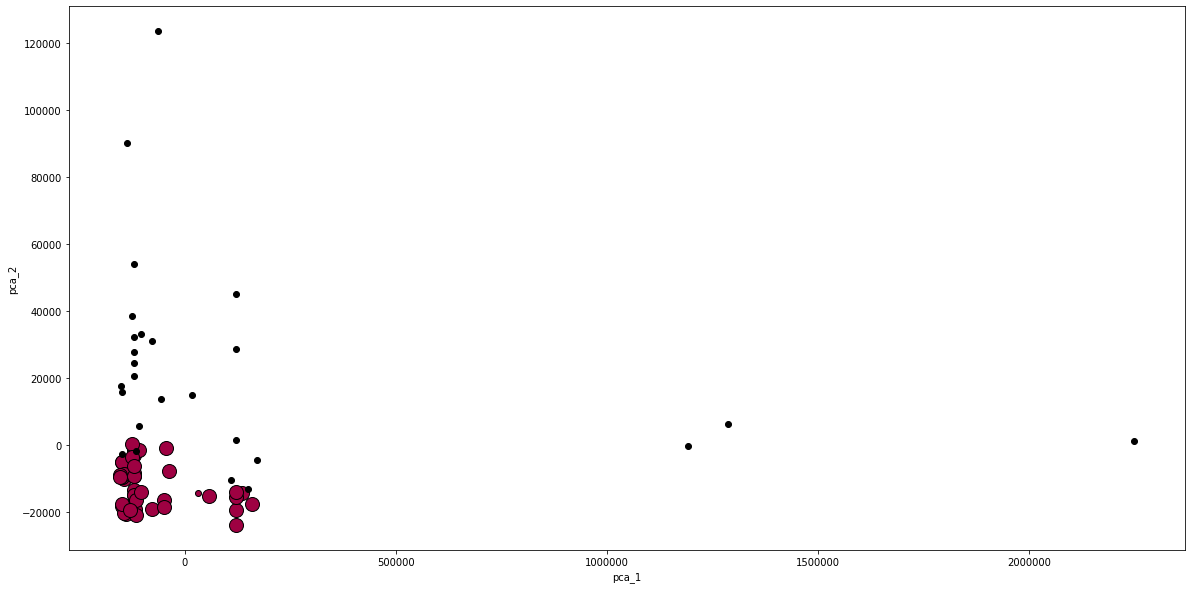

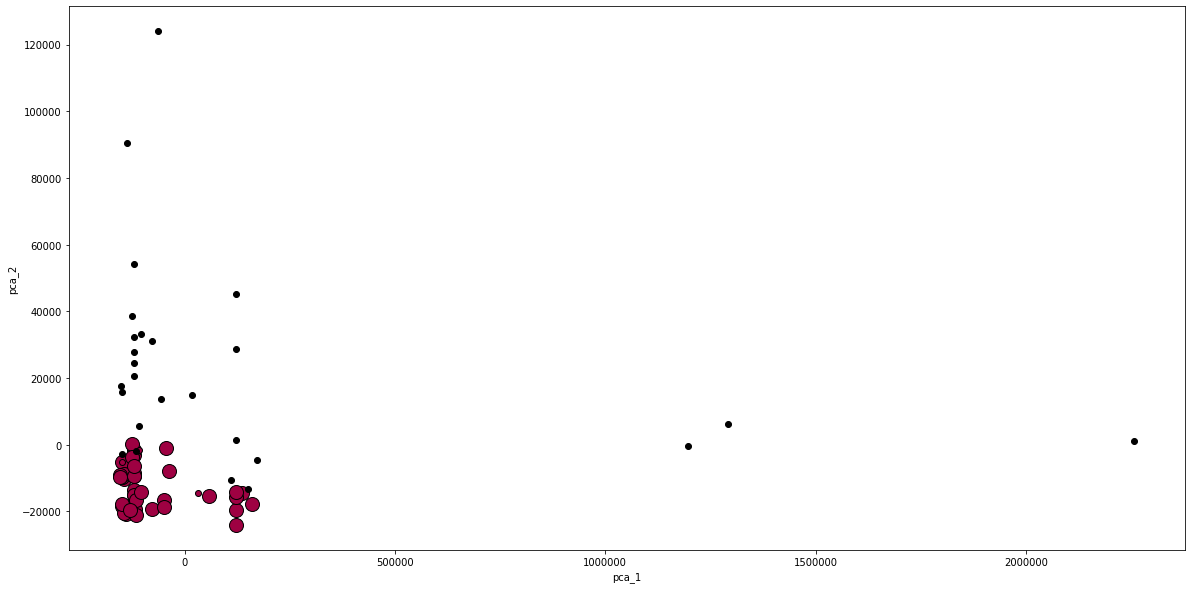

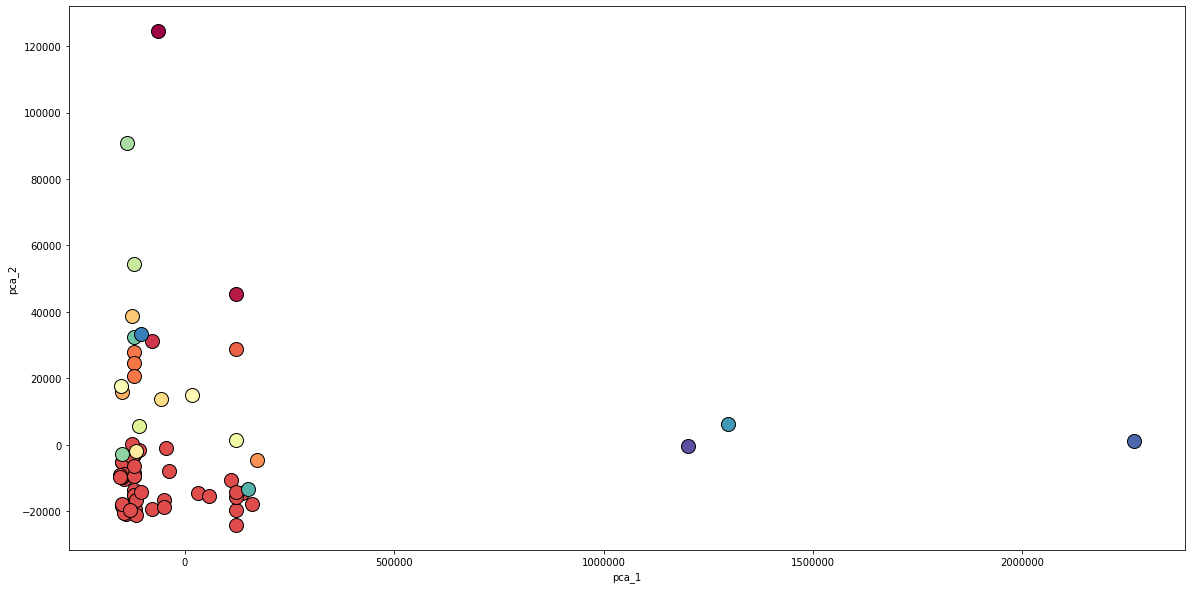

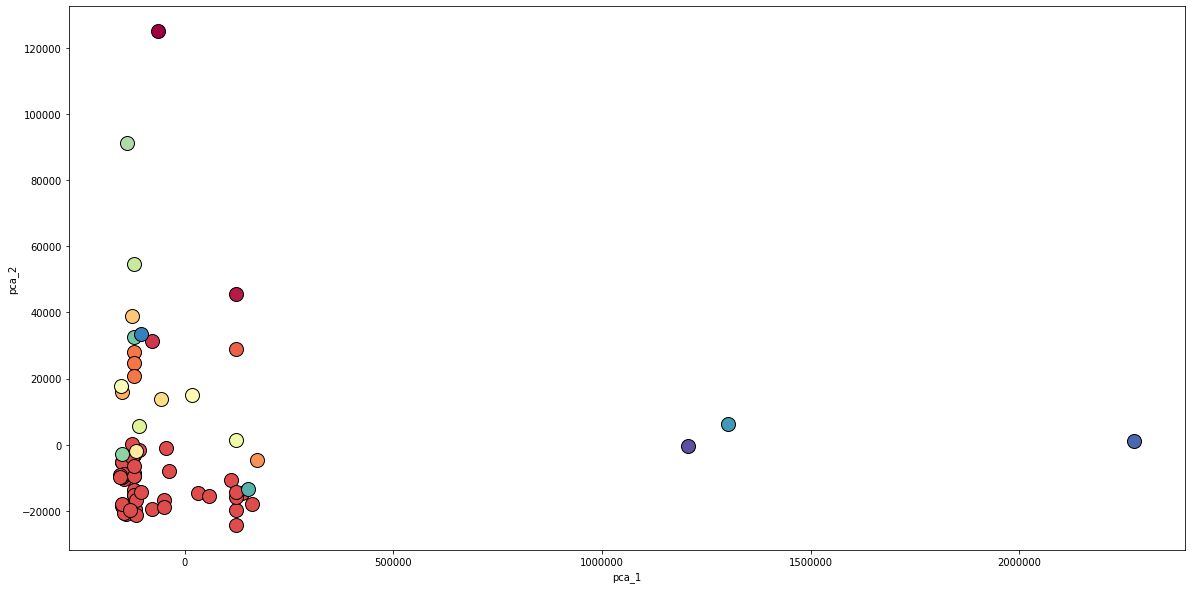

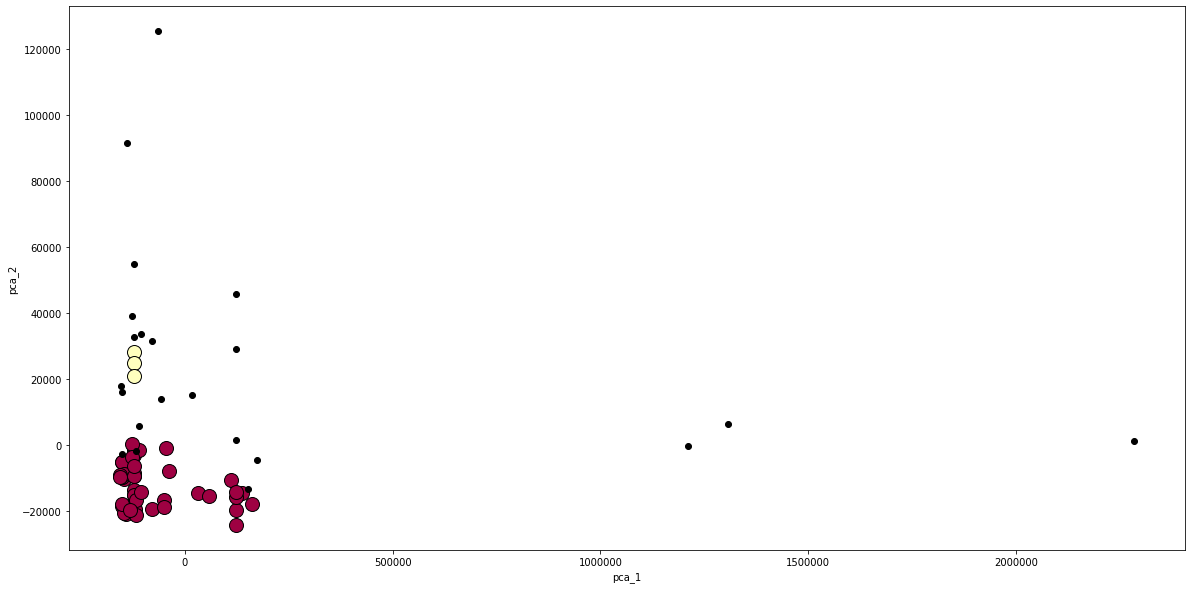

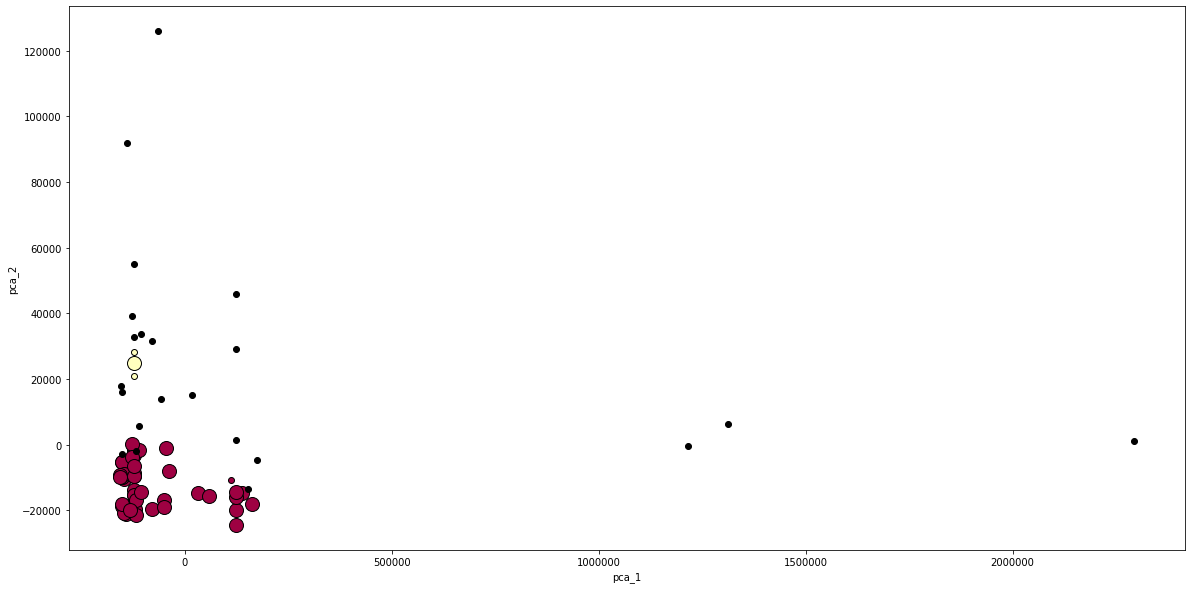

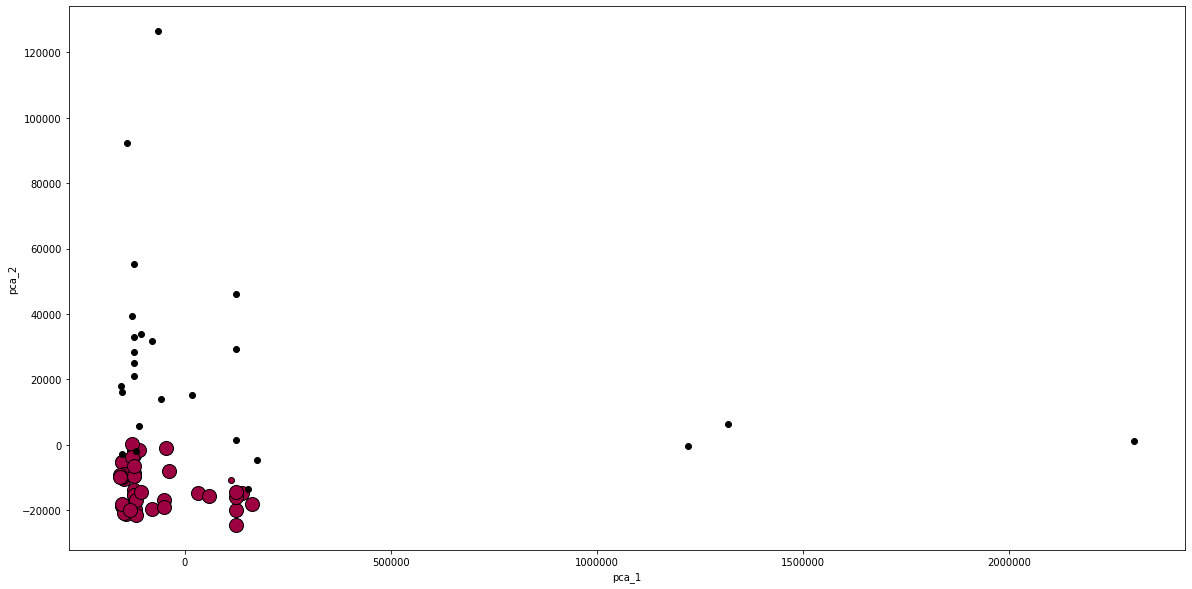

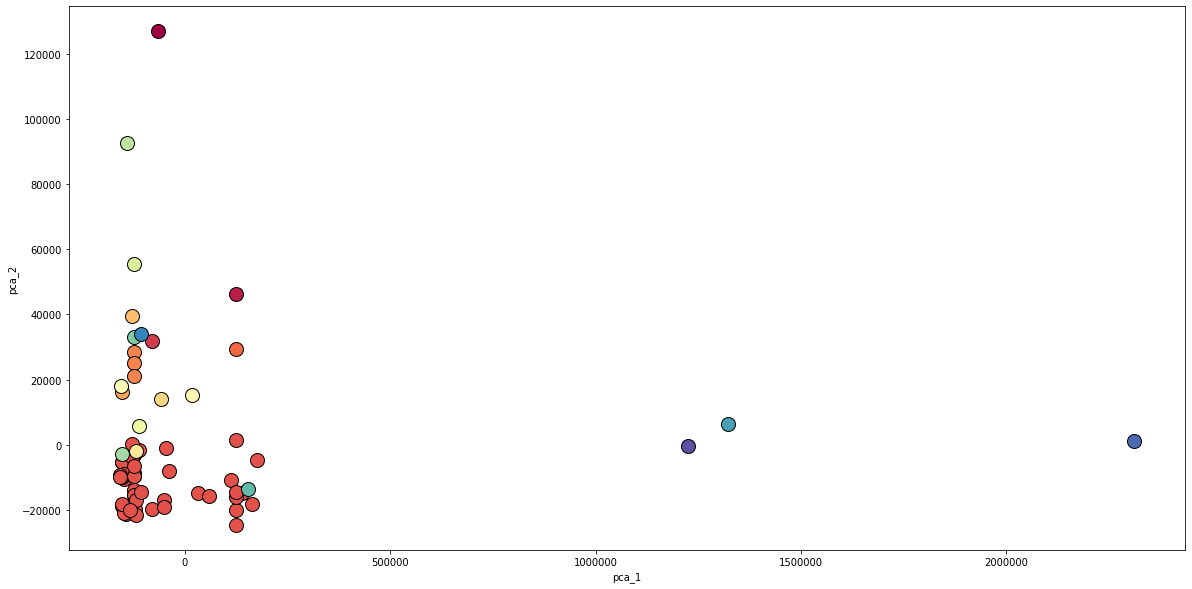

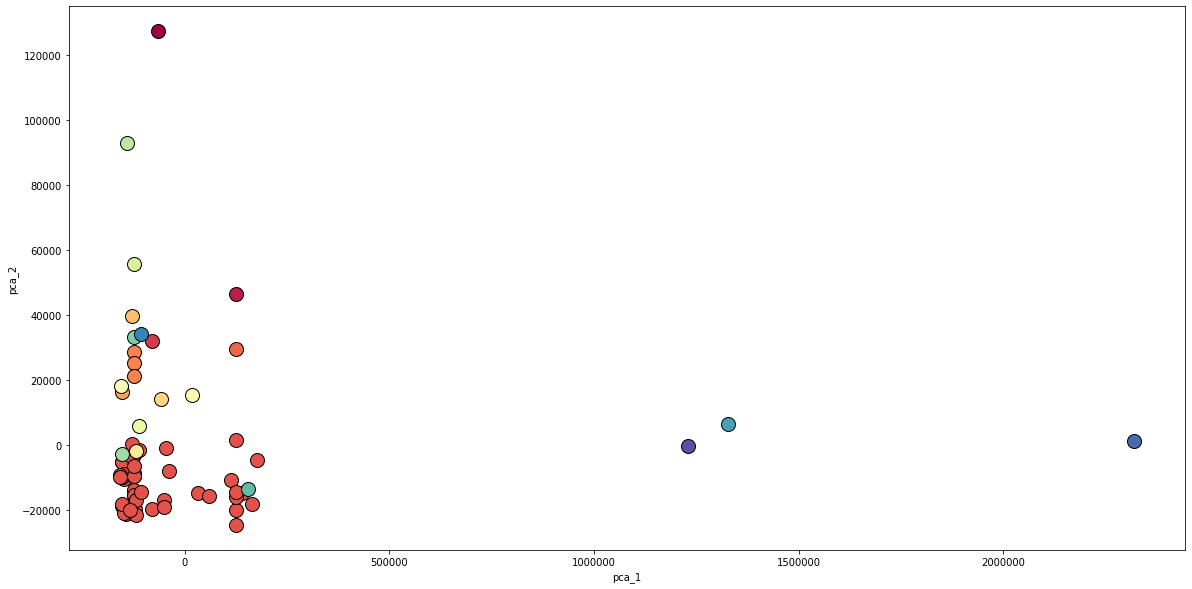

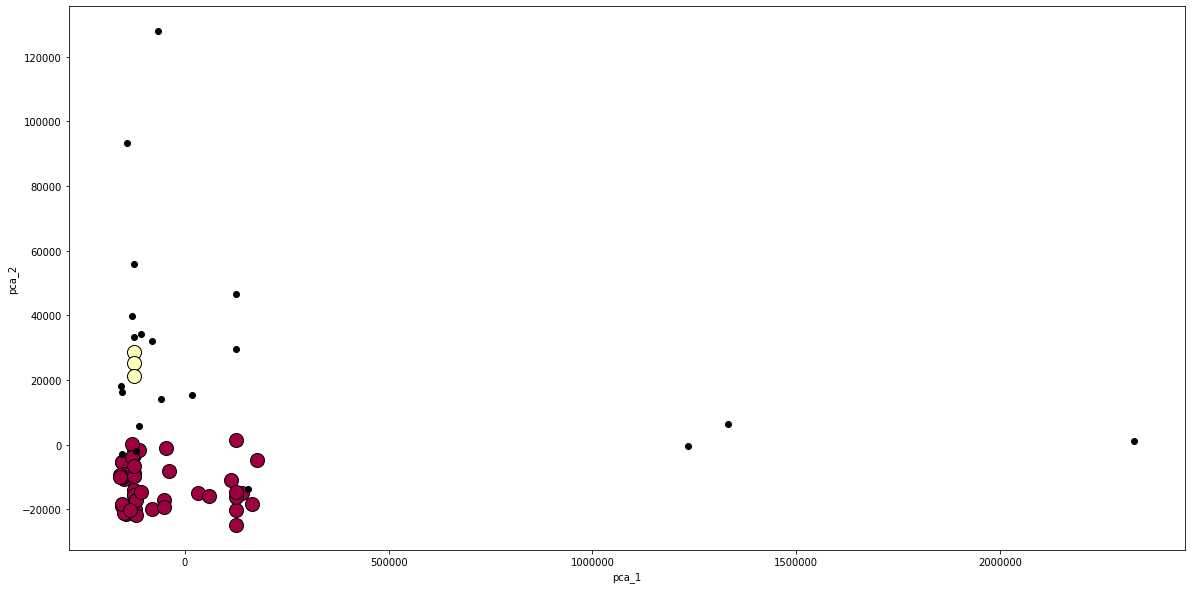

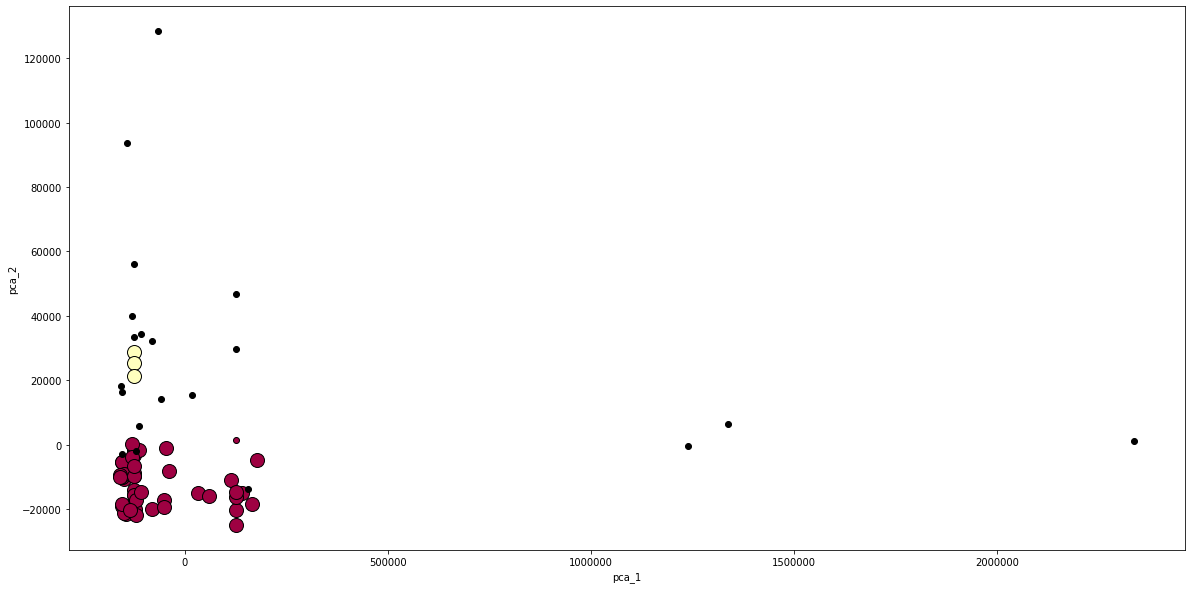

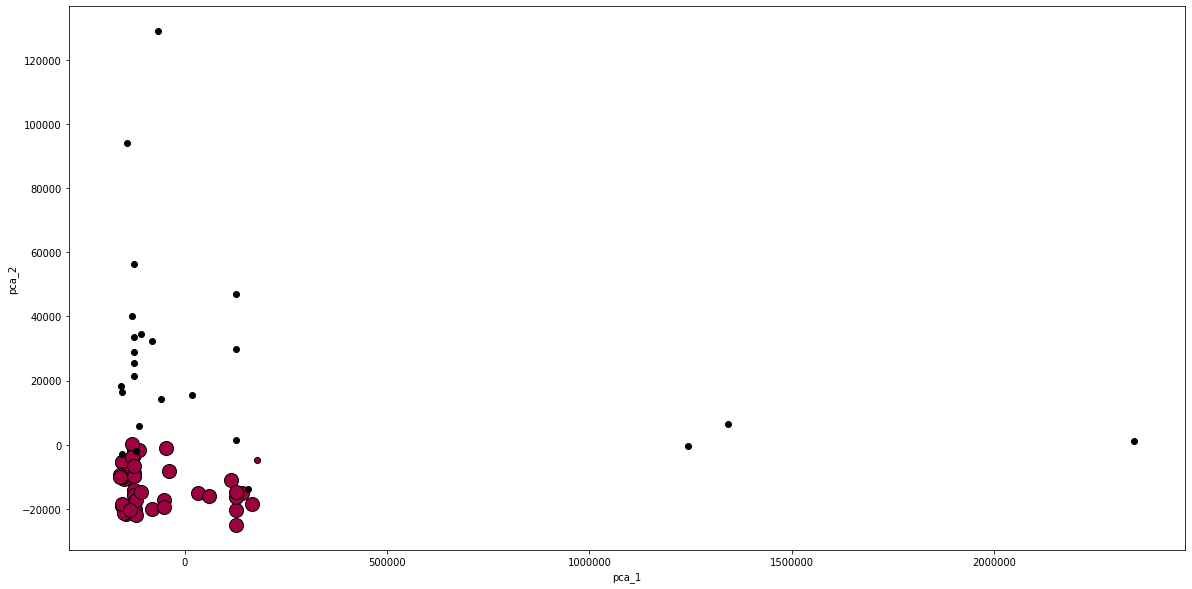

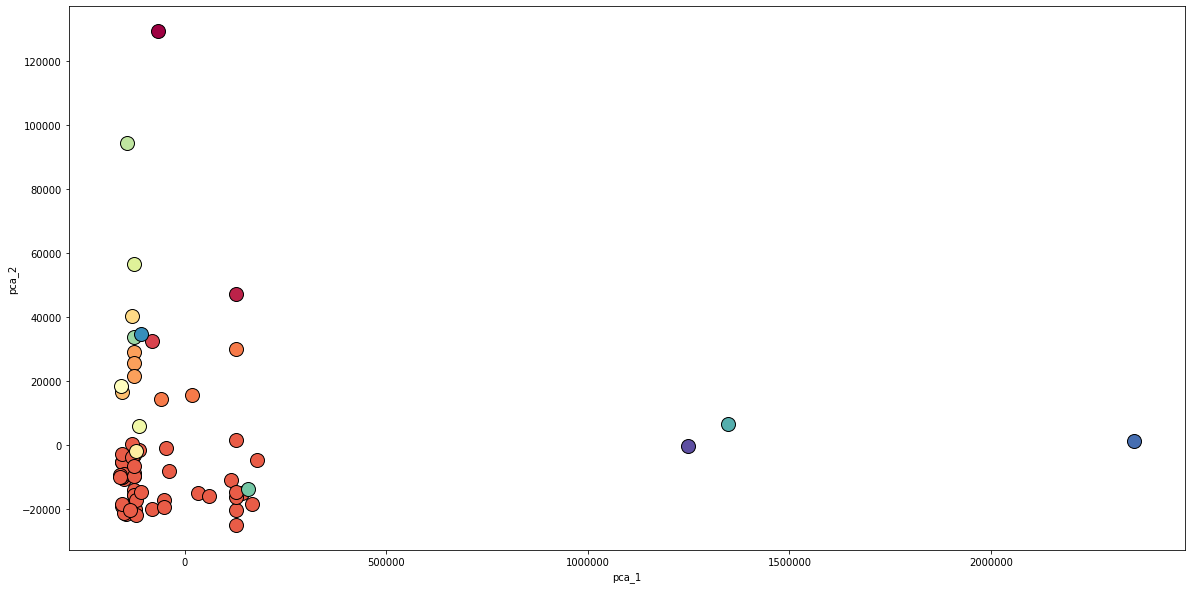

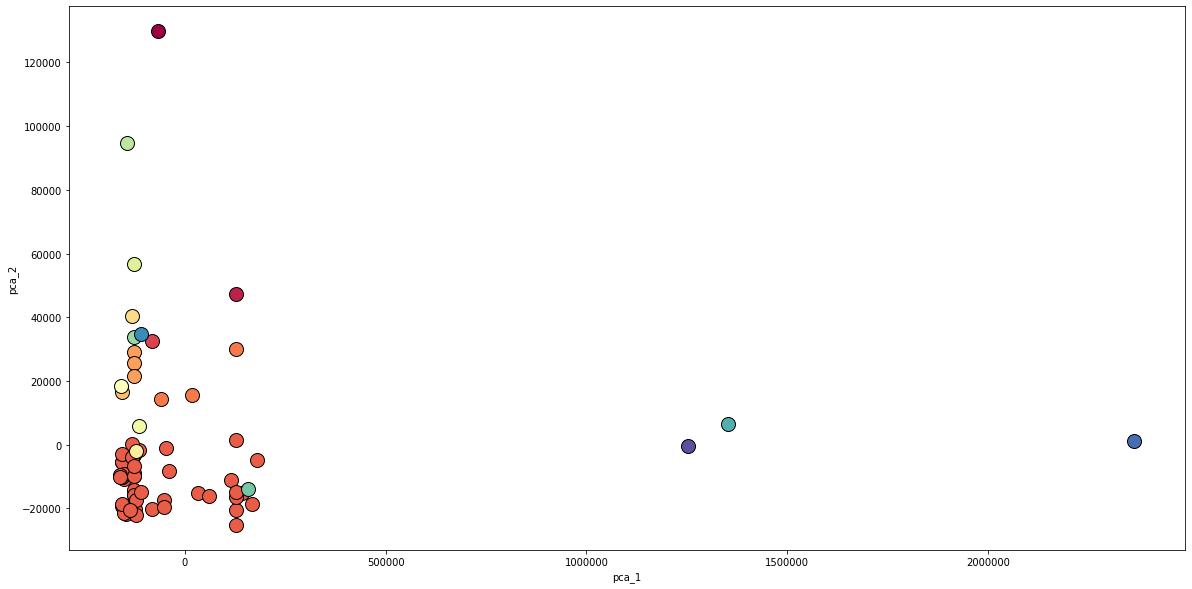

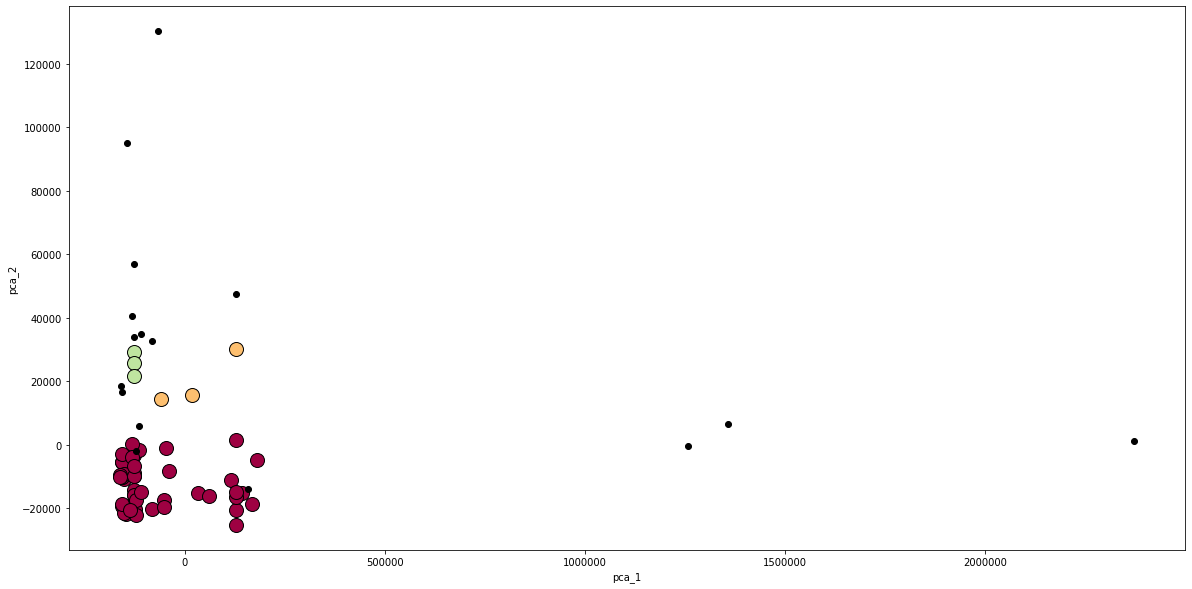

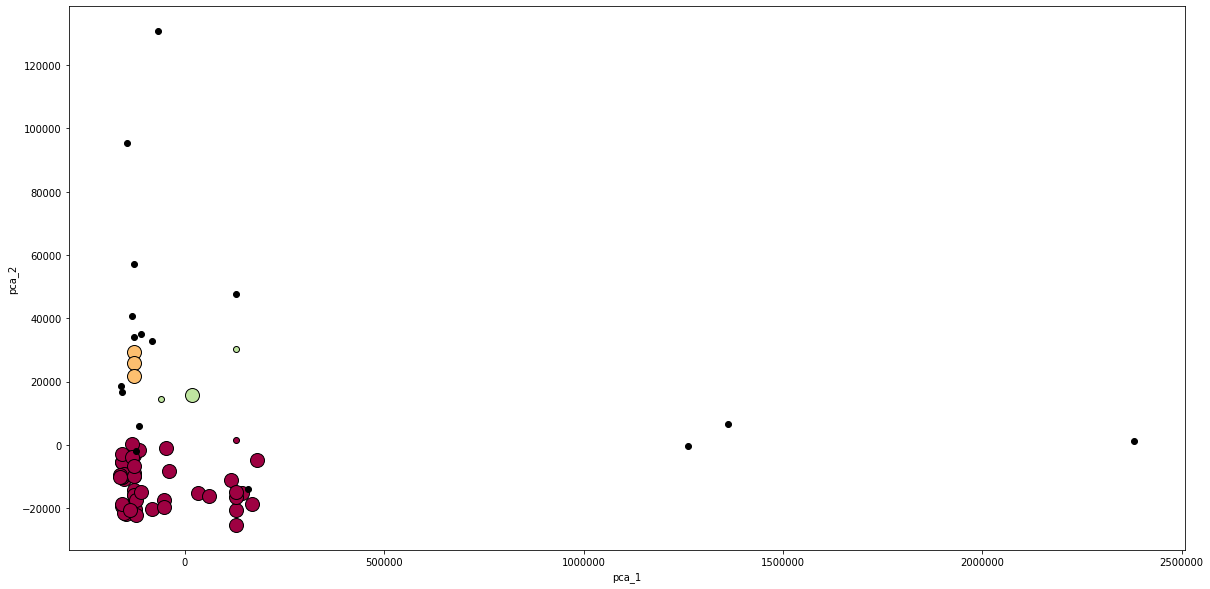

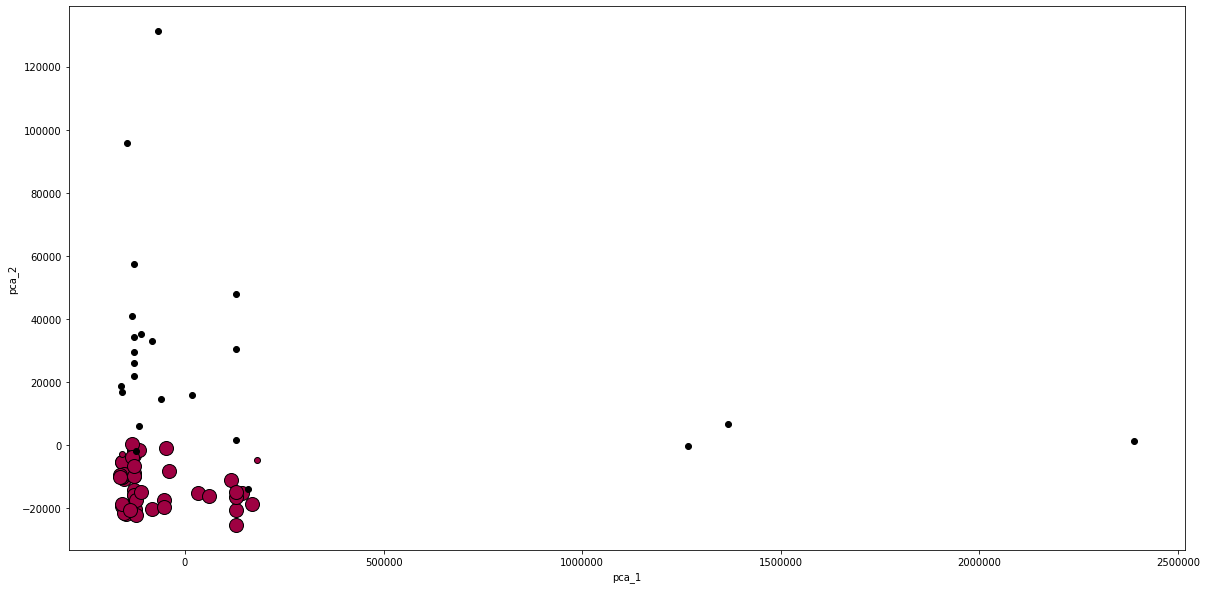

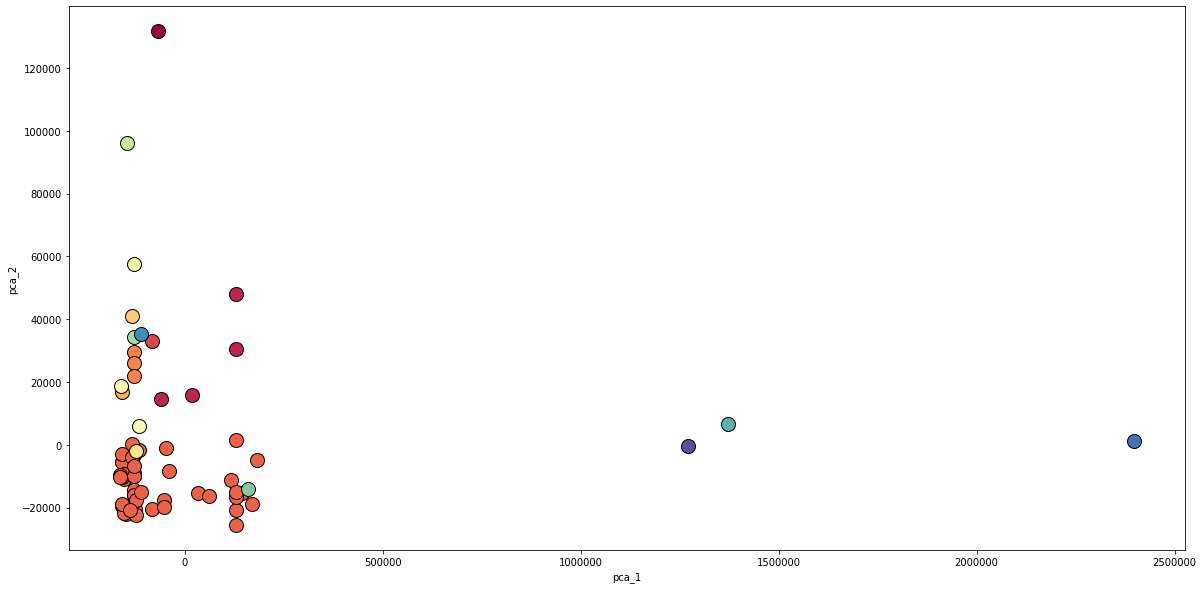

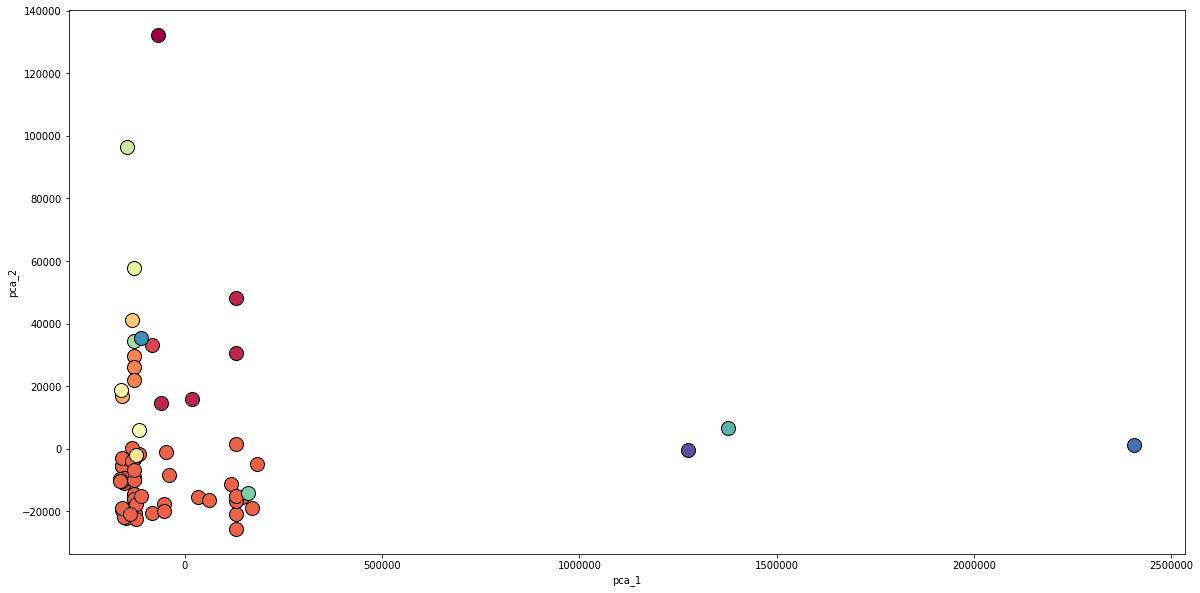

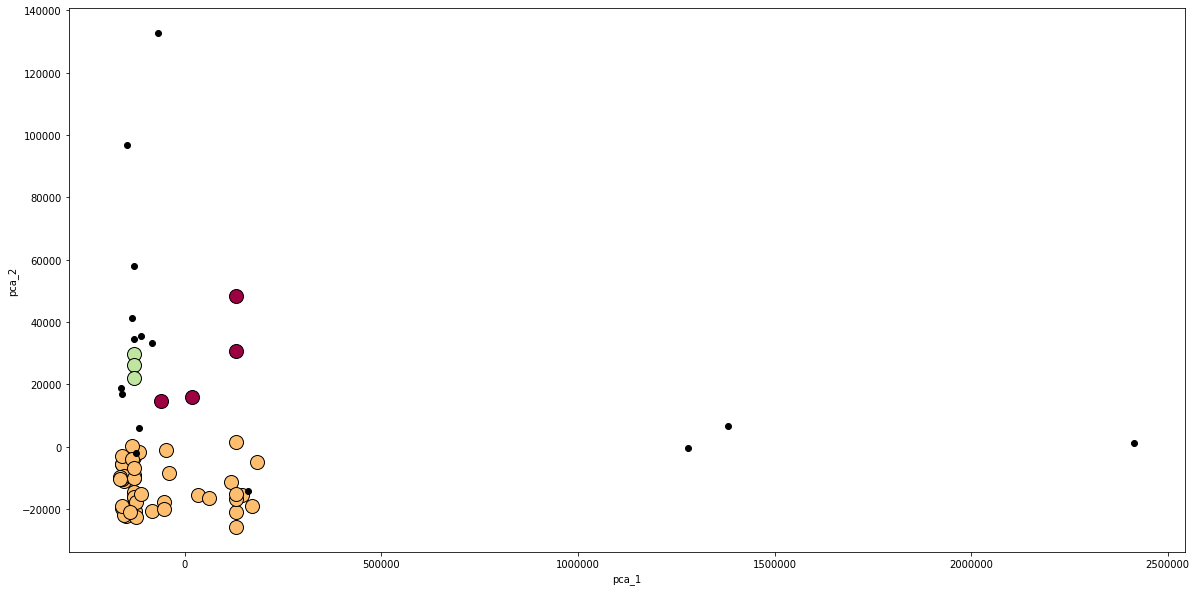

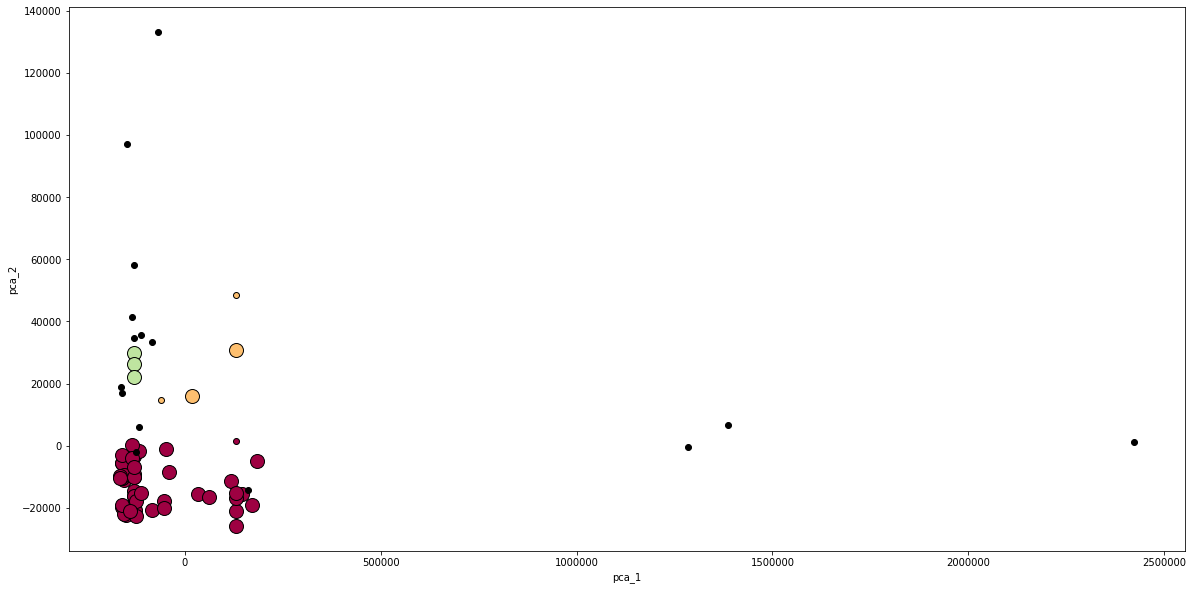

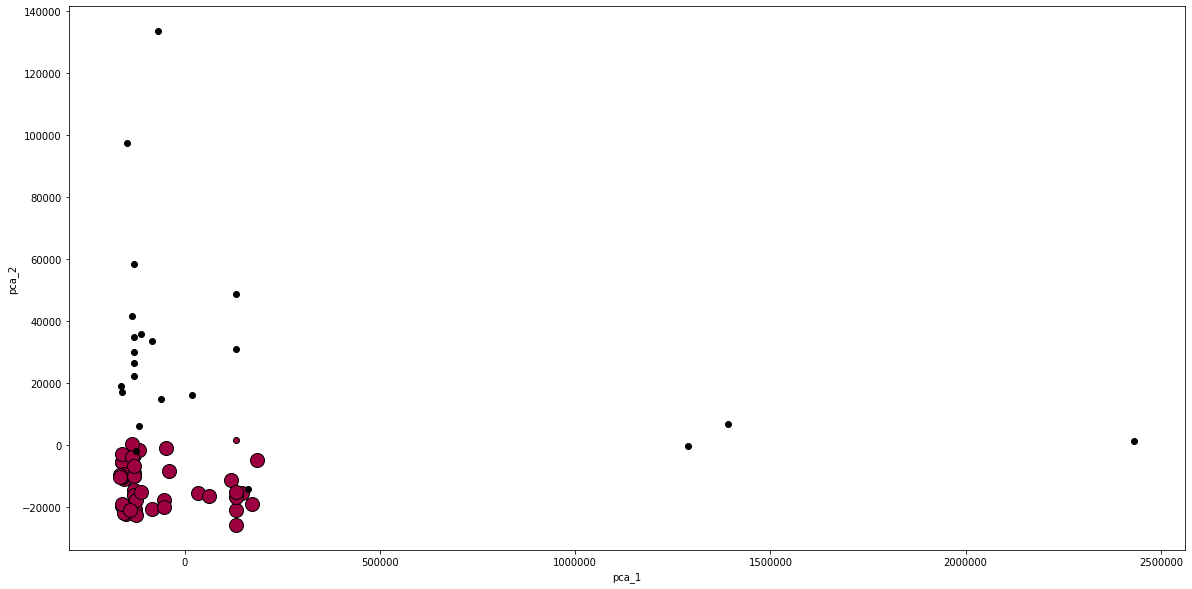

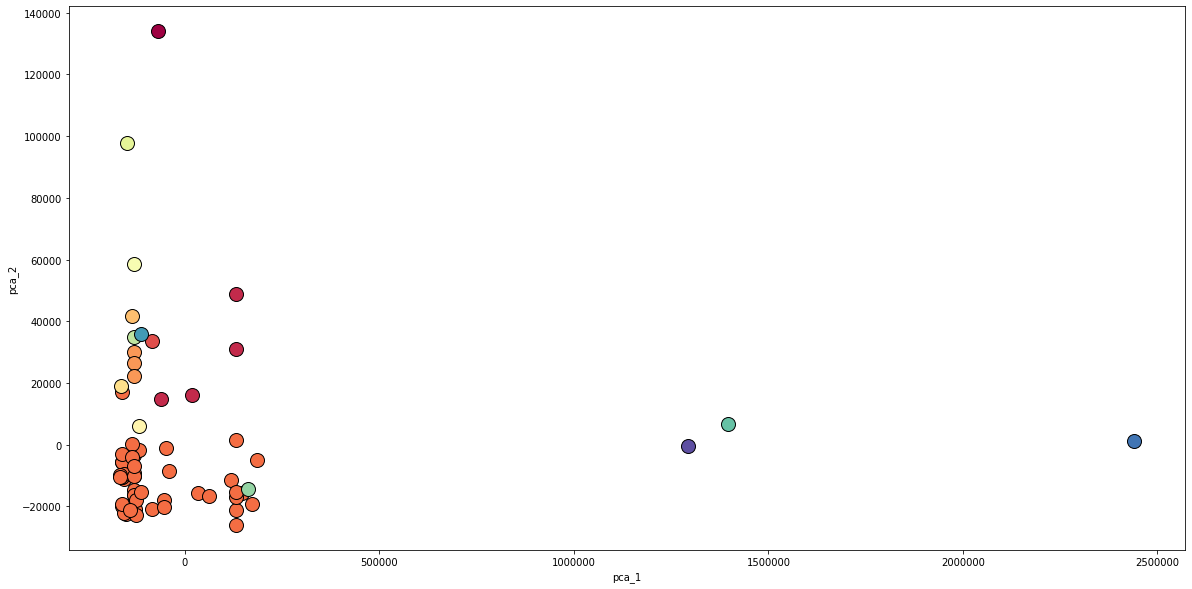

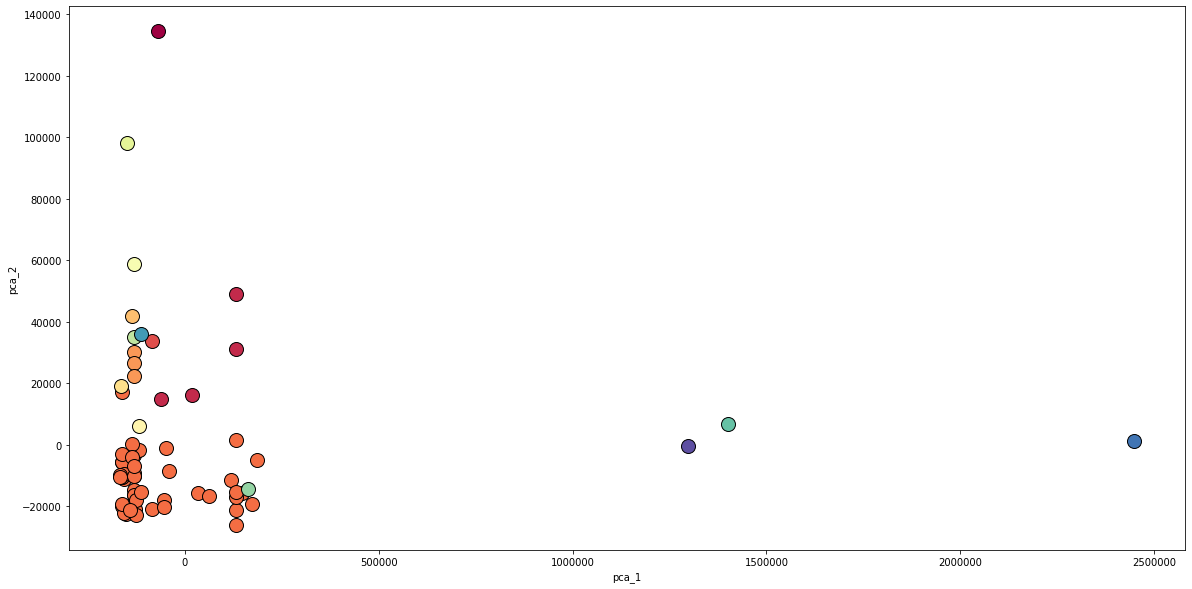

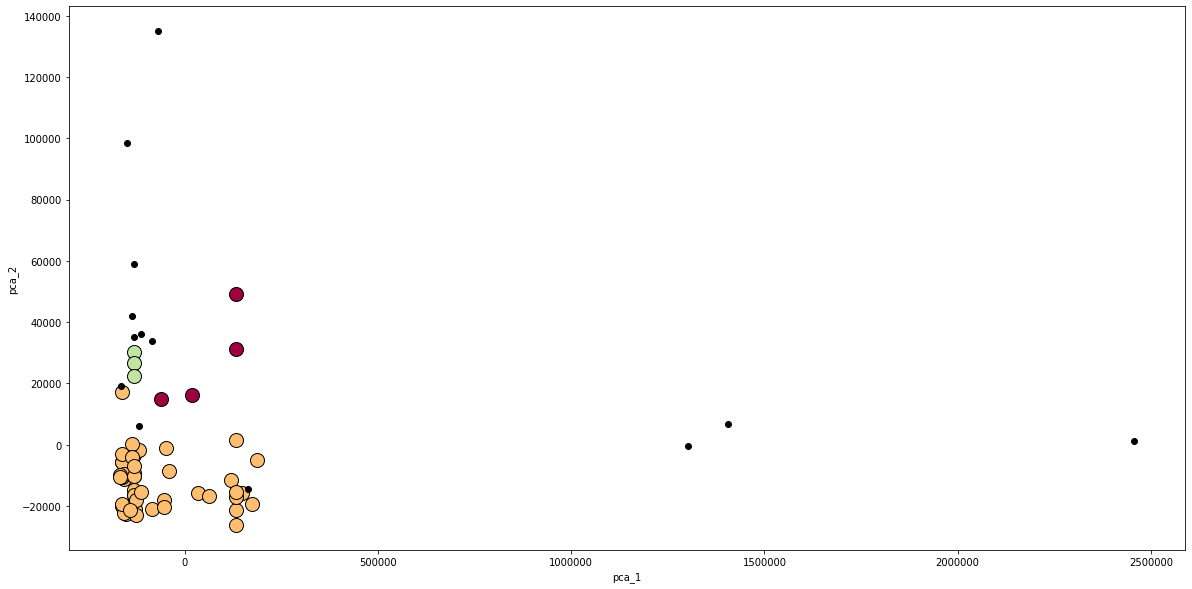

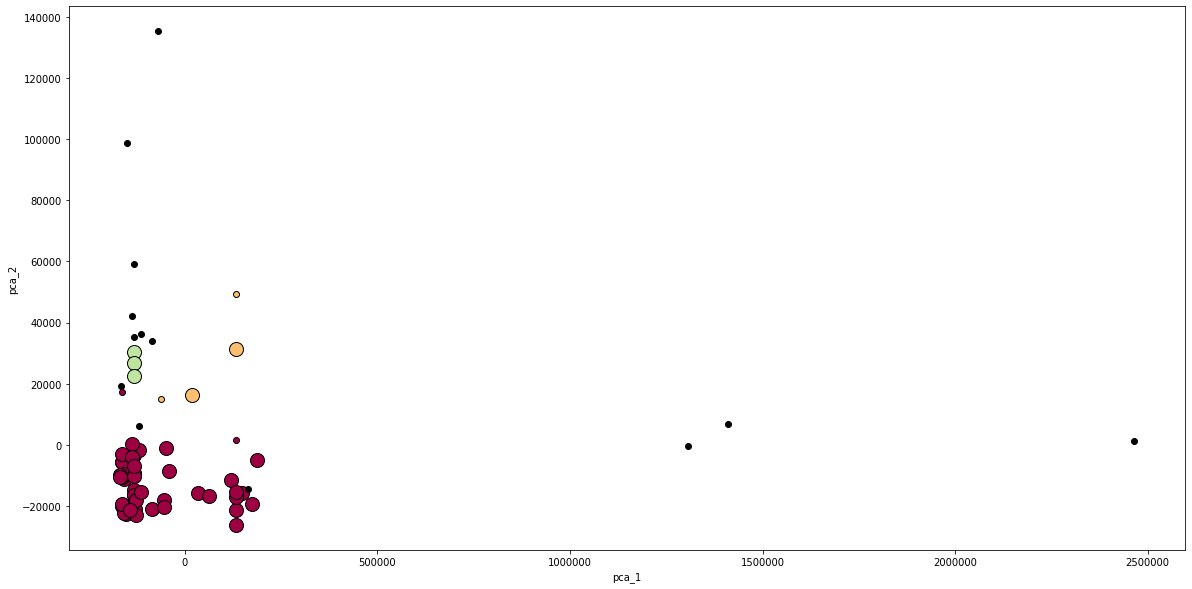

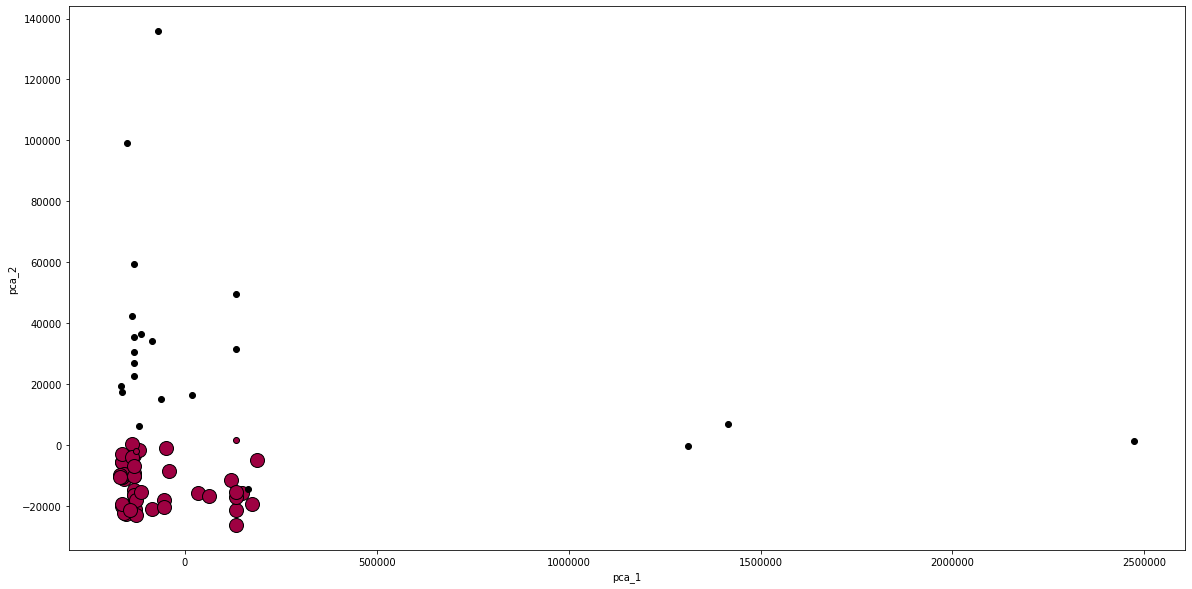

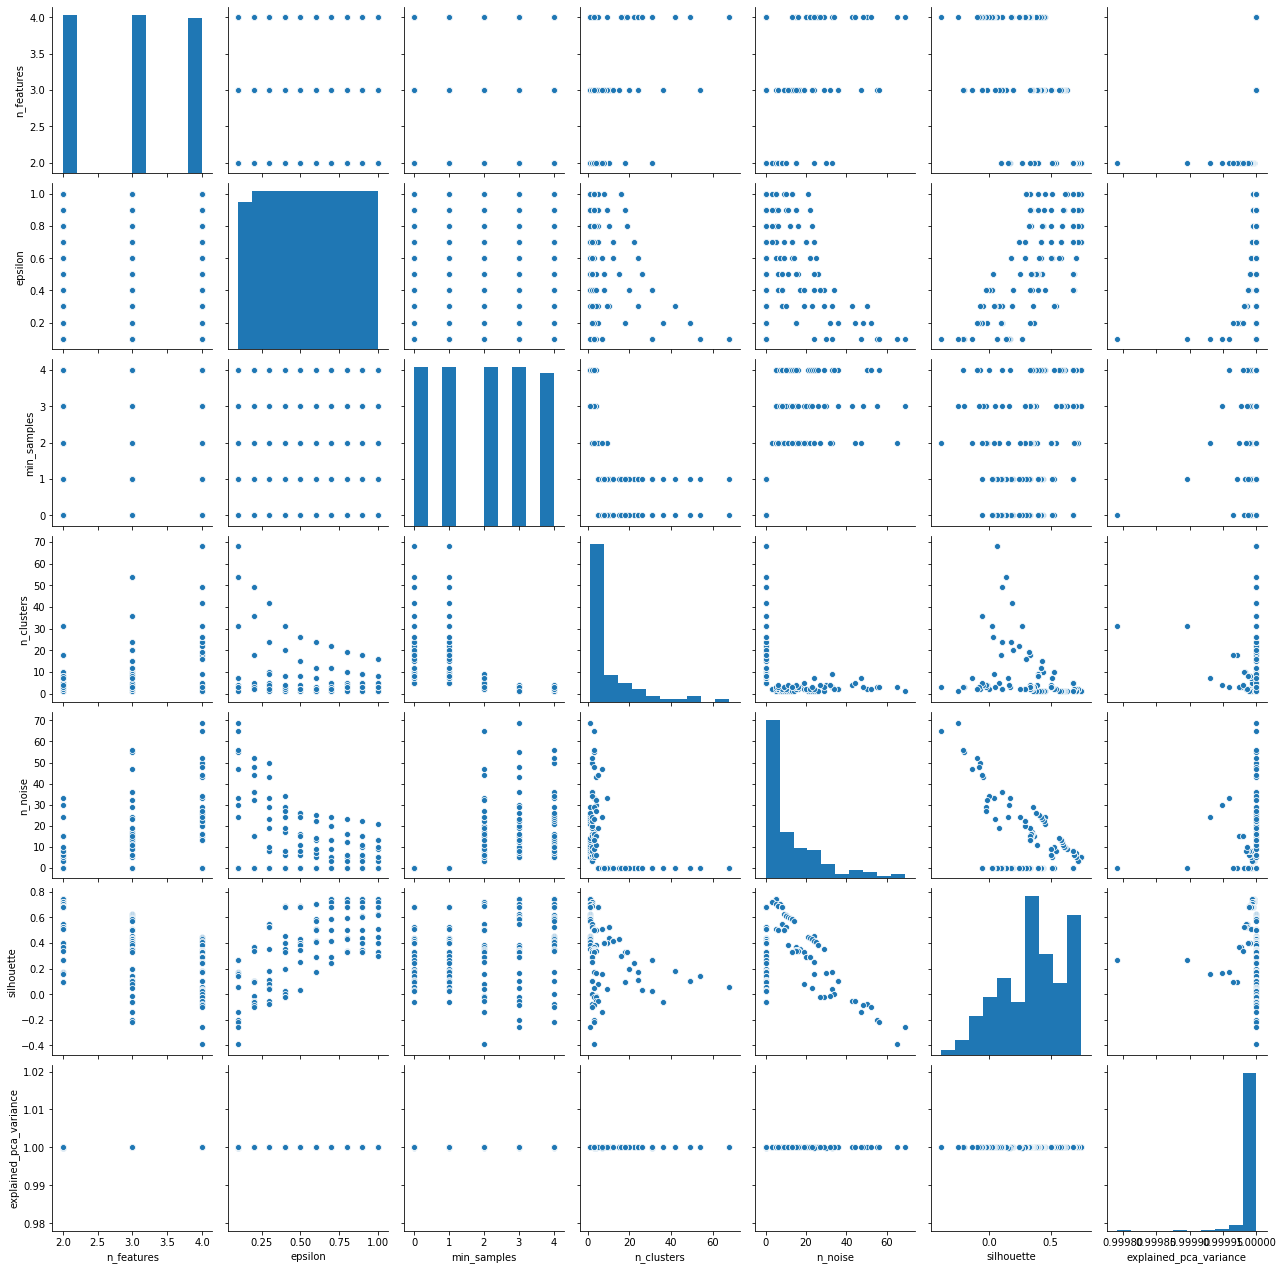

In [8]:
all_metrics = search_best(data)

In [9]:
all_metrics

n_features  epsilon  min_samples  n_clusters  n_noise  silhouette  \
49            2      1.0            4           1        5    0.744060   
48            2      1.0            3           1        5    0.744060   
44            2      0.9            4           1        5    0.744060   
43            2      0.9            3           1        5    0.744060   
39            2      0.8            4           1        5    0.744060   
..          ...      ...          ...         ...      ...         ...   
52            3      0.1            2           7       47   -0.138357   
53            3      0.1            3           3       55   -0.205112   
54            3      0.1            4           3       56   -0.216071   
103           4      0.1            3           1       69   -0.256632   
102           4      0.1            2           3       65   -0.388759   

     explained_pca_variance  
49                 0.999996  
48                 0.999996  
44                 0.999995  
43                 0.999995  
39                 0.999995  
..                      ...  
52                 0.999999  
53                 0.999999  
54                 0.999999  
103                1.000000  
102                1.000000  

[149 rows x 7 columns]

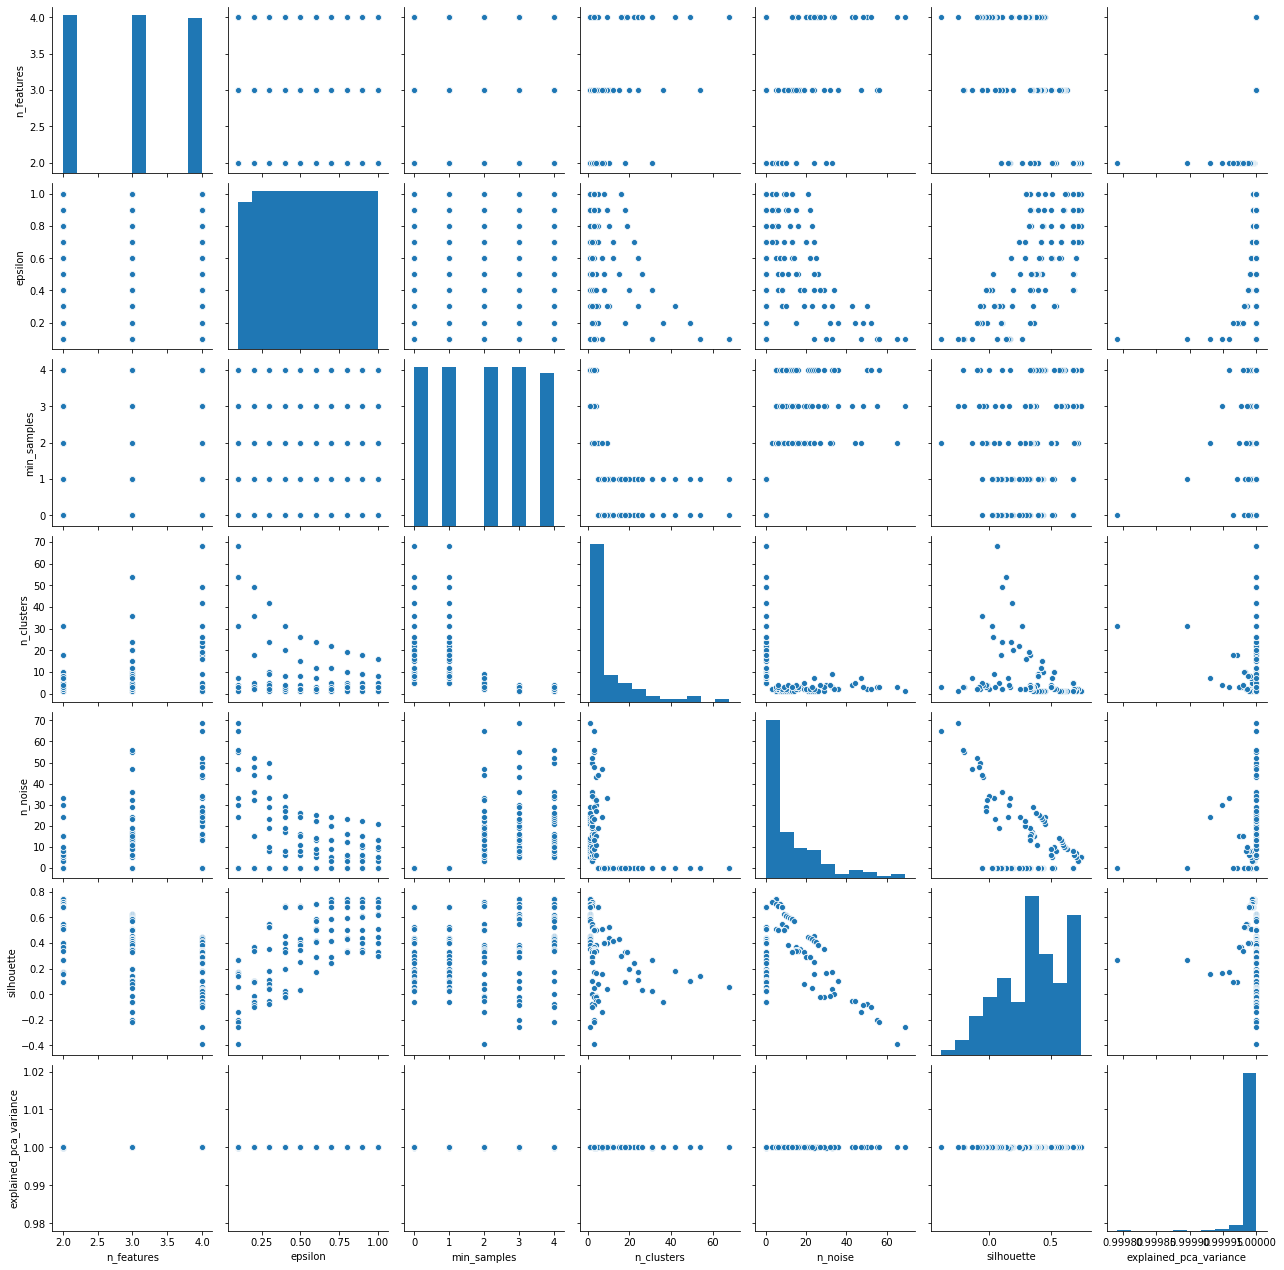

In [9]:
import seaborn as sns

sns.pairplot(all_metrics)

Metrics:
{'n_features': 2, 'epsilon': 0.3, 'min_samples': 3, 'n_clusters': 2, 'n_noise': 8, 'silhouette': 0.5440398456381437, 'explained_pca_variance': 0.9998807337346778}


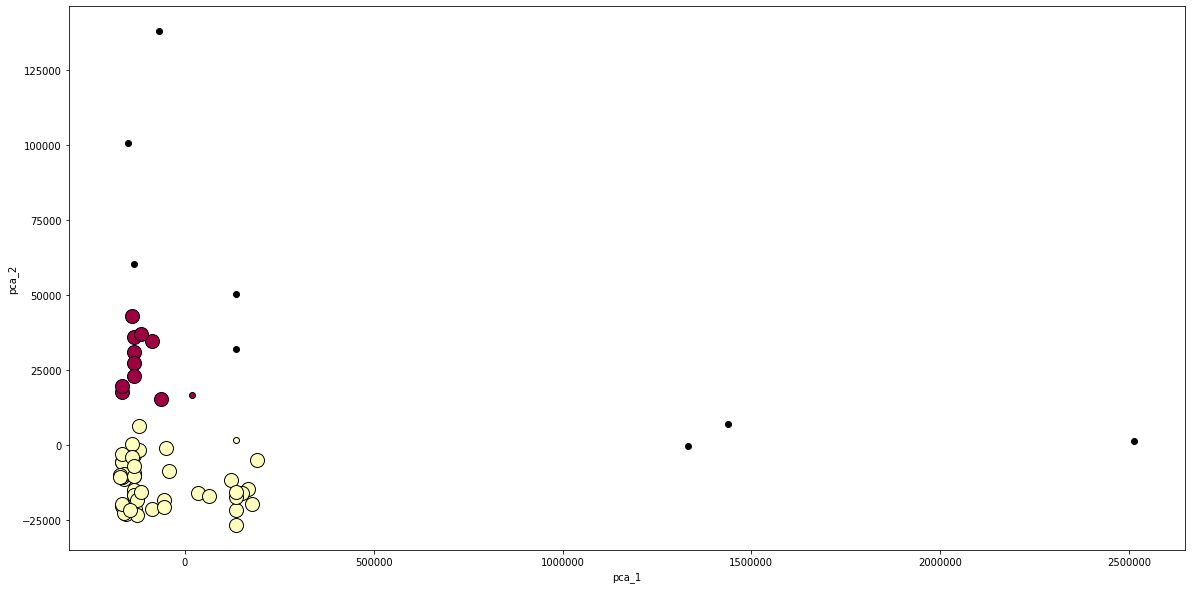

In [16]:
metrics, results = train_DBSCAN(data)
plot_cluster(results)
plt.savefig("damn.png")

In [15]:
image.show()